# Uploading libraries

In [3]:
# Fundamental libraries

import os
import random
import time
import copy

# Working libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from torch.autograd import Variable
from sklearn.metrics import classification_report
import torch.utils.data as data
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as transform
from torchvision.transforms.functional import convert_image_dtype
from PIL import Image
from transformers import AutoImageProcessor, ViTImageProcessor, ViTForImageClassification, ViTConfig, ResNetForImageClassification, ResNetConfig, BeitForImageClassification, BeitConfig, BeitImageProcessor, AutoFeatureExtractor
import torchvision.transforms.functional as TF
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import f1_score
from importlib import reload
import utility
reload(utility)
from utility import load_data, plot_confusion_matrix, plot_average_f1_scores, train_model, get_classification_details, get_hard_disk_path, show_samples, plot_features_importance, visualize_correlation, get_shap
import torch
import wandb
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold
import csv
from sklearn.preprocessing import LabelEncoder
from torch.optim.lr_scheduler import ReduceLROnPlateau
from collections import Counter

# Evaluation
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

# Model Recommendations
VGG-16: Despite being relatively deep, VGG-16 can still be effective on smaller datasets, especially when used with transfer learning. Its simplicity and well-understood architecture make it a good starting point.

ResNet-50: ResNet models, especially the shallower ones like ResNet-50, are known for their ability to avoid overfitting through the use of residual connections. This can be beneficial for learning from small datasets.

MobileNet: Designed for mobile and resource-constrained environments, MobileNets are lightweight and efficient, which can be advantageous when training data is limited.

SqueezeNet: This network achieves AlexNet-level accuracy with significantly fewer parameters. Its compact architecture makes it suitable for small datasets and limited computational resources.

# FILE PATHS on local environment

#### Each folder path represent class (label) :

**Folder name - calss name : description**

0 - 0 class : dead

1 - 1 class : empty

2 - 2 class : keep0

3 - 3 class : keep1

4 - 4 class : keep2

5 - 5 class : reseed0

6 - 6 class : reseed1

7 -  7 class : split

In [4]:
# paths for data upload
FILE_PATHS = ["D:/new_architecture_2/DL1/", "D:/new_architecture_2/DL2/", "D:/new_architecture_2/DL3/"]

TRAIN_FEATURES_PATH_0 = FILE_PATHS[0] + 'keep0' 
TRAIN_FEATURES_PATH_1 = FILE_PATHS[0] + 'keep1'
TRAIN_FEATURES_PATH_2 = FILE_PATHS[0] + 'reseed0'

TRAIN_FEATURES_PATH_3 = FILE_PATHS[1] + 'keep1'
TRAIN_FEATURES_PATH_4 = FILE_PATHS[1] + 'keep2'
TRAIN_FEATURES_PATH_5 = FILE_PATHS[1] + 'reseed1'

TRAIN_FEATURES_PATH_6 = FILE_PATHS[2] + 'keep2'
TRAIN_FEATURES_PATH_7 = FILE_PATHS[2] + 'split'

# list with pathe
PATHES_LISTS = [[TRAIN_FEATURES_PATH_0,TRAIN_FEATURES_PATH_1,TRAIN_FEATURES_PATH_2],[TRAIN_FEATURES_PATH_3,TRAIN_FEATURES_PATH_4, TRAIN_FEATURES_PATH_5], [TRAIN_FEATURES_PATH_6, TRAIN_FEATURES_PATH_7]]

# Data set : train & test

The data was divided into training and testing sets for each class, with a split of 80% for training and 20% for testing, maintaining the same ratio for each class. However, the dataset exhibits an imbalance issue, with one class having a significantly larger number of samples compared to the other class.

In [5]:
labels = ['keep0', 'keep1', 'keep2', 'reseed0', 'reseed1', 'split']
for i, path in enumerate(PATHES_LISTS):
    print(path)

['D:/new_architecture_2/DL1/keep0', 'D:/new_architecture_2/DL1/keep1', 'D:/new_architecture_2/DL1/reseed0']
['D:/new_architecture_2/DL2/keep1', 'D:/new_architecture_2/DL2/keep2', 'D:/new_architecture_2/DL2/reseed1']
['D:/new_architecture_2/DL3/keep2', 'D:/new_architecture_2/DL3/split']


In [6]:
class CustomImageDataset_train(Dataset):
    def __init__(self, img_paths, img_labels, transform=None, model_name=None):
        self.img_sort = img_paths
        self.img_labels = img_labels
        self.transform = transform
        self.processor = None

        # Load the processor if a model name is given
        if model_name == "microsoft/resnet-50":
            self.processor = AutoImageProcessor.from_pretrained(model_name)
        if model_name == "microsoft/resnet-18":
            self.processor = AutoFeatureExtractor.from_pretrained(model_name)
        if model_name == "microsoft/beit-base-patch16-224-pt22k-ft22k":
            self.processor = BeitImageProcessor.from_pretrained(model_name)
        if model_name == "google/vit-base-patch16-224":
            self.processor = ViTImageProcessor.from_pretrained(model_name)

        self.original_len = len(self.img_sort)

    def __len__(self):
        return self.original_len * 4

    def __getitem__(self, idx):
        original_idx = idx % self.original_len
        augmentation_index = idx // self.original_len

        # Load image
        img_path = self.img_sort[original_idx]
        try:
            PIL_image = Image.open(img_path).convert("L")

            # The image can be converted to tensor using
            image = transform.to_tensor(PIL_image)
            image = image * 255
            image = image.type(torch.uint8)
        except Exception as e:
            print(f"Error reading image {img_path}: {e}")
            # Handle error (e.g., by skipping this sample or using a default image)
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Apply augmentations
        image = self.augmentation(image, augmentation_index)

        # Process the image if a processor is set
        if self.processor:
            image = self.processor(images=image, return_tensors="pt").pixel_values.squeeze()

        # Get label
        label = torch.tensor(self.img_labels[original_idx], dtype=torch.long)

        return image, label
        
    def augmentation(self, image, augmentation_index):
        # Random horizontal flipping
        flip_type = augmentation_index % 2  # 0 for horizontal, 1 for vertical
        rotation = (augmentation_index // 2) * 90  # Will give 0, 90, 180, 270

        # Apply flip
        if flip_type == 0:
            image = TF.hflip(image)
        else:
            image = TF.vflip(image)

        # Apply rotation
        image = TF.rotate(image, rotation)

        return image

### Separate data to train and test data with ratio 0.8 in test data

To utilize the CustomImageDataset_test and CustomImageDataset_train, it is necessary to specify the desired transformations for each case, such as Normalize and CenterCrop.

The following code demonstrates how to define the transformations:

For test data transformation using CenterCrop:

In [7]:
class CustomImageDataset_test(Dataset):
    def __init__(self, img_paths, img_labels, transform=None, model_name=None):
        self.img_sort = img_paths   # List of image paths
        self.img_labels = img_labels # Corresponding labels for each image
        self.transform = transform
        self.processor = None

        # Load the processor if a model name is given
        if model_name == "microsoft/resnet-50":
            self.processor = AutoImageProcessor.from_pretrained(model_name)
        if model_name == "microsoft/resnet-18":
            self.processor = AutoFeatureExtractor.from_pretrained(model_name)
        if model_name == "microsoft/beit-base-patch16-224-pt22k-ft22k":
            self.processor = BeitImageProcessor.from_pretrained(model_name)
        if model_name == "google/vit-base-patch16-224":
            self.processor = ViTImageProcessor.from_pretrained(model_name)
        
        self.len = len(self.img_sort)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        img_path = self.img_sort[idx]
        try:
            PIL_image = Image.open(img_path).convert("L")

            # The image can be converted to tensor using
            image = transform.to_tensor(PIL_image)
            image = image * 255
            image = image.type(torch.uint8)
        except Exception as e:
            print(f"Error reading image {img_path}: {e}")
            # Handle error (e.g., by skipping this sample or using a default image)

        label = torch.tensor(self.img_labels[idx], dtype=torch.long)
        
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)
            
        if self.transform:
            image = self.transform(image)

        if self.processor:
            image = self.processor(images=image, return_tensors="pt").pixel_values.squeeze()

        return image, label

In [8]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print('Early stopping triggered')
                self.early_stop = True

class_0_f1_score,▁▁██▂▂
class_1_f1_score,▁▁██▁▁
class_2_f1_score,▁▁██▁▁
epoch,▁▁██▁▁
final_accuracy,▁
fold,▁▁▁▁▁██
train_loss,█▁▇
val_accuracy,▁█▂
val_loss,█▁█
class_0_f1_score,0.11278
class_1_f1_score,0.53763


Training on fold 1/5


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


cuda
Epoch 1, Train Loss: 0.9914989693220272, Validation Loss: 0.9767263531684875, Accuracy: 54.11764705882353 %
Class 0 F1 Score: 0.544378698224852
Class 1 F1 Score: 0.5679012345679012
Class 2 F1 Score: 0.0
Epoch 2, Train Loss: 0.7394859097724737, Validation Loss: 0.7550347248713175, Accuracy: 71.17647058823529 %
Class 0 F1 Score: 0.7614213197969544
Class 1 F1 Score: 0.6717557251908397
Class 2 F1 Score: 0.3333333333333333
Epoch 3, Train Loss: 0.5254112572170967, Validation Loss: 0.8028541405995687, Accuracy: 59.411764705882355 %
Class 0 F1 Score: 0.7298578199052133
Class 1 F1 Score: 0.3947368421052631
Class 2 F1 Score: 0.339622641509434
Epoch 4, Train Loss: 0.44685485196668046, Validation Loss: 0.8319634795188904, Accuracy: 59.411764705882355 %
Class 0 F1 Score: 0.6888888888888889
Class 1 F1 Score: 0.5940594059405939
Class 2 F1 Score: 0.3050847457627119
Epoch 5, Train Loss: 0.38468166319436803, Validation Loss: 6.082063913345337, Accuracy: 8.823529411764707 %
Class 0 F1 Score: 0.09345

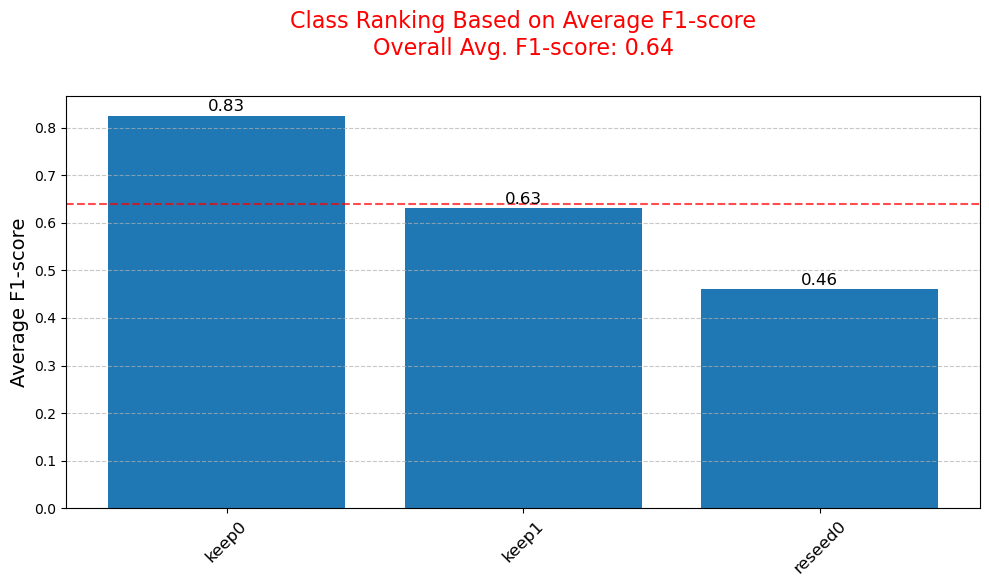

Training on fold 2/5


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


cuda
Epoch 1, Train Loss: 0.9974728295969408, Validation Loss: 0.9178326924641927, Accuracy: 68.82352941176471 %
Class 0 F1 Score: 0.717391304347826
Class 1 F1 Score: 0.6986301369863014
Class 2 F1 Score: 0.0
Epoch 2, Train Loss: 0.7217356895291528, Validation Loss: 0.7364257375399271, Accuracy: 64.70588235294117 %
Class 0 F1 Score: 0.6369426751592356
Class 1 F1 Score: 0.6797385620915032
Class 2 F1 Score: 0.5333333333333333
Epoch 3, Train Loss: 0.5290025403333265, Validation Loss: 0.6413934429486593, Accuracy: 67.05882352941177 %
Class 0 F1 Score: 0.64
Class 1 F1 Score: 0.7080745341614907
Class 2 F1 Score: 0.6206896551724138
Epoch 4, Train Loss: 0.4323826321335726, Validation Loss: 0.5319048265616099, Accuracy: 70.58823529411765 %
Class 0 F1 Score: 0.7344632768361582
Class 1 F1 Score: 0.7317073170731706
Class 2 F1 Score: 0.5
Epoch 5, Train Loss: 0.3669248909451241, Validation Loss: 0.5754828055699667, Accuracy: 71.17647058823529 %
Class 0 F1 Score: 0.7738693467336684
Class 1 F1 Score: 0

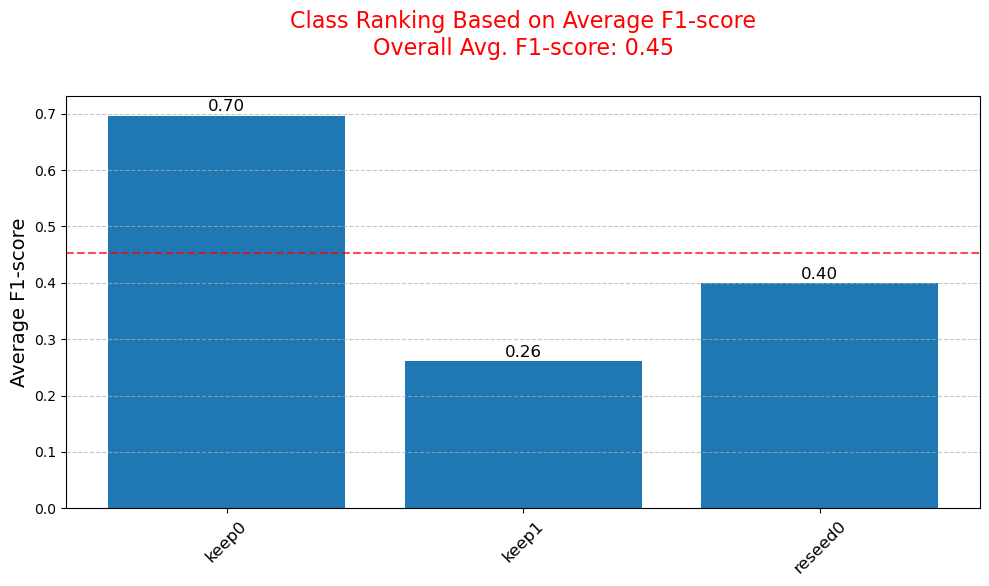

Training on fold 3/5


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


cuda
Epoch 1, Train Loss: 0.9835990625758504, Validation Loss: 0.9971929987271627, Accuracy: 58.8235294117647 %
Class 0 F1 Score: 0.6497461928934011
Class 1 F1 Score: 0.5413533834586466
Class 2 F1 Score: 0.0
Epoch 2, Train Loss: 0.7610270935435628, Validation Loss: 0.6738484104474386, Accuracy: 71.76470588235294 %
Class 0 F1 Score: 0.7894736842105263
Class 1 F1 Score: 0.6138613861386139
Class 2 F1 Score: 0.18181818181818182
Epoch 3, Train Loss: 0.5680802817954573, Validation Loss: 0.6740849018096924, Accuracy: 60.588235294117645 %
Class 0 F1 Score: 0.7027027027027027
Class 1 F1 Score: 0.5714285714285714
Class 2 F1 Score: 0.3508771929824561
Epoch 4, Train Loss: 0.4427186520986779, Validation Loss: 1.3765523831049602, Accuracy: 65.29411764705883 %
Class 0 F1 Score: 0.6585365853658537
Class 1 F1 Score: 0.6867469879518072
Class 2 F1 Score: 0.0
Epoch 5, Train Loss: 0.3993825143159822, Validation Loss: 0.6371870239575704, Accuracy: 72.94117647058823 %
Class 0 F1 Score: 0.790909090909091
Clas

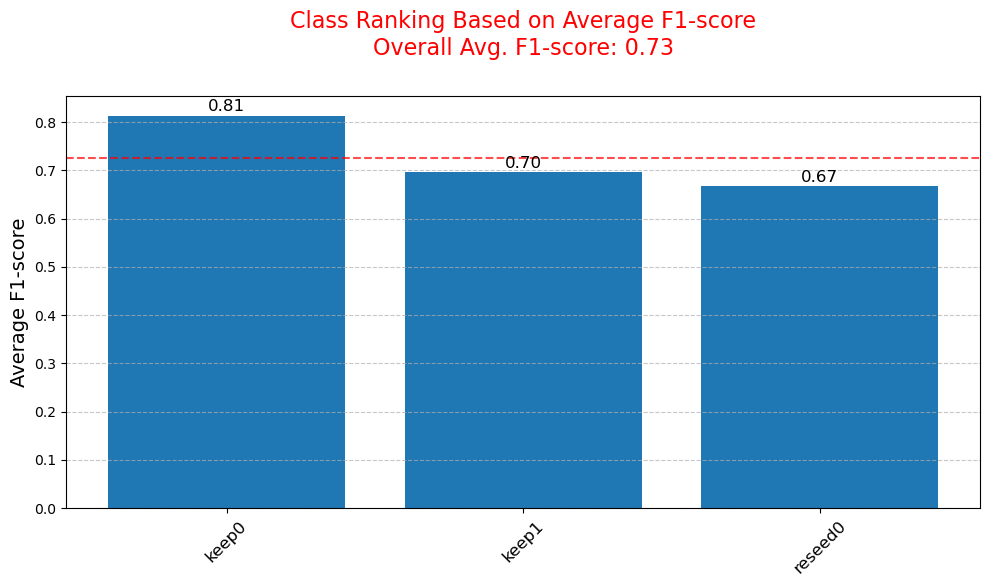

Training on fold 4/5


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


cuda
Epoch 1, Train Loss: 0.9627731899882472, Validation Loss: 0.8974483211835226, Accuracy: 71.00591715976331 %
Class 0 F1 Score: 0.7837837837837837
Class 1 F1 Score: 0.6153846153846153
Class 2 F1 Score: 0.16666666666666666
Epoch 2, Train Loss: 0.6735979159211003, Validation Loss: 0.7796435952186584, Accuracy: 69.23076923076923 %
Class 0 F1 Score: 0.7575757575757575
Class 1 F1 Score: 0.6386554621848739
Class 2 F1 Score: 0.380952380952381
Epoch 3, Train Loss: 0.45137151729228886, Validation Loss: 0.8037797013918558, Accuracy: 72.7810650887574 %
Class 0 F1 Score: 0.7945205479452055
Class 1 F1 Score: 0.6019417475728156
Class 2 F1 Score: 0.6250000000000001
Epoch 4, Train Loss: 0.36922471745069635, Validation Loss: 0.8382192254066467, Accuracy: 60.35502958579882 %
Class 0 F1 Score: 0.6335403726708075
Class 1 F1 Score: 0.6666666666666666
Class 2 F1 Score: 0.3111111111111111
Epoch 5, Train Loss: 0.3423318436672521, Validation Loss: 0.8380663593610128, Accuracy: 70.41420118343196 %
Class 0 F1

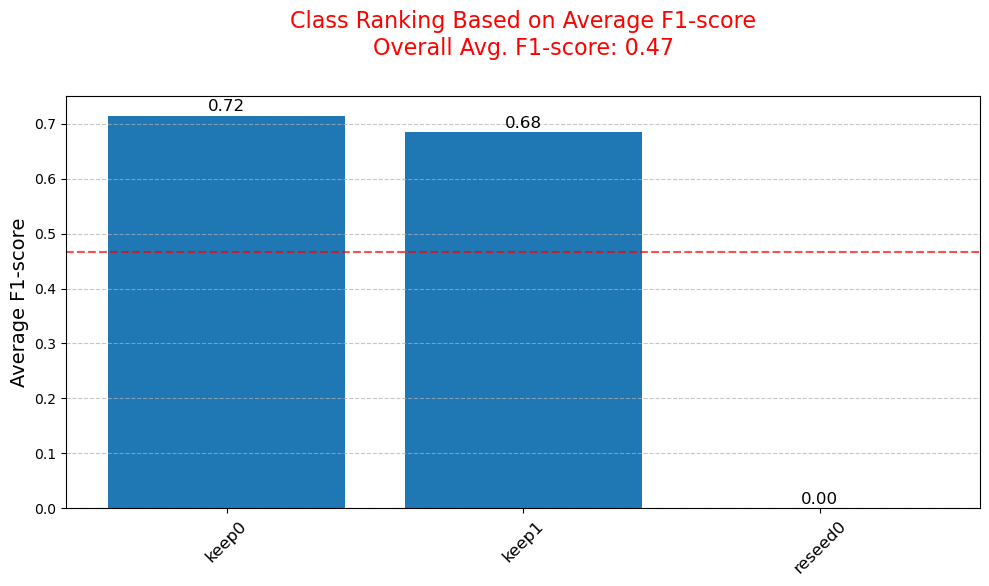

Training on fold 5/5


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


cuda
Epoch 1, Train Loss: 1.0109516174294229, Validation Loss: 0.9509106278419495, Accuracy: 62.72189349112426 %
Class 0 F1 Score: 0.7096774193548387
Class 1 F1 Score: 0.5178571428571428
Class 2 F1 Score: 0.0
Epoch 2, Train Loss: 0.7393801572710968, Validation Loss: 0.5725226700305939, Accuracy: 74.55621301775147 %
Class 0 F1 Score: 0.7918781725888325
Class 1 F1 Score: 0.6721311475409835
Class 2 F1 Score: 0.7368421052631577
Epoch 3, Train Loss: 0.5115441139354262, Validation Loss: 0.646906852722168, Accuracy: 63.31360946745562 %
Class 0 F1 Score: 0.6103896103896103
Class 1 F1 Score: 0.650887573964497
Class 2 F1 Score: 0.6666666666666667
Epoch 4, Train Loss: 0.4221574251734933, Validation Loss: 0.8330754041671753, Accuracy: 65.68047337278107 %
Class 0 F1 Score: 0.7761194029850748
Class 1 F1 Score: 0.5647058823529413
Class 2 F1 Score: 0.3461538461538462
Epoch 5, Train Loss: 0.35623041973557584, Validation Loss: 0.5160819639762243, Accuracy: 79.28994082840237 %
Class 0 F1 Score: 0.8454545

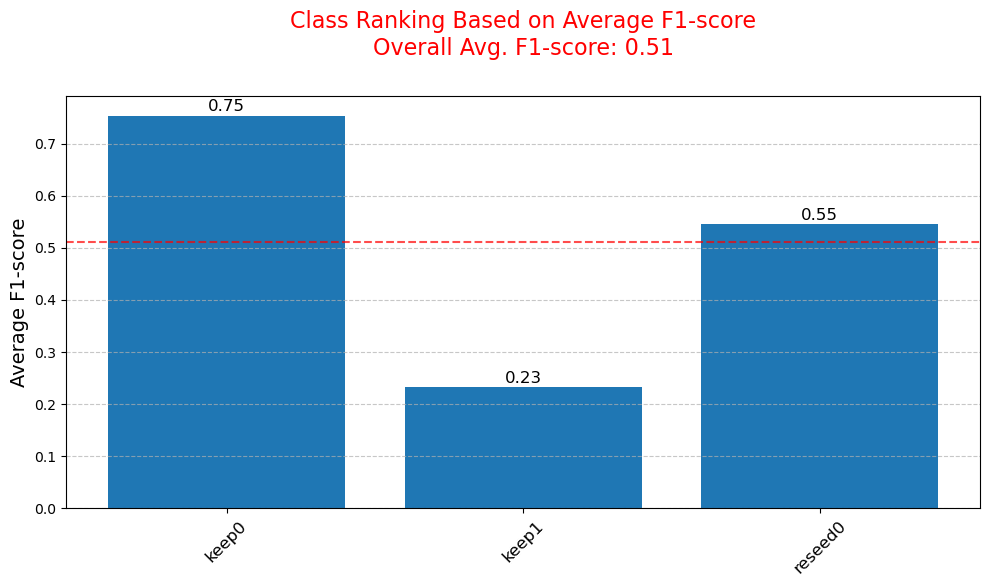

class_0_f1_score,▁▆▅▄▆▄▄▆▆▇▇▇██▅▃▅▆▅▅▃▇▄▇▃▆▃▆▇▆▇▃▅▅▇▆█▃█▆
class_1_f1_score,▆▇▃▆▂██▅█▇▆▇▇▇▇▇█▇█▁▅▆▇▆▇▇▇▇▇▇▆▇▇▅▇▆▇▁█▁
class_2_f1_score,▁▄▄▄▃▄▃▆▆▁▇▄▄▅▁▆▅▅▄▄▁▃▁▆▁▄▆▂▇▄▆▄▁▁▇▄█▃▆▆
epoch,▁▁▂▃▃▃▄▅▅▆▆▇▇█▁▂▂▃▃▄▁▂▂▃▃▄▅▅▁▁▂▃▃▁▂▂▃▃▄▅
final_accuracy,█▁█▅▃
fold,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆███████
train_loss,█▆▄▃▄▃▂▂▂▂▂▁▁▁▆▄▄▃▂▃█▅▄▃▃▂▂▂█▆▃▃▃█▆▄▃▃▂▂
val_accuracy,▂▆▄▄▅▅▅▆▇▇▇▇█▇▆▅▅▆▆▅▃▆▄▇▄▇▅▆▇▆▇▄▆▄▇▄█▁▇▄
val_loss,▃▂▂▃▅▂▄▂▂▇▂▃▄▄▃▂▂▁▃▂▃▂▂▂█▁▃▄▁▃▂▃▃▃▁▂▁▆▁▆
class_0_f1_score,0.75424
class_1_f1_score,0.23188


Training on fold 1/5


The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.


cuda
Epoch 1, Train Loss: 0.7993330955505371, Validation Loss: 0.685140868028005, Accuracy: 61.76470588235294 %
Class 0 F1 Score: 0.6368715083798882
Class 1 F1 Score: 0.6081081081081081
Class 2 F1 Score: 0.46153846153846156
Epoch 2, Train Loss: 0.41505114006441696, Validation Loss: 0.532157743970553, Accuracy: 68.23529411764706 %
Class 0 F1 Score: 0.6625
Class 1 F1 Score: 0.7397260273972602
Class 2 F1 Score: 0.5294117647058824
Epoch 3, Train Loss: 0.3155291846325231, Validation Loss: 0.5186511675516764, Accuracy: 77.05882352941177 %
Class 0 F1 Score: 0.8118811881188118
Class 1 F1 Score: 0.7350427350427351
Class 2 F1 Score: 0.5714285714285715
Epoch 4, Train Loss: 0.21520136539326157, Validation Loss: 0.5759675900141398, Accuracy: 74.70588235294117 %
Class 0 F1 Score: 0.8
Class 1 F1 Score: 0.6956521739130433
Class 2 F1 Score: 0.5
Epoch 5, Train Loss: 0.12642972881710807, Validation Loss: 0.732450877626737, Accuracy: 78.23529411764706 %
Class 0 F1 Score: 0.8181818181818183
Class 1 F1 Scor

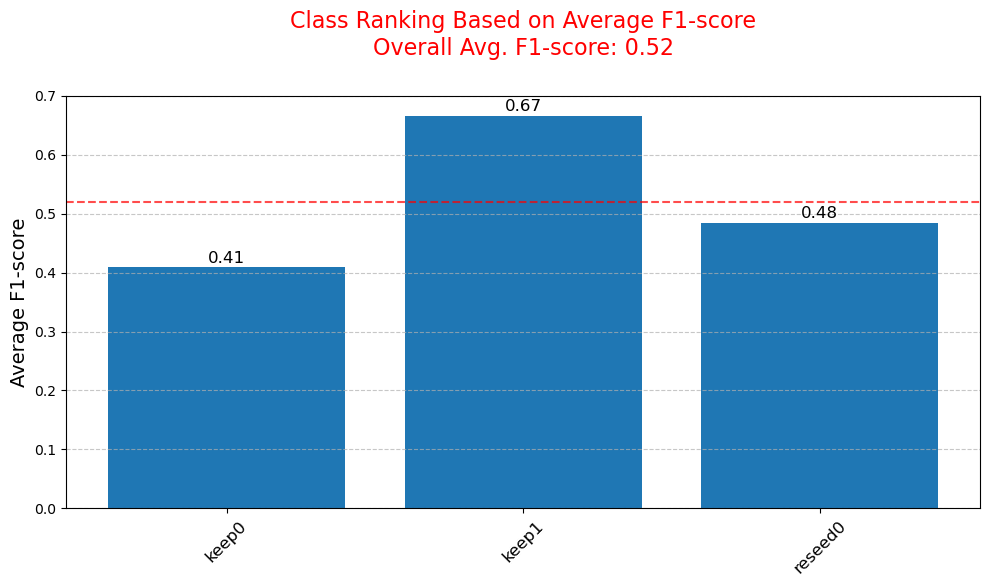

Training on fold 2/5


The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.


cuda
Epoch 1, Train Loss: 0.7582562981649886, Validation Loss: 0.49542765816052753, Accuracy: 80.58823529411765 %
Class 0 F1 Score: 0.8333333333333333
Class 1 F1 Score: 0.7741935483870969
Class 2 F1 Score: 0.75
Epoch 2, Train Loss: 0.4195510748513909, Validation Loss: 0.49349163969357807, Accuracy: 74.70588235294117 %
Class 0 F1 Score: 0.7542857142857142
Class 1 F1 Score: 0.7260273972602739
Class 2 F1 Score: 0.8421052631578948
Epoch 3, Train Loss: 0.3224499534035838, Validation Loss: 0.430881733695666, Accuracy: 82.3529411764706 %
Class 0 F1 Score: 0.8584905660377358
Class 1 F1 Score: 0.7787610619469026
Class 2 F1 Score: 0.6666666666666666
Epoch 4, Train Loss: 0.20851841742216154, Validation Loss: 1.6460938851038616, Accuracy: 60.0 %
Class 0 F1 Score: 0.5874125874125874
Class 1 F1 Score: 0.6417112299465241
Class 2 F1 Score: 0.0
Epoch 5, Train Loss: 0.11517091719217079, Validation Loss: 0.5453102737665176, Accuracy: 81.17647058823529 %
Class 0 F1 Score: 0.836734693877551
Class 1 F1 Scor

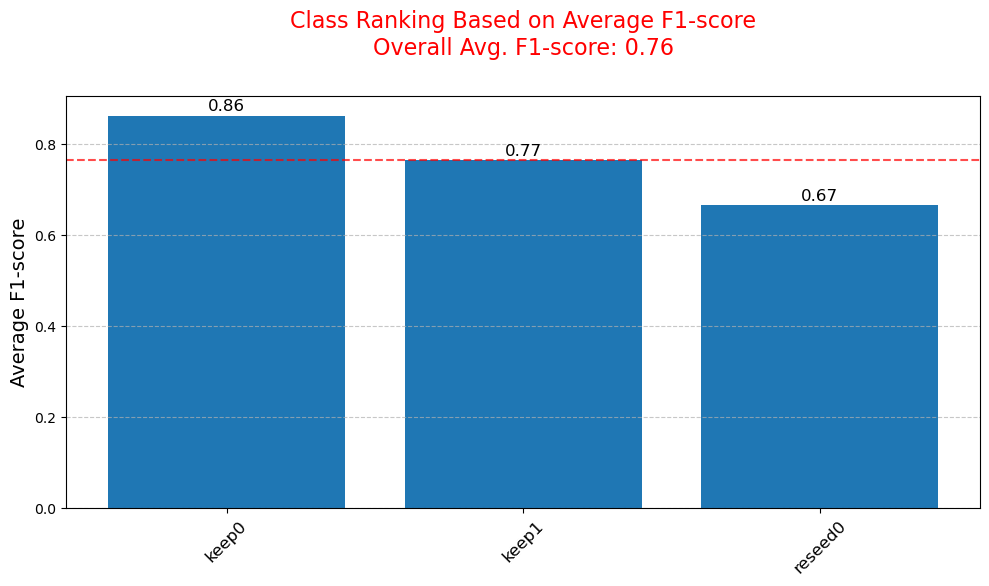

Training on fold 3/5


The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.


cuda
Epoch 1, Train Loss: 0.693346381187439, Validation Loss: 0.8681647082169851, Accuracy: 61.1764705882353 %
Class 0 F1 Score: 0.6995073891625615
Class 1 F1 Score: 0.5849056603773585
Class 2 F1 Score: 0.12903225806451613
Epoch 2, Train Loss: 0.40020001211831735, Validation Loss: 0.5599191337823868, Accuracy: 79.41176470588235 %
Class 0 F1 Score: 0.8223350253807107
Class 1 F1 Score: 0.7559055118110236
Class 2 F1 Score: 0.7499999999999999
Epoch 3, Train Loss: 0.3136822040690932, Validation Loss: 0.5023043726881345, Accuracy: 79.41176470588235 %
Class 0 F1 Score: 0.8454545454545456
Class 1 F1 Score: 0.6868686868686869
Class 2 F1 Score: 0.761904761904762
Epoch 4, Train Loss: 0.17831928023072177, Validation Loss: 0.7712953711549441, Accuracy: 74.11764705882354 %
Class 0 F1 Score: 0.8018018018018018
Class 1 F1 Score: 0.6213592233009709
Class 2 F1 Score: 0.6666666666666666
Epoch 5, Train Loss: 0.09006767797955247, Validation Loss: 0.7631801708290974, Accuracy: 72.3529411764706 %
Class 0 F1 

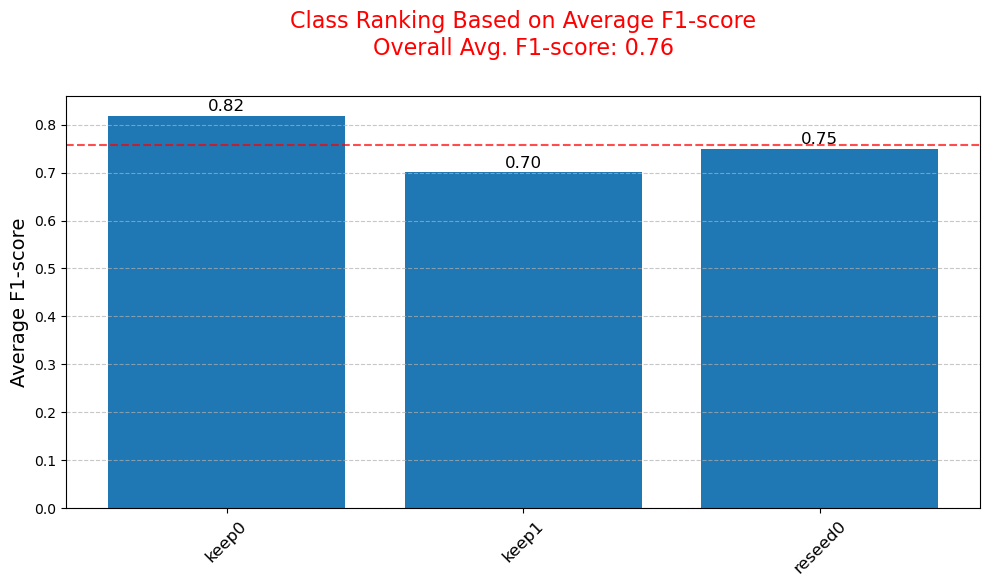

Training on fold 4/5


The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.


cuda
Epoch 1, Train Loss: 0.6637575002603753, Validation Loss: 1.2352851629257202, Accuracy: 60.946745562130175 %
Class 0 F1 Score: 0.605263157894737
Class 1 F1 Score: 0.6440677966101694
Class 2 F1 Score: 0.0
Epoch 2, Train Loss: 0.35056798749191814, Validation Loss: 0.9020071029663086, Accuracy: 72.18934911242603 %
Class 0 F1 Score: 0.7640449438202247
Class 1 F1 Score: 0.6891891891891891
Class 2 F1 Score: 0.5
Epoch 3, Train Loss: 0.3024176705715268, Validation Loss: 0.6270624101161957, Accuracy: 69.8224852071006 %
Class 0 F1 Score: 0.7715736040609137
Class 1 F1 Score: 0.6415094339622641
Class 2 F1 Score: 0.4571428571428572
Epoch 4, Train Loss: 0.18736454012782075, Validation Loss: 0.6833743502696356, Accuracy: 76.33136094674556 %
Class 0 F1 Score: 0.8272727272727273
Class 1 F1 Score: 0.6407766990291263
Class 2 F1 Score: 0.6666666666666667
Epoch 5, Train Loss: 0.1068146113566188, Validation Loss: 1.5306168993314107, Accuracy: 65.68047337278107 %
Class 0 F1 Score: 0.6578947368421052
Cla

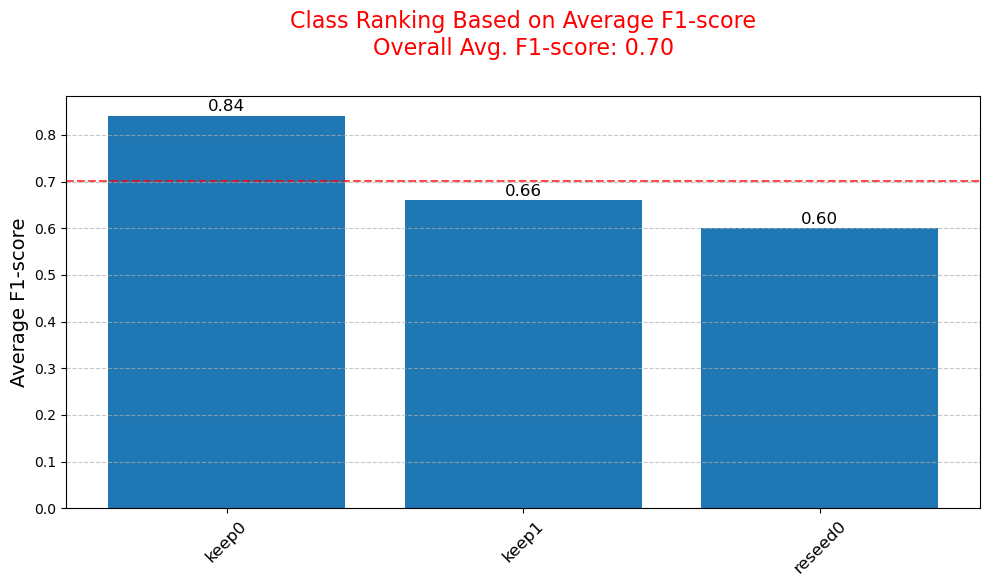

Training on fold 5/5


The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.


cuda
Epoch 1, Train Loss: 0.7491874667101128, Validation Loss: 0.6399134397506714, Accuracy: 71.59763313609467 %
Class 0 F1 Score: 0.7777777777777777
Class 1 F1 Score: 0.6428571428571429
Class 2 F1 Score: 0.19999999999999998
Epoch 2, Train Loss: 0.43299737919208614, Validation Loss: 0.5152384092410406, Accuracy: 75.7396449704142 %
Class 0 F1 Score: 0.8341232227488151
Class 1 F1 Score: 0.653061224489796
Class 2 F1 Score: 0.5517241379310346
Epoch 3, Train Loss: 0.3040250536314277, Validation Loss: 0.5141775061686834, Accuracy: 76.92307692307692 %
Class 0 F1 Score: 0.8333333333333334
Class 1 F1 Score: 0.6136363636363636
Class 2 F1 Score: 0.7272727272727274
Epoch 4, Train Loss: 0.1867356504811797, Validation Loss: 0.5709793418645859, Accuracy: 78.10650887573965 %
Class 0 F1 Score: 0.8407079646017698
Class 1 F1 Score: 0.6304347826086957
Class 2 F1 Score: 0.7999999999999999
Epoch 5, Train Loss: 0.09703070098577543, Validation Loss: 0.7514656682809194, Accuracy: 73.96449704142012 %
Class 0 F1

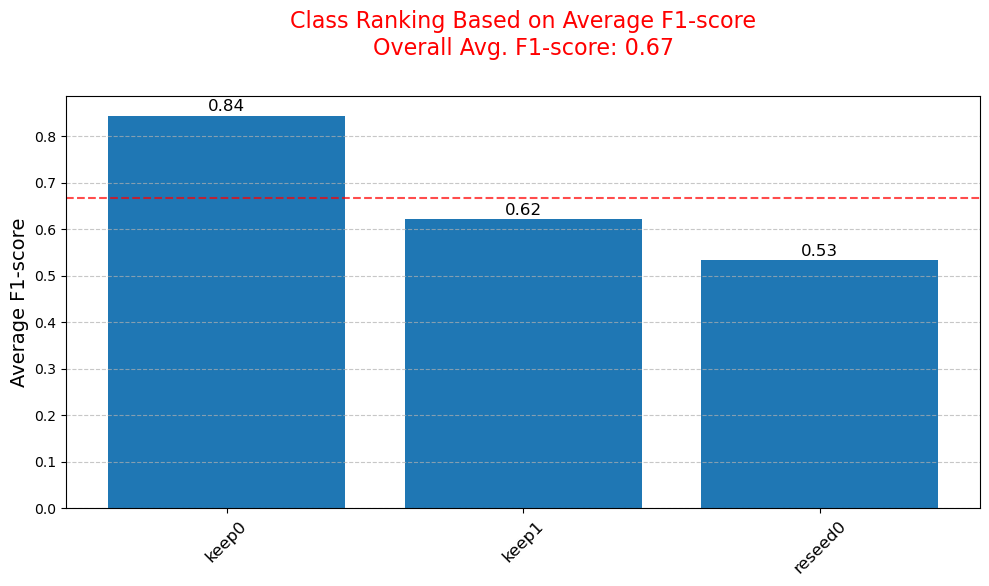

class_0_f1_score,▄▄▅▇▇▇▂▁▇▆█▄▇█▇███▅▇█▇▇▇▇▄▆▆▆▇▅▇█▇▇▇█▆██
class_1_f1_score,▄▄▇▇▆▇▆▅█▇█▅█▇██▇▇▃▇▆▄▁▃▆▅▆▆▅▅▆▅▅▅▅▄▄▇█▄
class_2_f1_score,▅▅▅▆▅▅▃▅▇█▆▁▆█▂▅▆▆▂▇▇▆█▅▇▁▅▅▅▆▃▆▆▃▅▇▇█▆▅
epoch,▁▂▃▃▄▅▆▆▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▆▁▂▃▃▄▅▆▆▁▂▃▃▄▅▆
final_accuracy,▁█▇▇▆
fold,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆███████
train_loss,█▅▄▃▂▂▁▁█▅▄▃▂▁▁▁▁▁▇▄▄▃▂▁▁▁▄▄▃▂▂▁▁█▅▄▃▂▁▁
val_accuracy,▄▅▇▆▇▁▃▇▆█▃██▇███▄▇▇▆▆▆▇▄▆▅▇▅▇▇▆▇▇▇▆█▇
val_loss,▃▂▂▂▃█▆▂▂▁▇▂▁▄▃▂▂▃▂▂▃▃▄▃▅▄▂▃▆▃▃▂▂▂▂▃▂▃
class_0_f1_score,0.84404
class_1_f1_score,0.62222


Training on fold 1/5
cuda
Epoch 1, Train Loss: 1.2833150791567425, Validation Loss: 1.1078256964683533, Accuracy: 21.764705882352942 %
Class 0 F1 Score: 0.26890756302521013
Class 1 F1 Score: 0.2823529411764706
Class 2 F1 Score: 0.13235294117647056
Epoch 2, Train Loss: 0.9301949531532997, Validation Loss: 0.951797087987264, Accuracy: 37.64705882352941 %
Class 0 F1 Score: 0.34108527131782945
Class 1 F1 Score: 0.5074626865671642
Class 2 F1 Score: 0.20779220779220778
Epoch 3, Train Loss: 0.8662989402926246, Validation Loss: 0.823775589466095, Accuracy: 51.76470588235294 %
Class 0 F1 Score: 0.5534591194968553
Class 1 F1 Score: 0.5538461538461539
Class 2 F1 Score: 0.3137254901960784
Epoch 4, Train Loss: 0.872155906156052, Validation Loss: 0.858527660369873, Accuracy: 45.88235294117647 %
Class 0 F1 Score: 0.43795620437956206
Class 1 F1 Score: 0.5571428571428573
Class 2 F1 Score: 0.2857142857142857
Epoch 5, Train Loss: 0.8407505307086679, Validation Loss: 0.9257645805676779, Accuracy: 37.05882

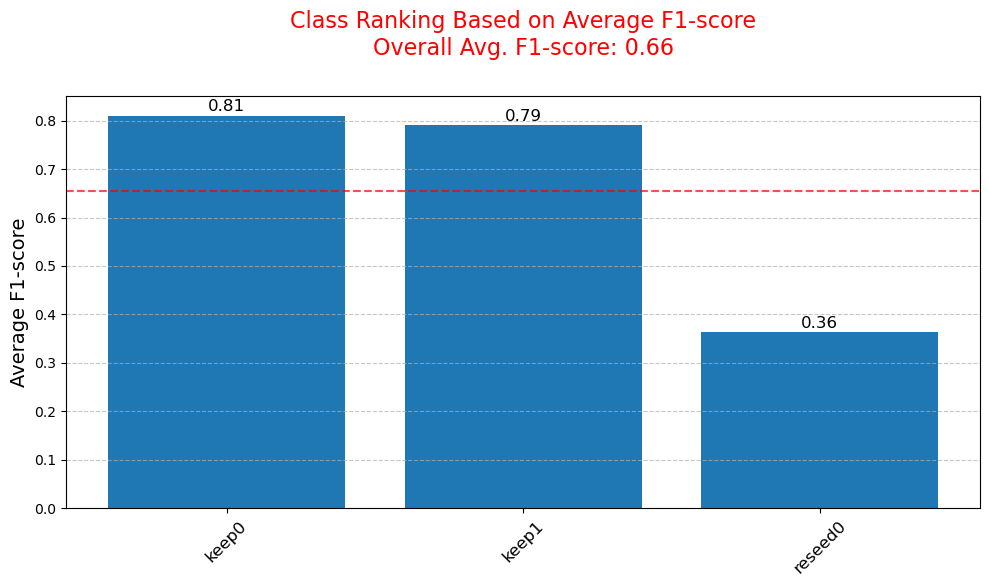

Training on fold 2/5
cuda
Epoch 1, Train Loss: 1.3287770900615425, Validation Loss: 0.9257246851921082, Accuracy: 58.23529411764706 %
Class 0 F1 Score: 0.6534653465346535
Class 1 F1 Score: 0.5454545454545455
Class 2 F1 Score: 0.0
Epoch 2, Train Loss: 0.9630650891814121, Validation Loss: 0.9751751025517782, Accuracy: 48.23529411764706 %
Class 0 F1 Score: 0.3870967741935484
Class 1 F1 Score: 0.6181818181818183
Class 2 F1 Score: 0.2745098039215686
Epoch 3, Train Loss: 0.9467356925786927, Validation Loss: 0.8489432334899902, Accuracy: 53.529411764705884 %
Class 0 F1 Score: 0.5714285714285714
Class 1 F1 Score: 0.639344262295082
Class 2 F1 Score: 0.28169014084507044
Epoch 4, Train Loss: 0.8450888090355452, Validation Loss: 1.0843116243680317, Accuracy: 53.529411764705884 %
Class 0 F1 Score: 0.45925925925925926
Class 1 F1 Score: 0.6310160427807486
Class 2 F1 Score: 0.11111111111111112
Epoch 5, Train Loss: 0.8039664182552072, Validation Loss: 0.7377298275629679, Accuracy: 55.294117647058826 %


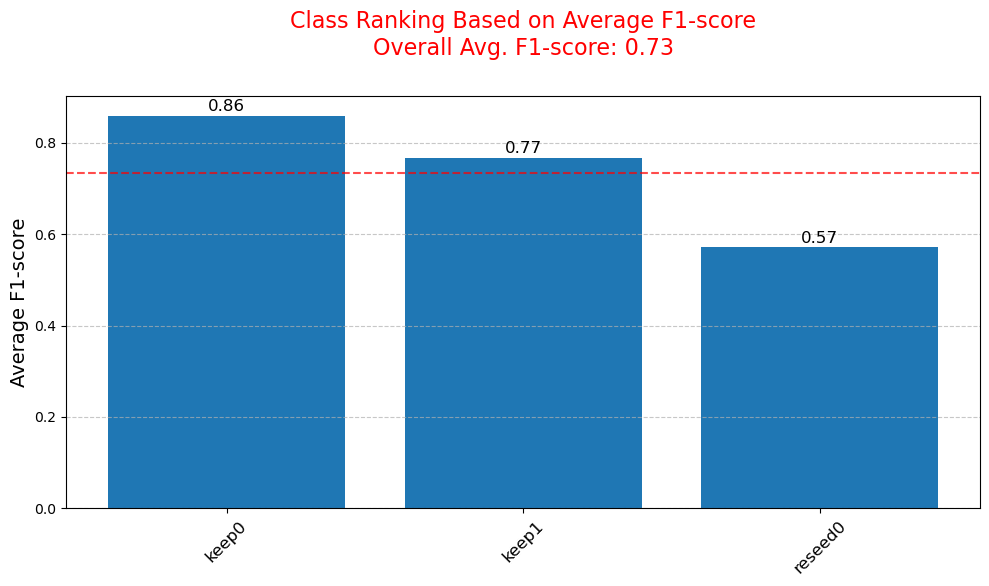

Training on fold 3/5
cuda
Epoch 1, Train Loss: 1.251751770806867, Validation Loss: 0.938306470712026, Accuracy: 52.35294117647059 %
Class 0 F1 Score: 0.5398773006134969
Class 1 F1 Score: 0.5499999999999999
Class 2 F1 Score: 0.11764705882352941
Epoch 2, Train Loss: 0.9450636062511178, Validation Loss: 0.9466166694959005, Accuracy: 48.23529411764706 %
Class 0 F1 Score: 0.46043165467625896
Class 1 F1 Score: 0.5405405405405405
Class 2 F1 Score: 0.37735849056603776
Epoch 3, Train Loss: 0.906960686971975, Validation Loss: 0.8192792733510336, Accuracy: 52.35294117647059 %
Class 0 F1 Score: 0.5135135135135135
Class 1 F1 Score: 0.5512820512820513
Class 2 F1 Score: 0.4444444444444444
Epoch 4, Train Loss: 0.839162337225537, Validation Loss: 0.7492580413818359, Accuracy: 61.76470588235294 %
Class 0 F1 Score: 0.7333333333333333
Class 1 F1 Score: 0.4222222222222222
Class 2 F1 Score: 0.45000000000000007
Epoch 5, Train Loss: 0.8075912483902865, Validation Loss: 0.7050142784913381, Accuracy: 55.8823529

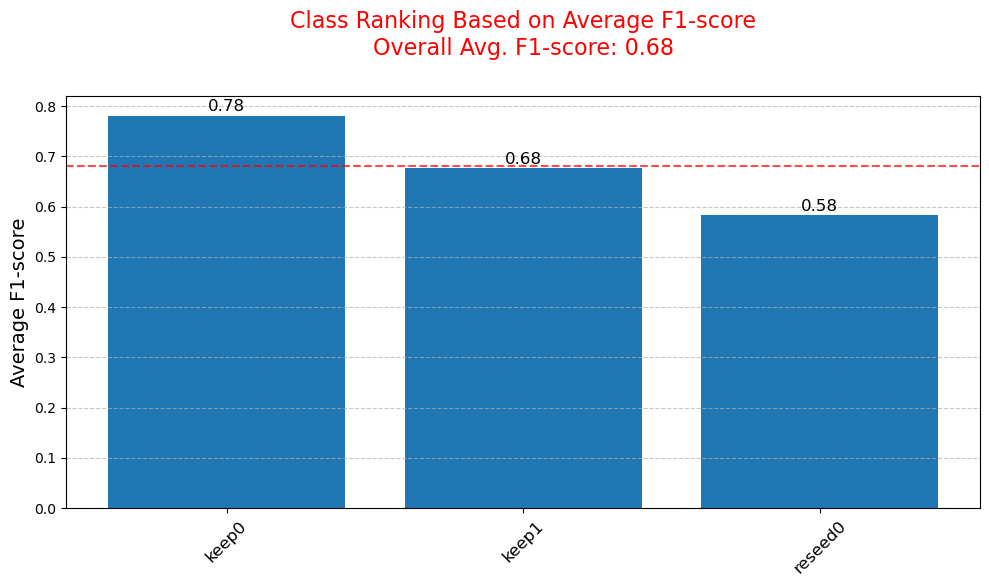

Training on fold 4/5
cuda
Epoch 1, Train Loss: 1.2235736375631288, Validation Loss: 0.9638493855794271, Accuracy: 44.37869822485207 %
Class 0 F1 Score: 0.47058823529411764
Class 1 F1 Score: 0.5255474452554744
Class 2 F1 Score: 0.2153846153846154
Epoch 2, Train Loss: 0.9117291597432868, Validation Loss: 0.917526106039683, Accuracy: 49.112426035502956 %
Class 0 F1 Score: 0.4393939393939394
Class 1 F1 Score: 0.573170731707317
Class 2 F1 Score: 0.3333333333333333
Epoch 3, Train Loss: 0.8837409684824389, Validation Loss: 0.8390500545501709, Accuracy: 50.29585798816568 %
Class 0 F1 Score: 0.5620915032679739
Class 1 F1 Score: 0.564885496183206
Class 2 F1 Score: 0.18518518518518515
Epoch 4, Train Loss: 0.8664372050484945, Validation Loss: 0.830475648244222, Accuracy: 52.071005917159766 %
Class 0 F1 Score: 0.513157894736842
Class 1 F1 Score: 0.5806451612903226
Class 2 F1 Score: 0.2580645161290322
Epoch 5, Train Loss: 0.7558299275331719, Validation Loss: 0.8081790208816528, Accuracy: 59.76331360

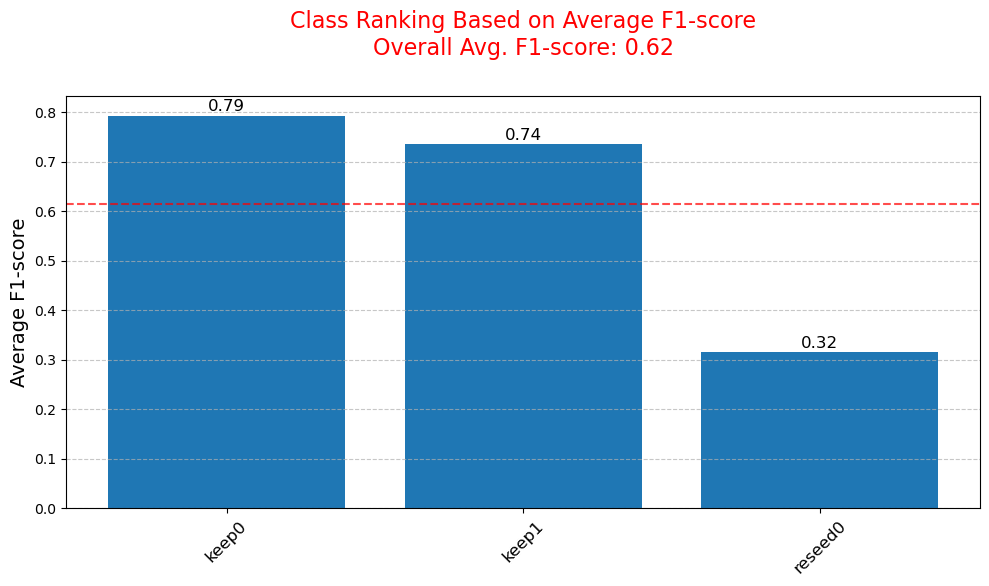

Training on fold 5/5
cuda
Epoch 1, Train Loss: 1.2193856571995936, Validation Loss: 0.9377869963645935, Accuracy: 41.42011834319526 %
Class 0 F1 Score: 0.5217391304347826
Class 1 F1 Score: 0.41304347826086957
Class 2 F1 Score: 0.2117647058823529
Epoch 2, Train Loss: 0.9142187473385833, Validation Loss: 0.8491982420285543, Accuracy: 50.29585798816568 %
Class 0 F1 Score: 0.4689655172413793
Class 1 F1 Score: 0.5850340136054422
Class 2 F1 Score: 0.34782608695652173
Epoch 3, Train Loss: 0.8454420386358749, Validation Loss: 0.8433675169944763, Accuracy: 51.4792899408284 %
Class 0 F1 Score: 0.4393939393939394
Class 1 F1 Score: 0.6369426751592356
Class 2 F1 Score: 0.326530612244898
Epoch 4, Train Loss: 0.8275894689005475, Validation Loss: 0.830313503742218, Accuracy: 49.70414201183432 %
Class 0 F1 Score: 0.48407643312101906
Class 1 F1 Score: 0.5833333333333334
Class 2 F1 Score: 0.21621621621621623
Epoch 5, Train Loss: 0.8333831554235414, Validation Loss: 0.8338092366854349, Accuracy: 45.562130

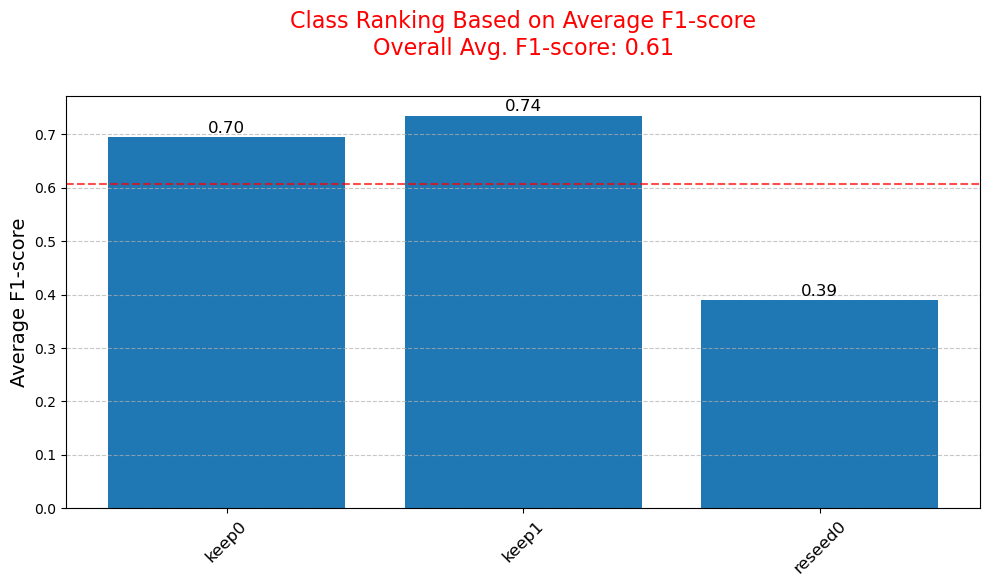

class_0_f1_score,▁▂▃▄▆▇▇▇▂▃▄▅▇▇▇▇▇█▃▇▅▇▆▇▇▃▄▆▇▇▆▄▃▃▇▆▇▇▆▆
class_1_f1_score,▁▄▅▆▇█▇█▆▆▆▆▅█▇█▇█▅▃▅▇▇▇▇▄▅▆▇▇█▃▆▅▅▅█▆▇▇
class_2_f1_score,▁▂▃▄▆▆▇▄▃▁▄▅▆▅▆▅▄▆▄▅▃█▄▇▇▂▂▃▄▄▃▂▃▃▅▄▅▅▄▄
epoch,▁▁▂▃▄▄▅▆▁▂▃▄▄▅▆▇▇█▁▂▂▃▄▅▅▁▂▂▃▄▅▁▂▂▃▄▅▅▆▇
final_accuracy,▇█▄▄▁
fold,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆█████████
train_loss,█▅▅▄▃▃▂▂▆▅▄▃▃▃▃▂▁▁▆▅▃▃▃▂▁█▅▄▃▃▂█▅▅▄▃▃▂▂▁
val_accuracy,▁▃▄▅▇▇▇█▄▅▅▆▇▇▇▇▇█▄▆▅▇▆▇▇▄▄▅▇▇▆▃▄▄▆▆▇▇▆▆
val_loss,█▆▅▄▂▁▁▄▇█▄▃▂▂▂▂▅▂▆▄▃▁▂▃▁▆▅▅▄▄▄▆▅▅▂▃▂▂▄▃
class_0_f1_score,0.69565
class_1_f1_score,0.73529


Training on fold 1/5
cuda
Epoch 1, Train Loss: 1.3343154136524644, Validation Loss: 1.1462457776069641, Accuracy: 20.0 %
Class 0 F1 Score: 0.3787878787878788
Class 1 F1 Score: 0.0
Class 2 F1 Score: 0.12244897959183672
Epoch 2, Train Loss: 1.0410326345022334, Validation Loss: 1.1482066909472148, Accuracy: 20.0 %
Class 0 F1 Score: 0.3064516129032258
Class 1 F1 Score: 0.1686746987951807
Class 2 F1 Score: 0.12030075187969924
Epoch 3, Train Loss: 0.9689810276031494, Validation Loss: 0.9361756245295206, Accuracy: 47.64705882352941 %
Class 0 F1 Score: 0.6729857819905213
Class 1 F1 Score: 0.13888888888888887
Class 2 F1 Score: 0.1754385964912281
Epoch 4, Train Loss: 0.8431450766186381, Validation Loss: 0.8043098052342733, Accuracy: 57.64705882352941 %
Class 0 F1 Score: 0.6602870813397128
Class 1 F1 Score: 0.45652173913043476
Class 2 F1 Score: 0.41025641025641024
Epoch 5, Train Loss: 0.7661596411882445, Validation Loss: 0.7906413674354553, Accuracy: 50.0 %
Class 0 F1 Score: 0.3333333333333333
Cl

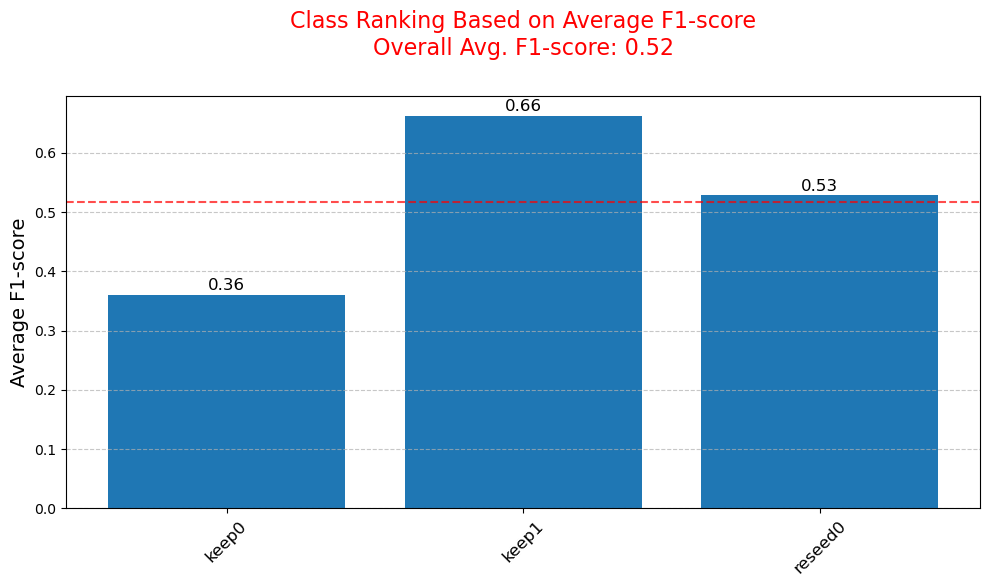

Training on fold 2/5
cuda
Epoch 1, Train Loss: 1.2913386239561924, Validation Loss: 1.06197456518809, Accuracy: 48.8235294117647 %
Class 0 F1 Score: 0.41221374045801523
Class 1 F1 Score: 0.5628140703517588
Class 2 F1 Score: 0.0
Epoch 2, Train Loss: 1.0241765199705612, Validation Loss: 1.0243772268295288, Accuracy: 25.294117647058822 %
Class 0 F1 Score: 0.32786885245901637
Class 1 F1 Score: 0.3466666666666666
Class 2 F1 Score: 0.13986013986013984
Epoch 3, Train Loss: 0.8876323131627815, Validation Loss: 0.7948618133862814, Accuracy: 49.411764705882355 %
Class 0 F1 Score: 0.6607929515418502
Class 1 F1 Score: 0.0
Class 2 F1 Score: 0.339622641509434
Epoch 4, Train Loss: 0.8176717695801757, Validation Loss: 0.8326207598050436, Accuracy: 54.705882352941174 %
Class 0 F1 Score: 0.4427480916030534
Class 1 F1 Score: 0.6338797814207651
Class 2 F1 Score: 0.4615384615384615
Epoch 5, Train Loss: 0.7439424541107443, Validation Loss: 0.9388368129730225, Accuracy: 48.23529411764706 %
Class 0 F1 Score: 

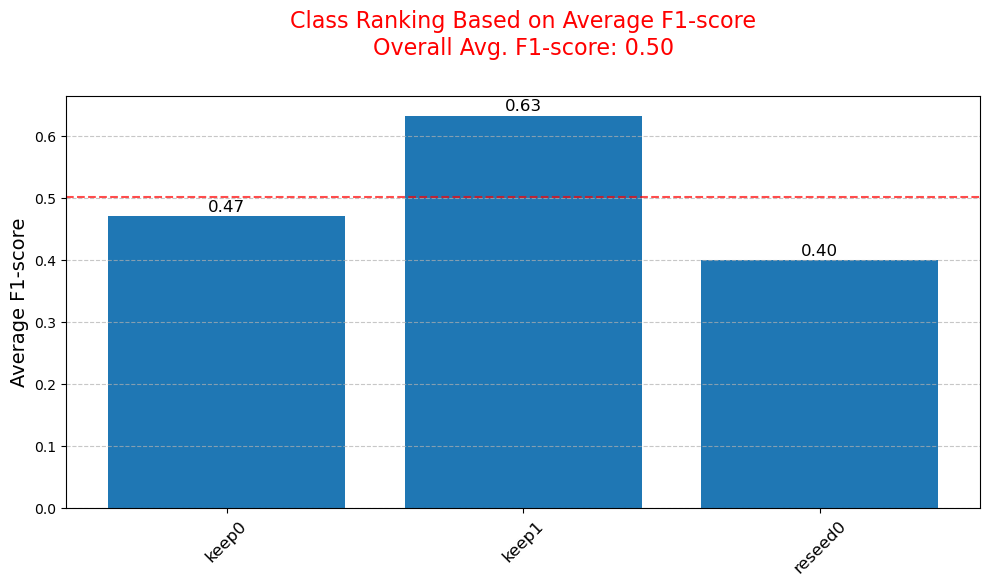

Training on fold 3/5
cuda
Epoch 1, Train Loss: 1.2250387557717257, Validation Loss: 1.067162036895752, Accuracy: 28.823529411764707 %
Class 0 F1 Score: 0.45714285714285713
Class 1 F1 Score: 0.19444444444444445
Class 2 F1 Score: 0.15625
Epoch 2, Train Loss: 0.9662885638170464, Validation Loss: 0.8318116267522176, Accuracy: 51.76470588235294 %
Class 0 F1 Score: 0.49382716049382713
Class 1 F1 Score: 0.562874251497006
Class 2 F1 Score: 0.18181818181818182
Epoch 3, Train Loss: 0.8320780729138574, Validation Loss: 0.6893023649851481, Accuracy: 58.8235294117647 %
Class 0 F1 Score: 0.6436781609195402
Class 1 F1 Score: 0.5483870967741935
Class 2 F1 Score: 0.47619047619047616
Epoch 4, Train Loss: 0.779017930113992, Validation Loss: 0.7966063817342123, Accuracy: 47.05882352941177 %
Class 0 F1 Score: 0.41830065359477125
Class 1 F1 Score: 0.5394736842105263
Class 2 F1 Score: 0.4
Epoch 5, Train Loss: 0.8374666834986487, Validation Loss: 0.7314162850379944, Accuracy: 54.705882352941174 %
Class 0 F1 S

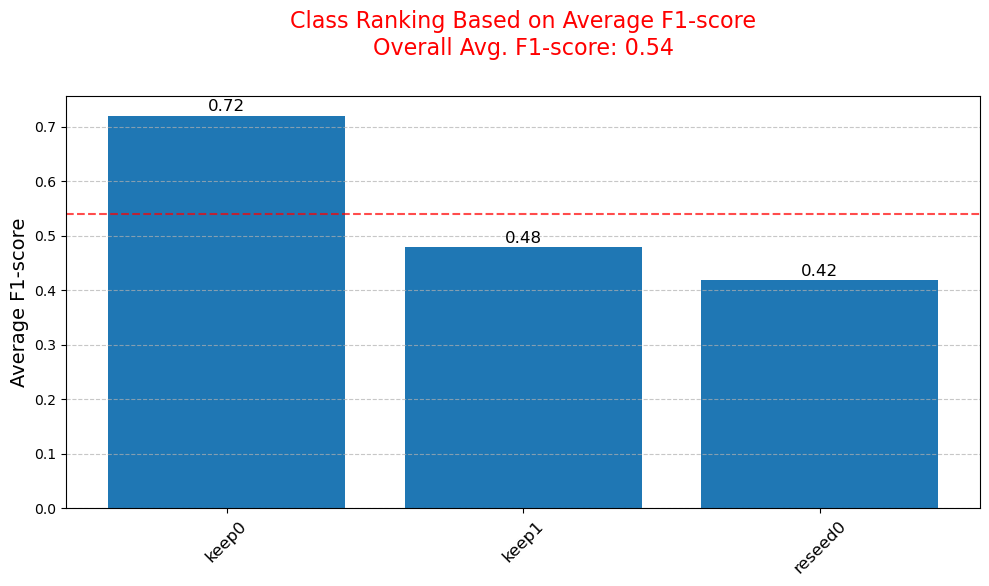

Training on fold 4/5
cuda
Epoch 1, Train Loss: 1.2814567366311715, Validation Loss: 1.0552199880282085, Accuracy: 25.443786982248522 %
Class 0 F1 Score: 0.4533333333333334
Class 1 F1 Score: 0.0
Class 2 F1 Score: 0.140625
Epoch 2, Train Loss: 0.994862690914509, Validation Loss: 0.9780114889144897, Accuracy: 31.952662721893493 %
Class 0 F1 Score: 0.366412213740458
Class 1 F1 Score: 0.4356435643564356
Class 2 F1 Score: 0.15094339622641506
Epoch 3, Train Loss: 0.8382682467615882, Validation Loss: 0.8420041799545288, Accuracy: 46.15384615384615 %
Class 0 F1 Score: 0.35772357723577236
Class 1 F1 Score: 0.5925925925925927
Class 2 F1 Score: 0.3018867924528302
Epoch 4, Train Loss: 0.7960715986961542, Validation Loss: 0.7985545595486959, Accuracy: 50.887573964497044 %
Class 0 F1 Score: 0.41269841269841273
Class 1 F1 Score: 0.6265060240963856
Class 2 F1 Score: 0.34782608695652173
Epoch 5, Train Loss: 0.7180896034074384, Validation Loss: 0.7821487188339233, Accuracy: 59.76331360946745 %
Class 0 F1

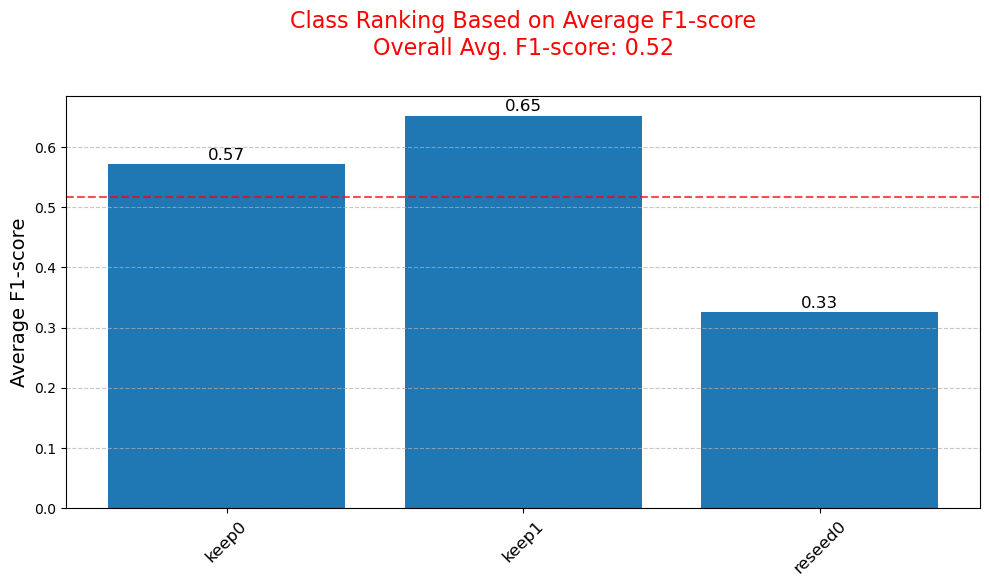

Training on fold 5/5
cuda
Epoch 1, Train Loss: 1.4307491848635119, Validation Loss: 1.033639629681905, Accuracy: 28.994082840236686 %
Class 0 F1 Score: 0.47297297297297297
Class 1 F1 Score: 0.14492753623188404
Class 2 F1 Score: 0.14876033057851243
Epoch 2, Train Loss: 1.070401364980742, Validation Loss: 1.0123178164164226, Accuracy: 53.84615384615385 %
Class 0 F1 Score: 0.47328244274809156
Class 1 F1 Score: 0.6060606060606061
Class 2 F1 Score: 0.0
Epoch 3, Train Loss: 0.9227845807408177, Validation Loss: 0.8167804678281149, Accuracy: 45.562130177514796 %
Class 0 F1 Score: 0.37593984962406013
Class 1 F1 Score: 0.5733333333333334
Class 2 F1 Score: 0.32727272727272727
Epoch 4, Train Loss: 0.7624960361525069, Validation Loss: 0.7975385189056396, Accuracy: 51.4792899408284 %
Class 0 F1 Score: 0.5200000000000001
Class 1 F1 Score: 0.5864661654135339
Class 2 F1 Score: 0.32727272727272727
Epoch 5, Train Loss: 0.7050774866758391, Validation Loss: 0.8470588127772013, Accuracy: 49.70414201183432 %

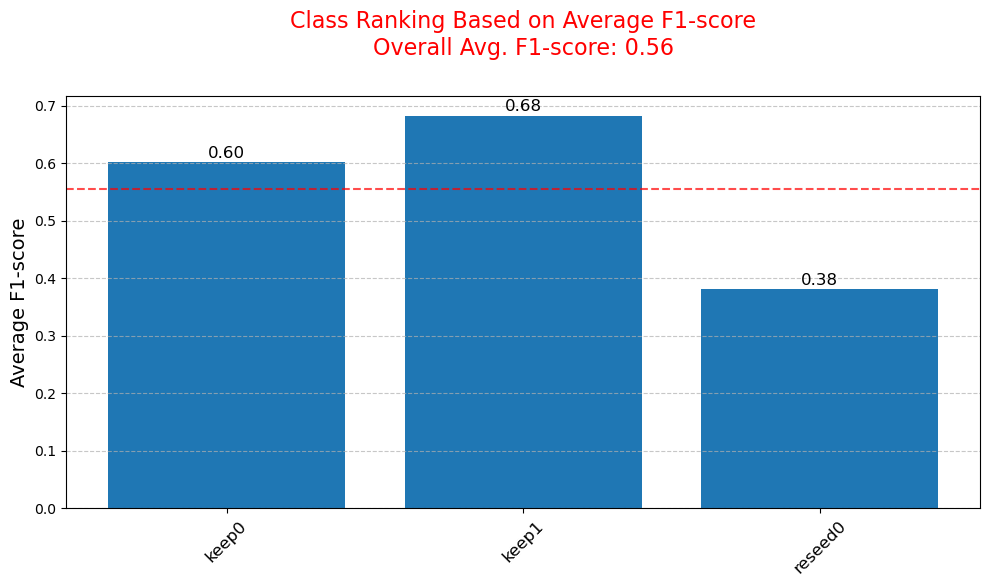

class_0_f1_score,▂▇▂▁▃▄▂▁▃▃▃▄▃▃▆▇▆▄▃▂▇▆▅█▃▅▂▄▇▂▄▃▄█▇▇▇▅▇▆
class_1_f1_score,▁▂▇▇▇██▅▇███▃▇▆▆▇▇▁▇▅▇████▇▇▅▇██▇▃▇▇████
class_2_f1_score,▁▂▆▅▄▅▅▁▄▆▆▆▁▄▃▆█▅▁▃▃▄▄▅▃▃▃▂▃▃▅▄▅▄▅▄▆▆▆▄
epoch,▁▁▂▂▃▃▄▁▂▂▃▃▁▁▂▃▃▃▁▁▂▂▃▃▄▅▁▂▂▃▃▄▄▅▅▆▆▇▇█
final_accuracy,▁▂▇▄█
fold,▁▁▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆██████████████
train_loss,█▅▄▃▂▂▂▆▄▃▃▂▇▄▄▄▂▂▂▅▃▃▂▂▃▂▆▄▃▄▃▃▃▂▂▂▂▂▁▁
val_accuracy,▁▅▅▅▅▆▆▂▆▆▆▆▂▅▆▇▇▆▂▅▆▇▆█▆▆▅▅▆▅▆▆▆▆▇▇█▇█▇
val_loss,█▆▄▄▃▃▄▇▄▃▄▃▇▄▃▂▁▂▇▅▄▄▄▃▅▅▄▅▄▄▃▃▂▃▁▃▁▂▁▄
class_0_f1_score,0.60131
class_1_f1_score,0.68293


Training on fold 1/5


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


cuda
Epoch 1, Train Loss: 0.7177687781613048, Validation Loss: 1.163155863682429, Accuracy: 49.079754601226995 %
Class 0 F1 Score: 0.5951219512195122
Class 1 F1 Score: 0.0
Class 2 F1 Score: 0.5066666666666666
Epoch 2, Train Loss: 0.4143552881915395, Validation Loss: 0.6934172113736471, Accuracy: 74.84662576687117 %
Class 0 F1 Score: 0.7647058823529411
Class 1 F1 Score: 0.6086956521739131
Class 2 F1 Score: 0.8571428571428571
Epoch 3, Train Loss: 0.33328413781596394, Validation Loss: 0.560950600852569, Accuracy: 73.00613496932516 %
Class 0 F1 Score: 0.7142857142857143
Class 1 F1 Score: 0.48387096774193544
Class 2 F1 Score: 0.8709677419354839
Epoch 4, Train Loss: 0.2639191779421597, Validation Loss: 0.7828334172566732, Accuracy: 73.61963190184049 %
Class 0 F1 Score: 0.689655172413793
Class 1 F1 Score: 0.6846846846846848
Class 2 F1 Score: 0.8484848484848485
Epoch 5, Train Loss: 0.17760903533638978, Validation Loss: 0.40098676085472107, Accuracy: 81.59509202453988 %
Class 0 F1 Score: 0.7656

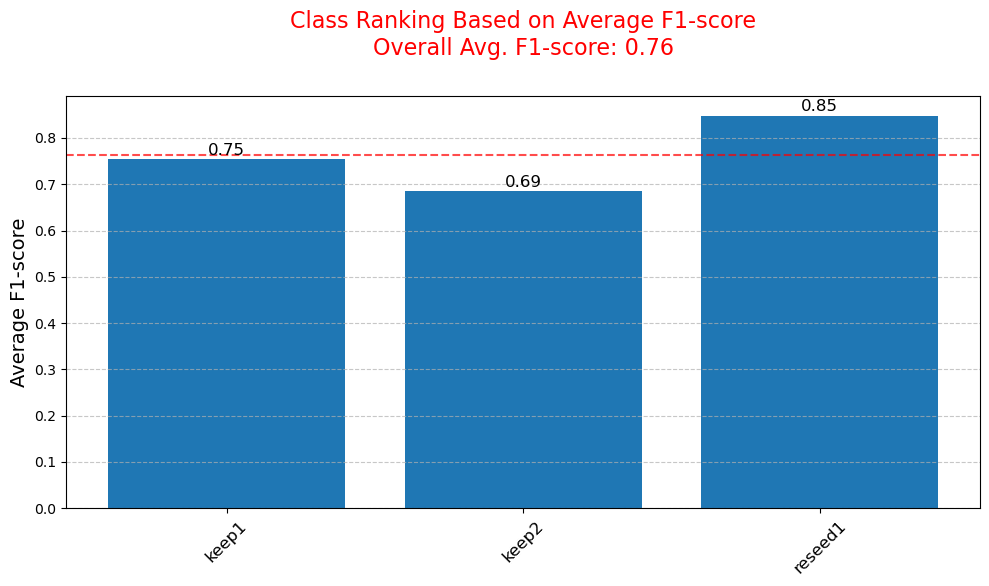

Training on fold 2/5


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


cuda
Epoch 1, Train Loss: 0.7234376363637971, Validation Loss: 1.6151653329531352, Accuracy: 49.693251533742334 %
Class 0 F1 Score: 0.6242774566473989
Class 1 F1 Score: 0.4666666666666666
Class 2 F1 Score: 0.1904761904761905
Epoch 2, Train Loss: 0.4317247057106437, Validation Loss: 0.3937336206436157, Accuracy: 83.43558282208589 %
Class 0 F1 Score: 0.7787610619469026
Class 1 F1 Score: 0.7924528301886793
Class 2 F1 Score: 0.9345794392523363
Epoch 3, Train Loss: 0.34120236409873494, Validation Loss: 0.34927236040433246, Accuracy: 83.43558282208589 %
Class 0 F1 Score: 0.7719298245614035
Class 1 F1 Score: 0.78
Class 2 F1 Score: 0.9464285714285715
Epoch 4, Train Loss: 0.30060306772953127, Validation Loss: 0.4668984282761812, Accuracy: 74.84662576687117 %
Class 0 F1 Score: 0.6262626262626263
Class 1 F1 Score: 0.7692307692307693
Class 2 F1 Score: 0.8235294117647058
Epoch 5, Train Loss: 0.2586955715243409, Validation Loss: 0.3891651928424835, Accuracy: 80.3680981595092 %
Class 0 F1 Score: 0.77

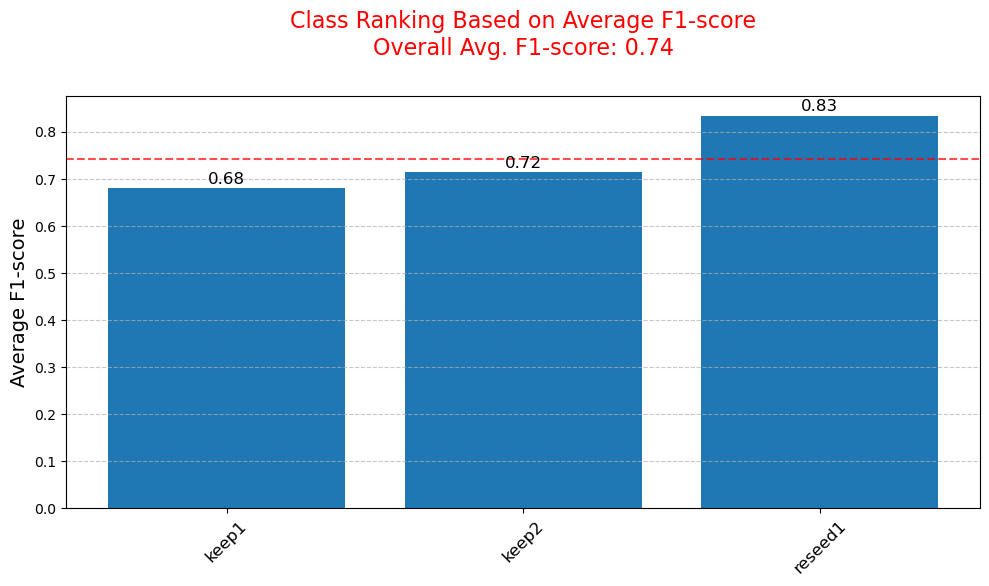

Training on fold 3/5


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


cuda
Epoch 1, Train Loss: 0.7420803860920232, Validation Loss: 1.512529194355011, Accuracy: 45.39877300613497 %
Class 0 F1 Score: 0.631578947368421
Class 1 F1 Score: 0.33766233766233766
Class 2 F1 Score: 0.033898305084745756
Epoch 2, Train Loss: 0.43360978001501504, Validation Loss: 0.421822785710295, Accuracy: 85.88957055214723 %
Class 0 F1 Score: 0.8135593220338982
Class 1 F1 Score: 0.8172043010752688
Class 2 F1 Score: 0.9391304347826087
Epoch 3, Train Loss: 0.32608503902830727, Validation Loss: 0.4947172353665034, Accuracy: 80.98159509202453 %
Class 0 F1 Score: 0.7916666666666667
Class 1 F1 Score: 0.6933333333333332
Class 2 F1 Score: 0.9158878504672898
Epoch 4, Train Loss: 0.2713101353587174, Validation Loss: 0.6174832383791605, Accuracy: 74.84662576687117 %
Class 0 F1 Score: 0.6122448979591837
Class 1 F1 Score: 0.721311475409836
Class 2 F1 Score: 0.9056603773584905
Epoch 5, Train Loss: 0.24894086798516715, Validation Loss: 0.584691711080571, Accuracy: 77.91411042944786 %
Class 0 F1

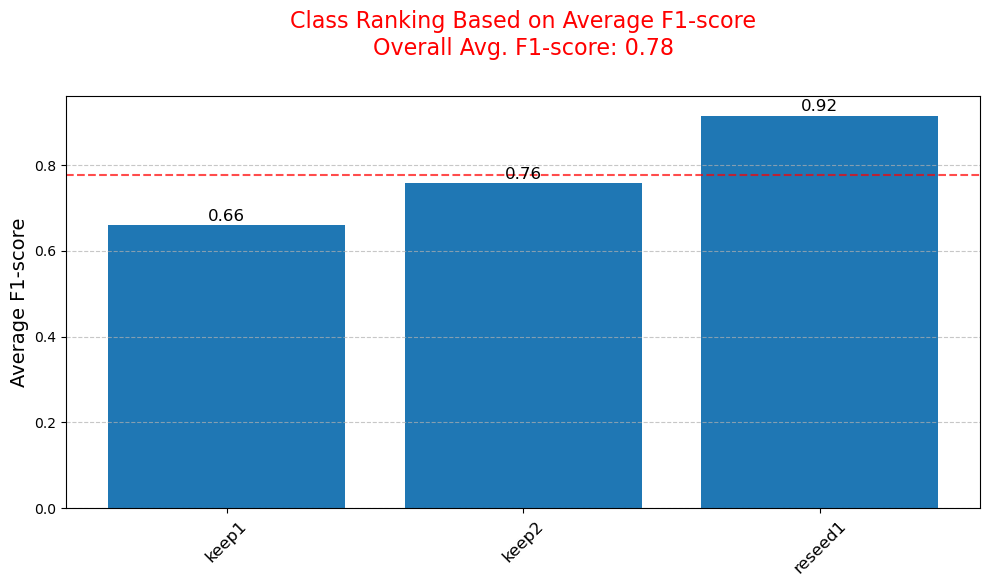

Training on fold 4/5


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


cuda
Epoch 1, Train Loss: 0.758957902832729, Validation Loss: 1.3043355743090312, Accuracy: 46.012269938650306 %
Class 0 F1 Score: 0.5769230769230769
Class 1 F1 Score: 0.0
Class 2 F1 Score: 0.4166666666666667
Epoch 2, Train Loss: 0.4237093002330966, Validation Loss: 0.5527677039305369, Accuracy: 75.4601226993865 %
Class 0 F1 Score: 0.7499999999999999
Class 1 F1 Score: 0.5846153846153846
Class 2 F1 Score: 0.8712871287128713
Epoch 3, Train Loss: 0.33678706717200396, Validation Loss: 0.4322333137194316, Accuracy: 84.04907975460122 %
Class 0 F1 Score: 0.793103448275862
Class 1 F1 Score: 0.8039215686274508
Class 2 F1 Score: 0.9259259259259259
Epoch 4, Train Loss: 0.25849992109508046, Validation Loss: 1.1186168988545735, Accuracy: 64.41717791411043 %
Class 0 F1 Score: 0.5416666666666666
Class 1 F1 Score: 0.6571428571428571
Class 2 F1 Score: 0.7333333333333334
Epoch 5, Train Loss: 0.24581708250249304, Validation Loss: 0.4756152927875519, Accuracy: 80.3680981595092 %
Class 0 F1 Score: 0.774647

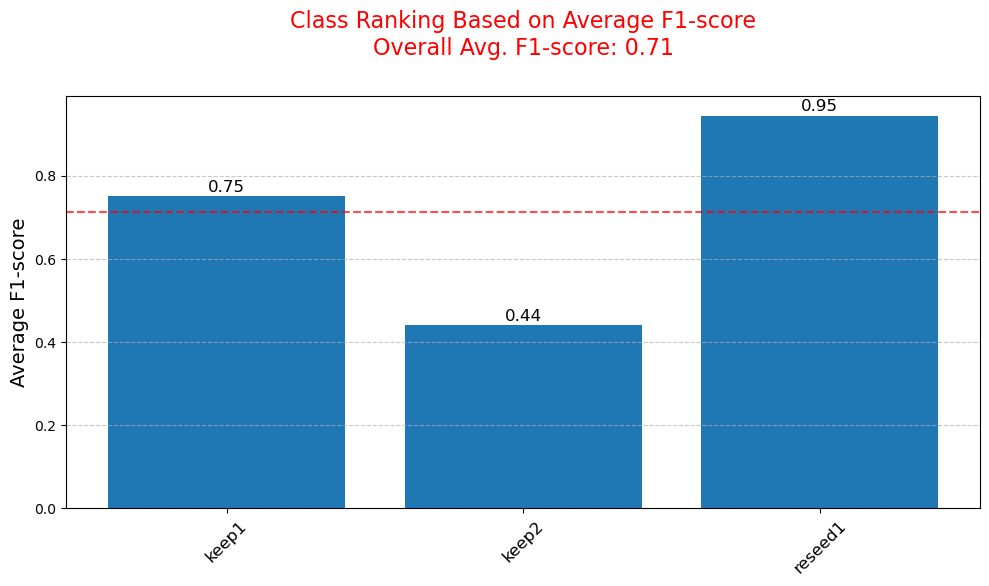

Training on fold 5/5


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


cuda
Epoch 1, Train Loss: 0.7479819844408733, Validation Loss: 1.291583647330602, Accuracy: 54.93827160493827 %
Class 0 F1 Score: 0.6153846153846154
Class 1 F1 Score: 0.5866666666666667
Class 2 F1 Score: 0.3283582089552239
Epoch 2, Train Loss: 0.42681174380023307, Validation Loss: 0.8550186355908712, Accuracy: 64.81481481481481 %
Class 0 F1 Score: 0.673076923076923
Class 1 F1 Score: 0.6074074074074074
Class 2 F1 Score: 0.6823529411764707
Epoch 3, Train Loss: 0.3094584334914277, Validation Loss: 0.3984877510617177, Accuracy: 79.01234567901234 %
Class 0 F1 Score: 0.7605633802816902
Class 1 F1 Score: 0.5970149253731344
Class 2 F1 Score: 0.9391304347826087
Epoch 4, Train Loss: 0.24159409487392844, Validation Loss: 0.29444490124781925, Accuracy: 86.41975308641975 %
Class 0 F1 Score: 0.8035714285714286
Class 1 F1 Score: 0.8155339805825242
Class 2 F1 Score: 0.9724770642201834
Epoch 5, Train Loss: 0.18510347713784472, Validation Loss: 0.5271062788863977, Accuracy: 81.48148148148148 %
Class 0 F

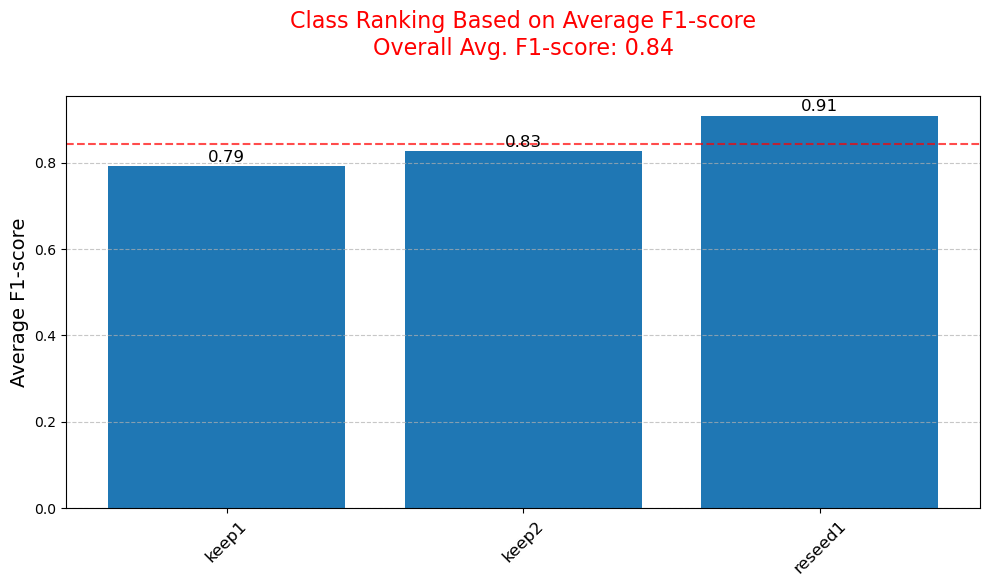

class_0_f1_score,▂▆▅▄▆▅▅▅▅▃▆▆▃▆▅▄▇▆▂▃▃▂▅▆▁▆▅▅▃▄▆▆▃▅▆▇▅▇█▆
class_1_f1_score,▁▆▅▇▇▄▄▆▇▅▇▇▇▆█▇█▇▇▇▇▁▆█▆▇▇▅▆▆▆█▆▇▆██▇██
class_2_f1_score,▄▇▇▇██▇█▇▁██▇▇█▇█▇▇▇▇▃▇▇▆▇▇█▂▅██▄███▇██▇
epoch,▁▂▂▃▃▄▄▅▆▁▂▂▃▄▄▅▂▂▃▃▄▁▂▂▃▃▄▄▁▂▂▃▄▄▅▅▆▆▇█
final_accuracy,▂▁▃▂█
fold,▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆████████████
train_loss,█▅▄▃▂▂▂▂▂█▅▄▃▃▂▂█▄▃▃▂▂█▄▃▃▂▂█▅▄▃▂▃▂▁▁▁▁▁
val_accuracy,▂▆▆▆▇▆▆▇▆▂▇▇▆▇▇▆▁█▇▆▆▁▆▇▄▇▇▆▃▄▇█▇▃▇▇█▇██
val_loss,▃▂▂▂▁▂▃▁▂▄▁▁▁▁▁▃▄▁▁▂▂▃▂▁▃▁▁▂▃▂▁▁▂█▁▁▁▁▁▁
class_0_f1_score,0.79279
class_1_f1_score,0.82609


Training on fold 1/5


The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.


cuda
Epoch 1, Train Loss: 0.5241280823219113, Validation Loss: 0.7783313592274984, Accuracy: 68.71165644171779 %
Class 0 F1 Score: 0.7577639751552795
Class 1 F1 Score: 0.410958904109589
Class 2 F1 Score: 0.782608695652174
Epoch 2, Train Loss: 0.3070020477582769, Validation Loss: 0.5826227565606436, Accuracy: 79.75460122699387 %
Class 0 F1 Score: 0.8032786885245902
Class 1 F1 Score: 0.7358490566037735
Class 2 F1 Score: 0.8571428571428571
Epoch 3, Train Loss: 0.21634703202218544, Validation Loss: 0.49196237822373706, Accuracy: 80.3680981595092 %
Class 0 F1 Score: 0.7894736842105262
Class 1 F1 Score: 0.5757575757575758
Class 2 F1 Score: 0.962962962962963
Epoch 4, Train Loss: 0.12865470277100075, Validation Loss: 0.7303740854064623, Accuracy: 78.52760736196319 %
Class 0 F1 Score: 0.6666666666666666
Class 1 F1 Score: 0.7256637168141593
Class 2 F1 Score: 0.9473684210526316
Epoch 5, Train Loss: 0.07649421637378089, Validation Loss: 0.5358066608508428, Accuracy: 82.20858895705521 %
Class 0 F1 

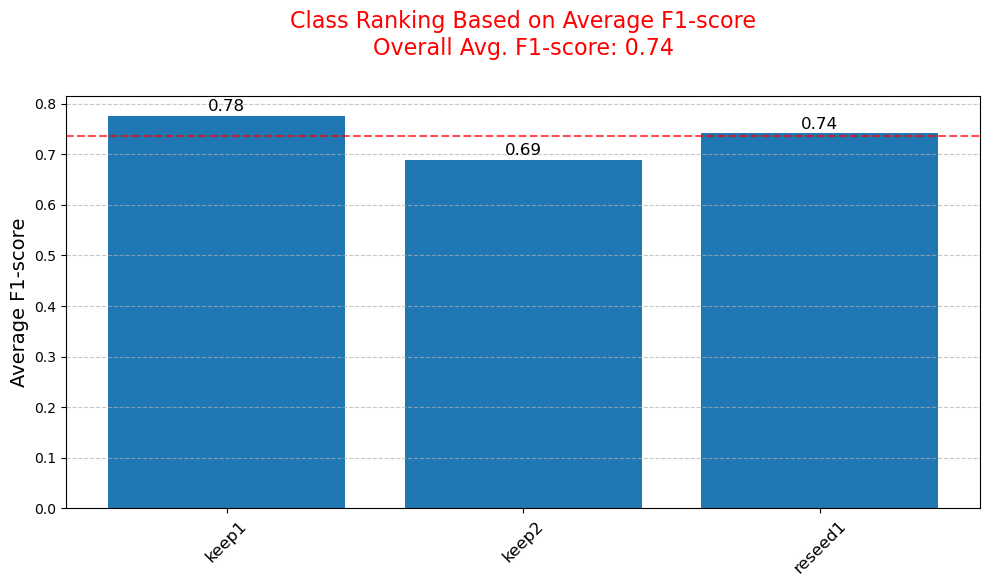

Training on fold 2/5


The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.


cuda
Epoch 1, Train Loss: 0.5404807954299741, Validation Loss: 0.48863930503527325, Accuracy: 82.20858895705521 %
Class 0 F1 Score: 0.7913669064748202
Class 1 F1 Score: 0.7710843373493975
Class 2 F1 Score: 0.9038461538461539
Epoch 2, Train Loss: 0.32883094142122965, Validation Loss: 0.45761007567246753, Accuracy: 82.20858895705521 %
Class 0 F1 Score: 0.8
Class 1 F1 Score: 0.7889908256880734
Class 2 F1 Score: 0.8823529411764706
Epoch 3, Train Loss: 0.25143878161907196, Validation Loss: 0.33623789995908737, Accuracy: 85.2760736196319 %
Class 0 F1 Score: 0.7850467289719626
Class 1 F1 Score: 0.8148148148148149
Class 2 F1 Score: 0.954954954954955
Epoch 4, Train Loss: 0.15121421635877796, Validation Loss: 0.2876564562320709, Accuracy: 87.11656441717791 %
Class 0 F1 Score: 0.8484848484848485
Class 1 F1 Score: 0.7951807228915664
Class 2 F1 Score: 0.954954954954955
Epoch 5, Train Loss: 0.07497740691391433, Validation Loss: 0.38131531079610187, Accuracy: 87.11656441717791 %
Class 0 F1 Score: 0.8

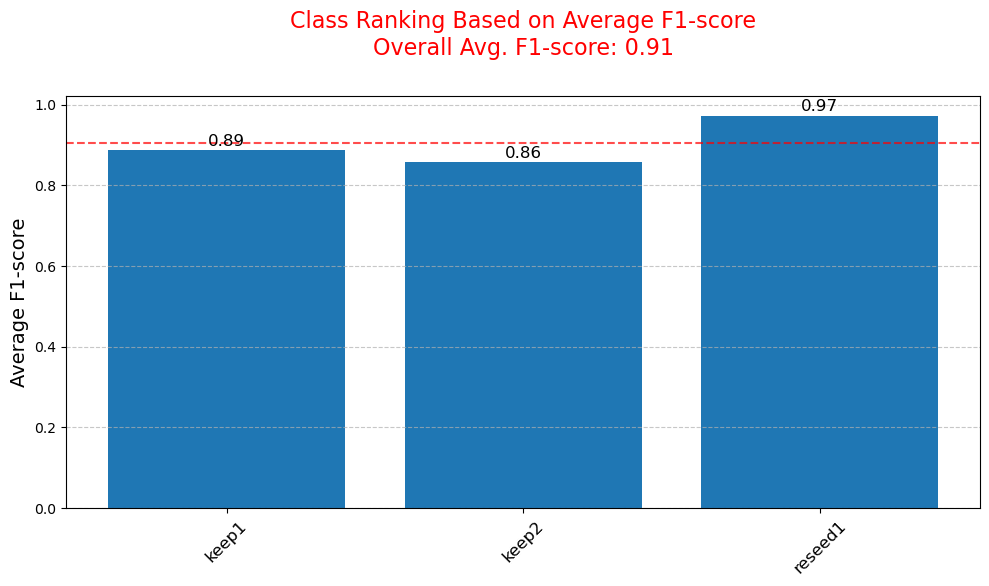

Training on fold 3/5


The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.


cuda
Epoch 1, Train Loss: 0.5007233023643494, Validation Loss: 0.5287496199210485, Accuracy: 76.68711656441718 %
Class 0 F1 Score: 0.7612903225806452
Class 1 F1 Score: 0.5757575757575758
Class 2 F1 Score: 0.8952380952380952
Epoch 2, Train Loss: 0.32019686916979345, Validation Loss: 0.39406682550907135, Accuracy: 83.43558282208589 %
Class 0 F1 Score: 0.7833333333333333
Class 1 F1 Score: 0.8200000000000001
Class 2 F1 Score: 0.9056603773584905
Epoch 3, Train Loss: 0.21445190252327337, Validation Loss: 0.3489053398370743, Accuracy: 85.2760736196319 %
Class 0 F1 Score: 0.8188976377952756
Class 1 F1 Score: 0.8260869565217391
Class 2 F1 Score: 0.9158878504672898
Epoch 4, Train Loss: 0.11880065564338754, Validation Loss: 0.39561527594923973, Accuracy: 85.88957055214723 %
Class 0 F1 Score: 0.8281250000000001
Class 1 F1 Score: 0.775
Class 2 F1 Score: 0.9491525423728813
Epoch 5, Train Loss: 0.05855333382581792, Validation Loss: 0.5003553877274195, Accuracy: 84.66257668711657 %
Class 0 F1 Score: 0

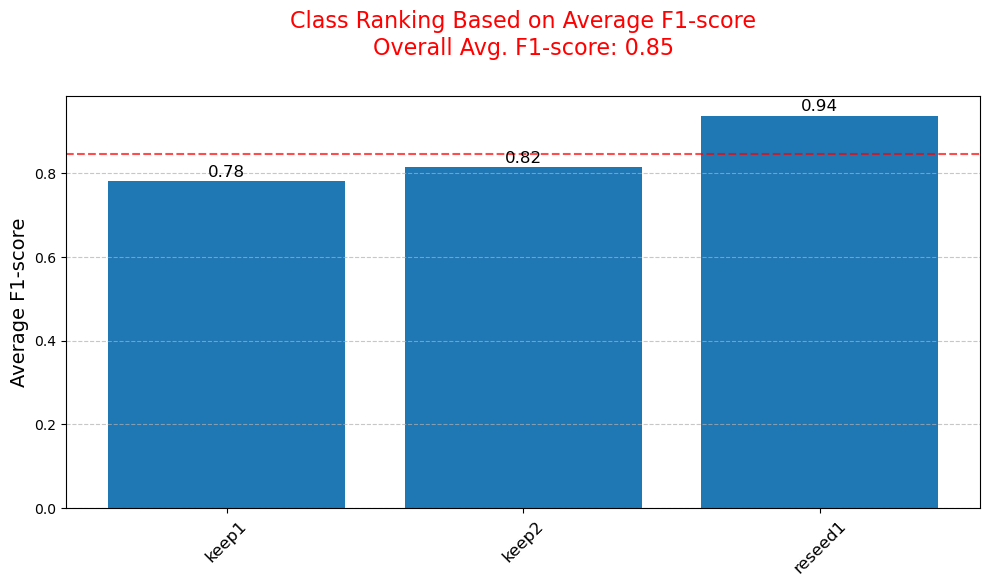

Training on fold 4/5


The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.


cuda
Epoch 1, Train Loss: 0.5323927264388014, Validation Loss: 0.6706811438004175, Accuracy: 69.93865030674847 %
Class 0 F1 Score: 0.7100591715976332
Class 1 F1 Score: 0.3859649122807018
Class 2 F1 Score: 0.86
Epoch 2, Train Loss: 0.3228269673702193, Validation Loss: 0.4580030341943105, Accuracy: 82.82208588957056 %
Class 0 F1 Score: 0.7768595041322314
Class 1 F1 Score: 0.8235294117647057
Class 2 F1 Score: 0.8932038834951457
Epoch 3, Train Loss: 0.22795045884644113, Validation Loss: 0.537472794453303, Accuracy: 84.66257668711657 %
Class 0 F1 Score: 0.8260869565217392
Class 1 F1 Score: 0.8235294117647058
Class 2 F1 Score: 0.8932038834951457
Epoch 4, Train Loss: 0.13851221887076773, Validation Loss: 0.46798600753148395, Accuracy: 85.2760736196319 %
Class 0 F1 Score: 0.8188976377952756
Class 1 F1 Score: 0.8222222222222223
Class 2 F1 Score: 0.9174311926605504
Epoch 5, Train Loss: 0.058517456463560824, Validation Loss: 0.7387122313181559, Accuracy: 76.07361963190183 %
Class 0 F1 Score: 0.74

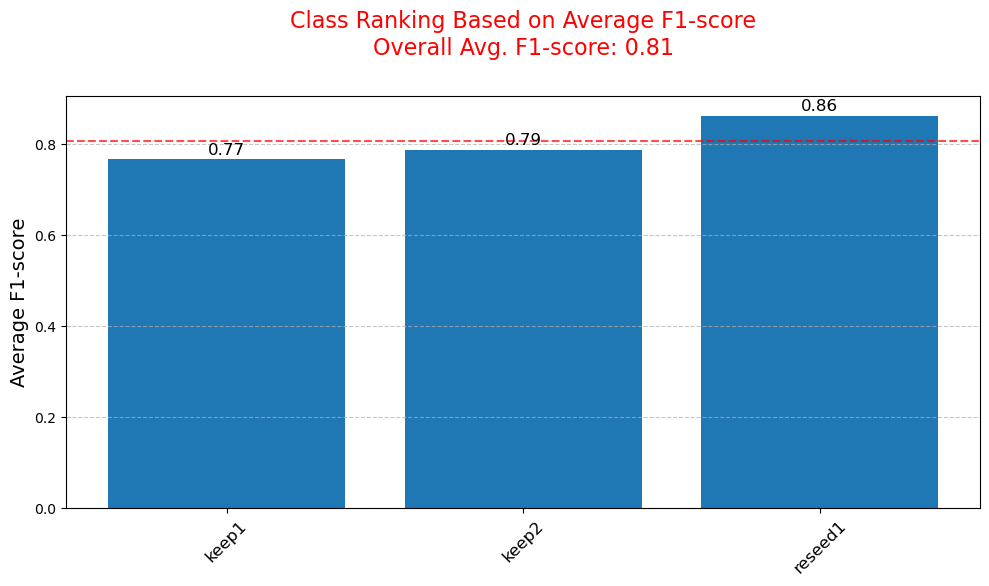

Training on fold 5/5


The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.


cuda
Epoch 1, Train Loss: 0.5366278021800809, Validation Loss: 0.7628217538197836, Accuracy: 66.66666666666667 %
Class 0 F1 Score: 0.780821917808219
Class 1 F1 Score: 0.6213592233009708
Class 2 F1 Score: 0.5066666666666666
Epoch 2, Train Loss: 0.3186056464910507, Validation Loss: 0.32058205145100754, Accuracy: 87.03703703703704 %
Class 0 F1 Score: 0.8396946564885496
Class 1 F1 Score: 0.7948717948717949
Class 2 F1 Score: 0.9565217391304348
Epoch 3, Train Loss: 0.23275762069516065, Validation Loss: 0.30412305022279423, Accuracy: 86.41975308641975 %
Class 0 F1 Score: 0.8
Class 1 F1 Score: 0.8118811881188119
Class 2 F1 Score: 0.9734513274336283
Epoch 4, Train Loss: 0.15402586240230537, Validation Loss: 0.36987099222217995, Accuracy: 85.18518518518519 %
Class 0 F1 Score: 0.793103448275862
Class 1 F1 Score: 0.8604651162790697
Class 2 F1 Score: 0.9016393442622951
Epoch 5, Train Loss: 0.07055588643543603, Validation Loss: 0.2980562150478363, Accuracy: 89.50617283950618 %
Class 0 F1 Score: 0.86

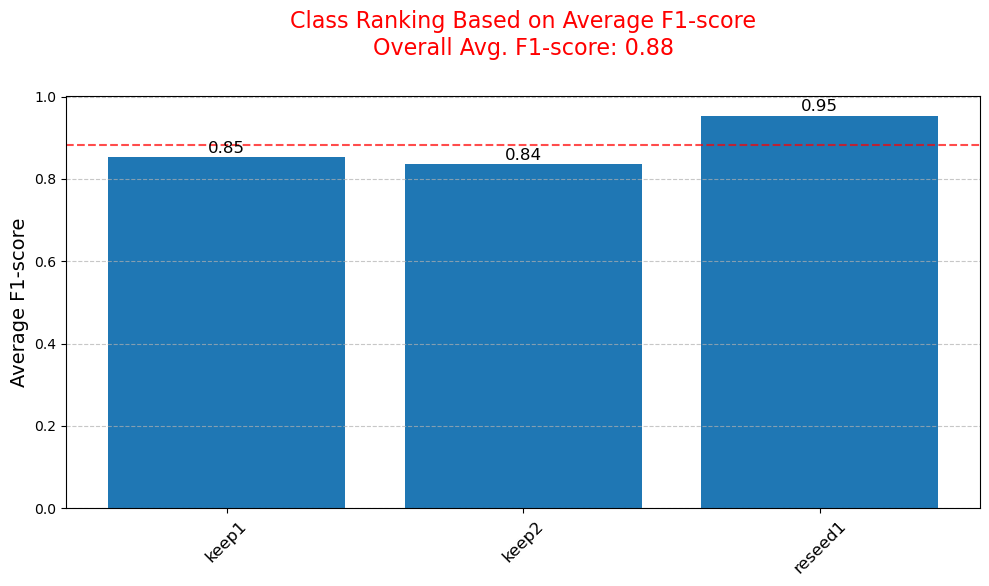

class_0_f1_score,▃▅▄▃▅▆▅▅▄▆▄▄▄▆▆▆▇▆▅▇▇███▄▅▆▅▄▄▆▅▃▄▆▄▇▂▁▇
class_1_f1_score,▄▇▆▇▇▇▇▇▆▇▇▇█▇▇▇█▇▇███████▇▇████▇▆▇██▁██
class_2_f1_score,▅▆████████▄▇███▇████████▇▇▇▇▇▇▇▇▆▁█▇█▅▇█
epoch,▁▁▂▃▃▄▅▅▆▆▇▁▂▂▃▄▅▅▅▆▇██▁▁▂▃▄▄▁▂▃▃▁▁▂▃▄▄▅
final_accuracy,▁█▅▄▇
fold,▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆███████
train_loss,█▅▄▂▂▁▁▁▁▁▁▅▄▂▂▁▁▁▁▁▁▁▁█▄▃▁▁▁▅▄▂▁█▅▃▂▂▁▁
val_accuracy,▂▅▅▆▇▇▆▆▅▇▃▆▆▇▇▆▇▇▆▇████▆▆▇▆▆▂▆▆▄▁▇▇█▁▇▇
val_loss,▅▃▃▃▂▂▄▂▄▃█▃▂▁▂▂▁▂▂▂▁▁▁▁▂▂▂▃▃▄▃▃▅▅▁▁▁▇▂▂
class_0_f1_score,0.85271
class_1_f1_score,0.83721


Training on fold 1/5
cuda
Epoch 1, Train Loss: 1.1231374159091856, Validation Loss: 0.7693169911702474, Accuracy: 69.32515337423312 %
Class 0 F1 Score: 0.6306306306306306
Class 1 F1 Score: 0.6138613861386139
Class 2 F1 Score: 0.8245614035087718
Epoch 2, Train Loss: 0.7109525167360539, Validation Loss: 0.5220310489336649, Accuracy: 74.23312883435582 %
Class 0 F1 Score: 0.703125
Class 1 F1 Score: 0.5842696629213482
Class 2 F1 Score: 0.9174311926605505
Epoch 3, Train Loss: 0.5797592728603177, Validation Loss: 0.4669221689303716, Accuracy: 79.14110429447852 %
Class 0 F1 Score: 0.7866666666666665
Class 1 F1 Score: 0.6
Class 2 F1 Score: 0.9245283018867924
Epoch 4, Train Loss: 0.490446298587613, Validation Loss: 0.45293277502059937, Accuracy: 74.84662576687117 %
Class 0 F1 Score: 0.6605504587155964
Class 1 F1 Score: 0.673076923076923
Class 2 F1 Score: 0.9026548672566371
Epoch 5, Train Loss: 0.4604384470276716, Validation Loss: 0.5463540541628996, Accuracy: 71.77914110429448 %
Class 0 F1 Score

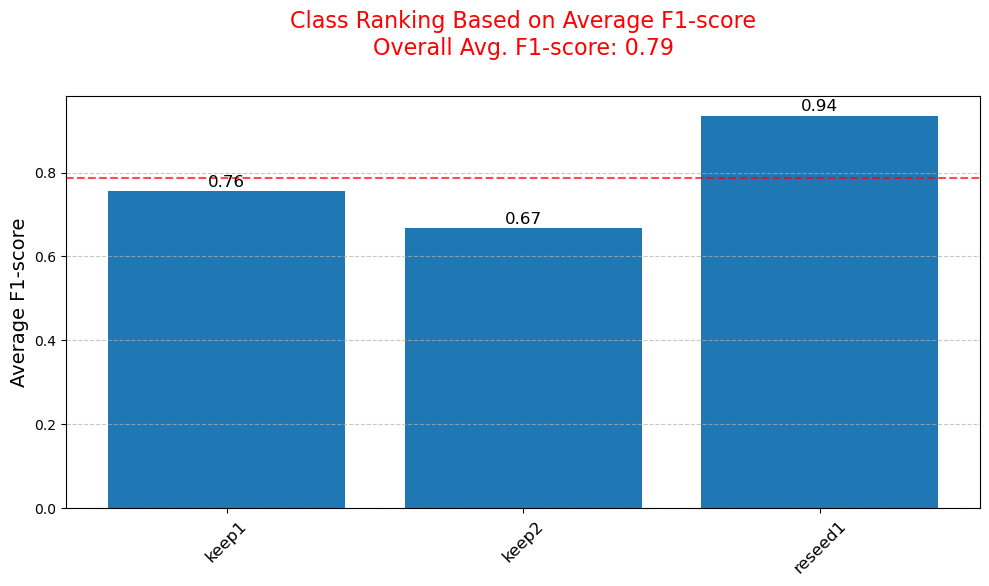

Training on fold 2/5
cuda
Epoch 1, Train Loss: 0.967628183888226, Validation Loss: 0.6763178408145905, Accuracy: 67.48466257668711 %
Class 0 F1 Score: 0.6851851851851851
Class 1 F1 Score: 0.5238095238095238
Class 2 F1 Score: 0.7611940298507462
Epoch 2, Train Loss: 0.6526754062350203, Validation Loss: 0.6063242157300314, Accuracy: 71.16564417177914 %
Class 0 F1 Score: 0.6336633663366336
Class 1 F1 Score: 0.6236559139784946
Class 2 F1 Score: 0.8333333333333333
Epoch 3, Train Loss: 0.5785280204400783, Validation Loss: 0.4510079671939214, Accuracy: 80.3680981595092 %
Class 0 F1 Score: 0.7751937984496124
Class 1 F1 Score: 0.6829268292682927
Class 2 F1 Score: 0.9217391304347825
Epoch 4, Train Loss: 0.516144383971284, Validation Loss: 0.5403807461261749, Accuracy: 80.3680981595092 %
Class 0 F1 Score: 0.7454545454545455
Class 1 F1 Score: 0.7522935779816514
Class 2 F1 Score: 0.9158878504672898
Epoch 5, Train Loss: 0.49278822177793924, Validation Loss: 0.4472853938738505, Accuracy: 79.7546012269

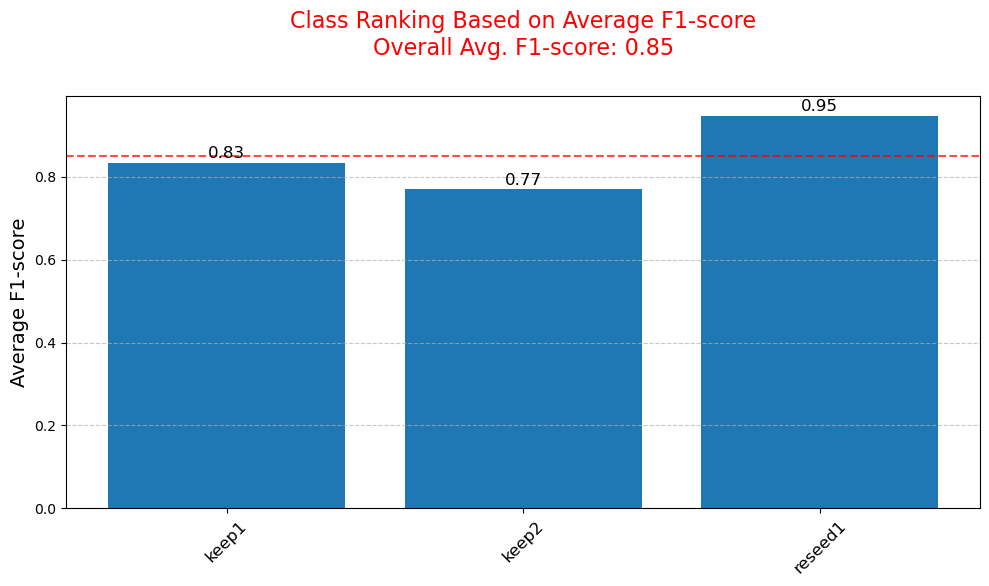

Training on fold 3/5
cuda
Epoch 1, Train Loss: 1.1122134356963924, Validation Loss: 0.8453712860743204, Accuracy: 58.282208588957054 %
Class 0 F1 Score: 0.6166666666666667
Class 1 F1 Score: 0.4821428571428572
Class 2 F1 Score: 0.6595744680851063
Epoch 2, Train Loss: 0.7405669340273229, Validation Loss: 0.5926061272621155, Accuracy: 74.84662576687117 %
Class 0 F1 Score: 0.7323943661971831
Class 1 F1 Score: 0.5822784810126582
Class 2 F1 Score: 0.8952380952380952
Epoch 3, Train Loss: 0.6231851926664027, Validation Loss: 0.5142797430356344, Accuracy: 76.68711656441718 %
Class 0 F1 Score: 0.7218045112781954
Class 1 F1 Score: 0.6341463414634146
Class 2 F1 Score: 0.918918918918919
Epoch 4, Train Loss: 0.5390612933693862, Validation Loss: 0.4714636728167534, Accuracy: 75.4601226993865 %
Class 0 F1 Score: 0.7031250000000001
Class 1 F1 Score: 0.6363636363636365
Class 2 F1 Score: 0.9090909090909091
Epoch 5, Train Loss: 0.5031644709226561, Validation Loss: 0.44617117444674176, Accuracy: 77.9141104

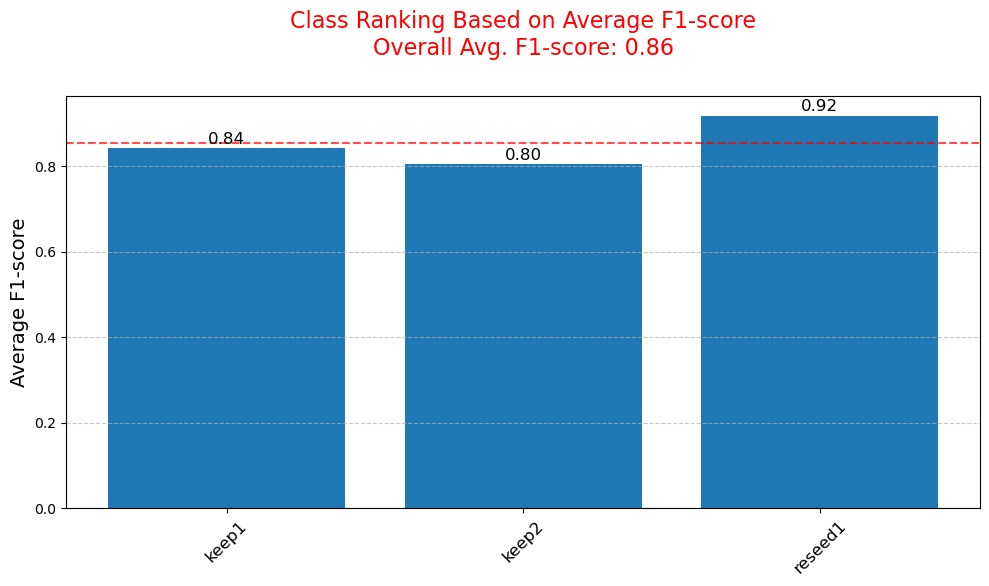

Training on fold 4/5
cuda
Epoch 1, Train Loss: 1.1475540137872464, Validation Loss: 0.7598666350046793, Accuracy: 63.190184049079754 %
Class 0 F1 Score: 0.6808510638297872
Class 1 F1 Score: 0.3548387096774194
Class 2 F1 Score: 0.7154471544715446
Epoch 2, Train Loss: 0.7036366506320674, Validation Loss: 0.7185379366079966, Accuracy: 69.93865030674847 %
Class 0 F1 Score: 0.7204968944099379
Class 1 F1 Score: 0.5217391304347826
Class 2 F1 Score: 0.7916666666666666
Epoch 3, Train Loss: 0.6026866930287059, Validation Loss: 0.5362612207730612, Accuracy: 78.52760736196319 %
Class 0 F1 Score: 0.7500000000000001
Class 1 F1 Score: 0.7272727272727272
Class 2 F1 Score: 0.8727272727272727
Epoch 4, Train Loss: 0.5159118473529816, Validation Loss: 0.6460194786389669, Accuracy: 65.6441717791411 %
Class 0 F1 Score: 0.4651162790697674
Class 1 F1 Score: 0.6376811594202898
Class 2 F1 Score: 0.8431372549019609
Epoch 5, Train Loss: 0.4794858577774792, Validation Loss: 0.43514607350031537, Accuracy: 79.141104

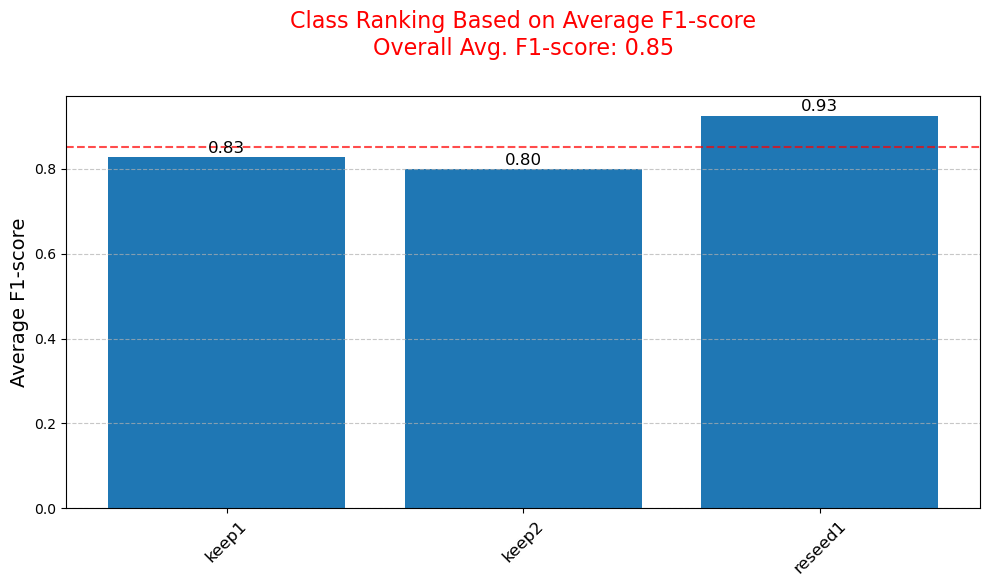

Training on fold 5/5
cuda
Epoch 1, Train Loss: 1.0415655810658524, Validation Loss: 0.7031246225039164, Accuracy: 69.75308641975309 %
Class 0 F1 Score: 0.711864406779661
Class 1 F1 Score: 0.5319148936170214
Class 2 F1 Score: 0.8214285714285714
Epoch 2, Train Loss: 0.715046837562468, Validation Loss: 0.5609124054511389, Accuracy: 70.37037037037037 %
Class 0 F1 Score: 0.7166666666666667
Class 1 F1 Score: 0.4722222222222222
Class 2 F1 Score: 0.8181818181818182
Epoch 3, Train Loss: 0.6111337651566762, Validation Loss: 0.4256403123339017, Accuracy: 82.09876543209876 %
Class 0 F1 Score: 0.78125
Class 1 F1 Score: 0.746987951807229
Class 2 F1 Score: 0.9203539823008849
Epoch 4, Train Loss: 0.5106847464311414, Validation Loss: 0.3599020764231682, Accuracy: 82.09876543209876 %
Class 0 F1 Score: 0.7716535433070867
Class 1 F1 Score: 0.761904761904762
Class 2 F1 Score: 0.9203539823008849
Epoch 5, Train Loss: 0.46107371478545955, Validation Loss: 0.36933047076066333, Accuracy: 84.5679012345679 %
Clas

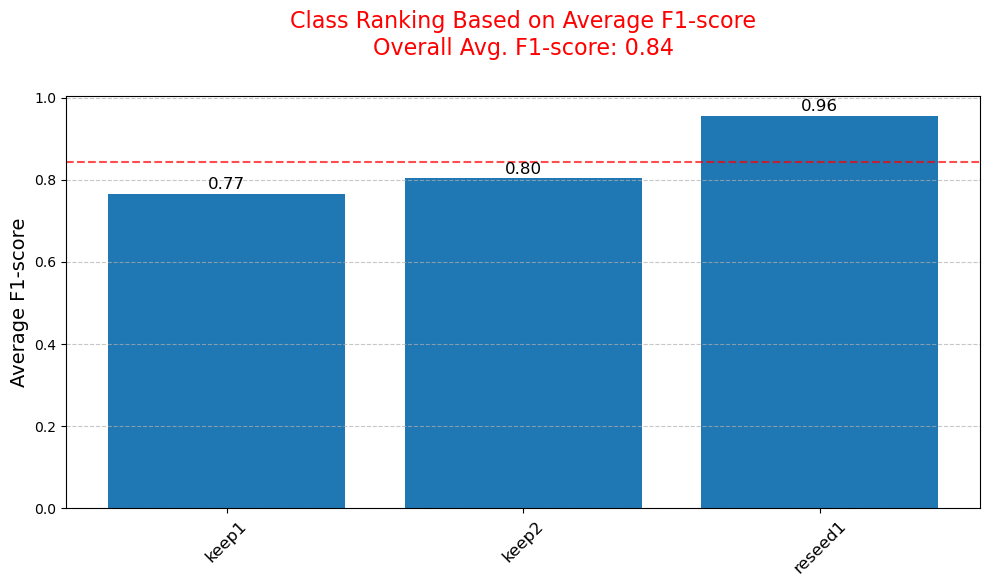

class_0_f1_score,▁▃▂▄▅▆▆▅▁▅▅▃▇▇█▇█▄▃▄▅▇▆▇█▆▇▃▅▄▅▆▇▄▆▆▃█▆▅
class_1_f1_score,▅▄▆▅▄▅▅▅▅▇▆▇▇▇▇▇▇▄▅▆▇█▇▇█▇▇▁▆▇▇▇▇▃▇▇▇██▇
class_2_f1_score,▄▇▆▇▇█▇▇▄▇▇▆▇▇▇▇█▆▇▇▇▇▇▇▇█▇▁▆▅▆▆▇▄▇█▇███
epoch,▁▁▂▃▄▅▅▆▁▂▃▄▅▅▆▆▇▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▁▂▃▃▄▅▆
final_accuracy,▁██▇▇
fold,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆███████
train_loss,█▅▃▃▂▂▁▁▄▃▃▂▂▂▂▁▁▅▄▃▃▂▂▂▁▁▁█▄▃▃▂▂▅▃▃▂▂▂▁
val_accuracy,▃▄▄▅▅▆▆▆▃▆▆▆▇▇▇▇▇▄▄▆▇▇▇▇█▇▇▁▅▆▆▆▇▃▆▇▆█▇▇
val_loss,█▄▃▄▄▃▄▄▆▅▃▃▂▃▂▂▂▅▄▃▂▃▃▂▂▂▃█▅▃▃▄▃▅▂▂▃▁▂▂
class_0_f1_score,0.76636
class_1_f1_score,0.80392


Training on fold 1/5
cuda
Epoch 1, Train Loss: 1.1964367453644915, Validation Loss: 0.9294328093528748, Accuracy: 50.920245398773005 %
Class 0 F1 Score: 0.6808510638297871
Class 1 F1 Score: 0.43333333333333335
Class 2 F1 Score: 0.27692307692307694
Epoch 2, Train Loss: 0.7870936626341285, Validation Loss: 0.5524923702081045, Accuracy: 63.80368098159509 %
Class 0 F1 Score: 0.4222222222222222
Class 1 F1 Score: 0.6046511627906976
Class 2 F1 Score: 0.8598130841121495
Epoch 3, Train Loss: 0.5819247902893439, Validation Loss: 0.5064156924684843, Accuracy: 69.93865030674847 %
Class 0 F1 Score: 0.4731182795698925
Class 1 F1 Score: 0.6666666666666667
Class 2 F1 Score: 0.896
Epoch 4, Train Loss: 0.5391755532927629, Validation Loss: 0.6225878596305847, Accuracy: 71.77914110429448 %
Class 0 F1 Score: 0.7153284671532848
Class 1 F1 Score: 0.631578947368421
Class 2 F1 Score: 0.8085106382978724
Epoch 5, Train Loss: 0.4869016430726865, Validation Loss: 0.4087902481357257, Accuracy: 79.14110429447852 %
C

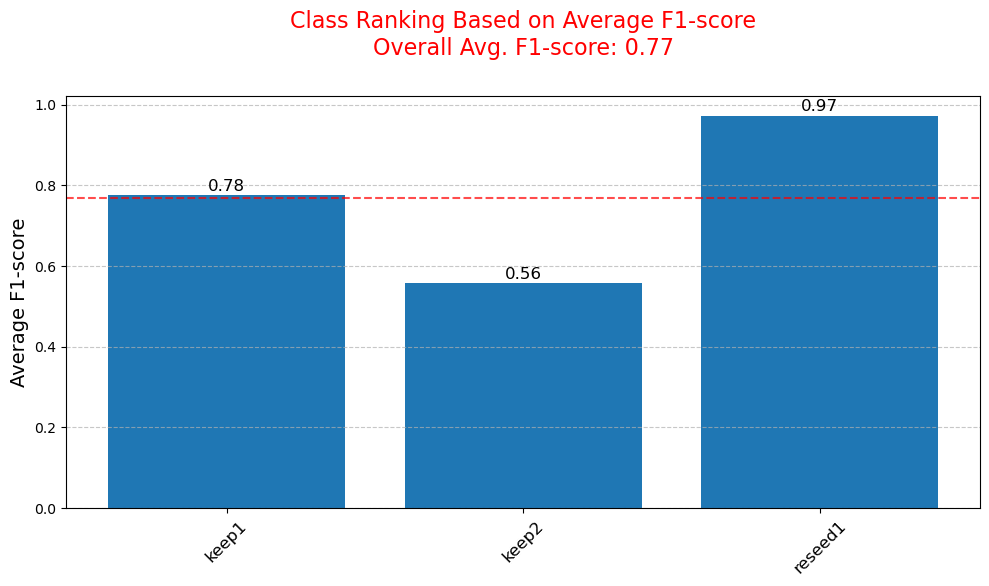

Training on fold 2/5
cuda
Epoch 1, Train Loss: 1.2757744963576154, Validation Loss: 1.0705823302268982, Accuracy: 42.94478527607362 %
Class 0 F1 Score: 0.5528455284552845
Class 1 F1 Score: 0.4931506849315068
Class 2 F1 Score: 0.0
Epoch 2, Train Loss: 0.8682958411007393, Validation Loss: 0.5705071091651917, Accuracy: 71.16564417177914 %
Class 0 F1 Score: 0.7132867132867132
Class 1 F1 Score: 0.4411764705882353
Class 2 F1 Score: 0.8695652173913043
Epoch 3, Train Loss: 0.5796076917066807, Validation Loss: 0.5023728410402933, Accuracy: 73.00613496932516 %
Class 0 F1 Score: 0.594059405940594
Class 1 F1 Score: 0.6605504587155963
Class 2 F1 Score: 0.9137931034482759
Epoch 4, Train Loss: 0.5020518920770506, Validation Loss: 0.4681245485941569, Accuracy: 76.68711656441718 %
Class 0 F1 Score: 0.6949152542372882
Class 1 F1 Score: 0.6595744680851064
Class 2 F1 Score: 0.9298245614035088
Epoch 5, Train Loss: 0.5067723582430583, Validation Loss: 0.4616674880186717, Accuracy: 74.84662576687117 %
Class 

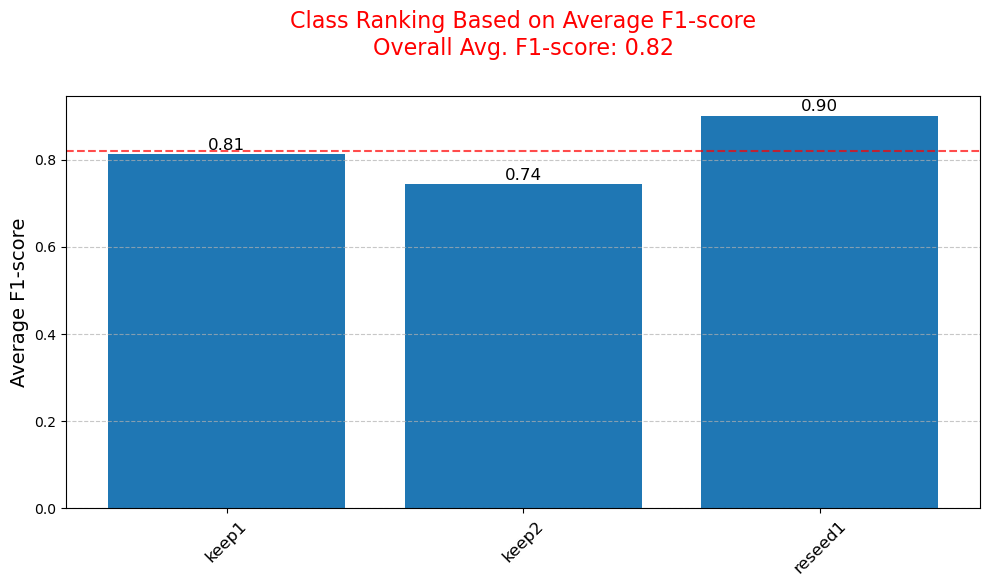

Training on fold 3/5
cuda
Epoch 1, Train Loss: 1.3839601191078745, Validation Loss: 1.0663582881291707, Accuracy: 54.60122699386503 %
Class 0 F1 Score: 0.5591397849462365
Class 1 F1 Score: 0.36065573770491804
Class 2 F1 Score: 0.6046511627906976
Epoch 2, Train Loss: 0.9936954757062401, Validation Loss: 1.002401888370514, Accuracy: 46.625766871165645 %
Class 0 F1 Score: 0.6071428571428571
Class 1 F1 Score: 0.4666666666666667
Class 2 F1 Score: 0.21875
Epoch 3, Train Loss: 0.7460908213766609, Validation Loss: 0.5059923678636551, Accuracy: 76.07361963190183 %
Class 0 F1 Score: 0.7285714285714286
Class 1 F1 Score: 0.5555555555555555
Class 2 F1 Score: 0.9298245614035088
Epoch 4, Train Loss: 0.5921594907597798, Validation Loss: 0.5470477674777309, Accuracy: 73.61963190184049 %
Class 0 F1 Score: 0.7031250000000001
Class 1 F1 Score: 0.5277777777777778
Class 2 F1 Score: 0.888888888888889
Epoch 5, Train Loss: 0.5082565248012543, Validation Loss: 0.5058736273398002, Accuracy: 76.07361963190183 %
C

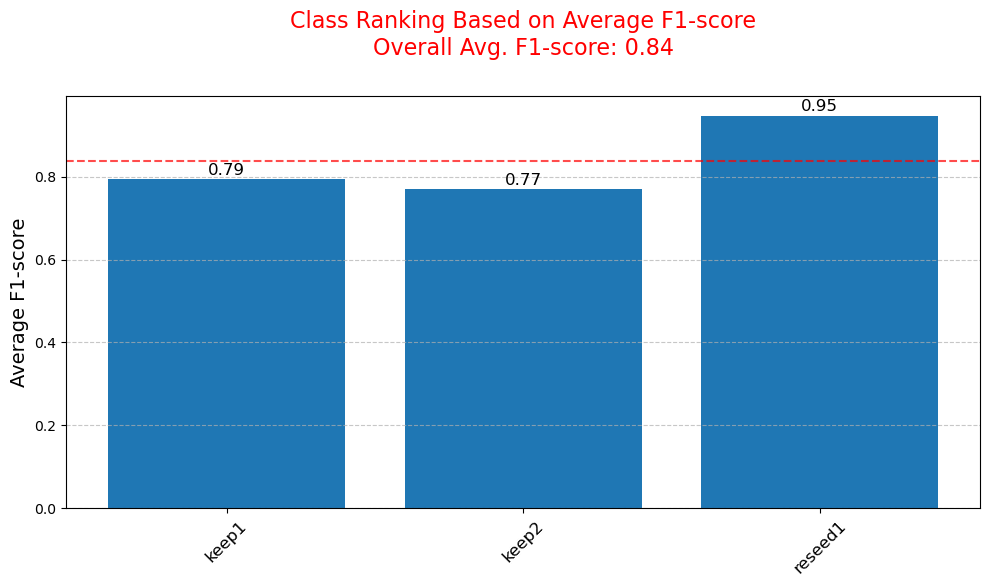

Training on fold 4/5
cuda
Epoch 1, Train Loss: 1.2579255336668433, Validation Loss: 0.9381536841392517, Accuracy: 58.282208588957054 %
Class 0 F1 Score: 0.6356589147286822
Class 1 F1 Score: 0.42666666666666664
Class 2 F1 Score: 0.6229508196721312
Epoch 2, Train Loss: 0.833816276817787, Validation Loss: 0.6847635010878245, Accuracy: 74.23312883435582 %
Class 0 F1 Score: 0.7483870967741936
Class 1 F1 Score: 0.5633802816901409
Class 2 F1 Score: 0.86
Epoch 3, Train Loss: 0.5598039539848886, Validation Loss: 0.56541857868433, Accuracy: 69.93865030674847 %
Class 0 F1 Score: 0.7007299270072993
Class 1 F1 Score: 0.4262295081967213
Class 2 F1 Score: 0.8281249999999999
Epoch 4, Train Loss: 0.5531657585283605, Validation Loss: 0.5989629427591959, Accuracy: 72.39263803680981 %
Class 0 F1 Score: 0.7215189873417721
Class 1 F1 Score: 0.5507246376811594
Class 2 F1 Score: 0.8484848484848484
Epoch 5, Train Loss: 0.5262134046089358, Validation Loss: 0.5488225917021433, Accuracy: 76.68711656441718 %
Class

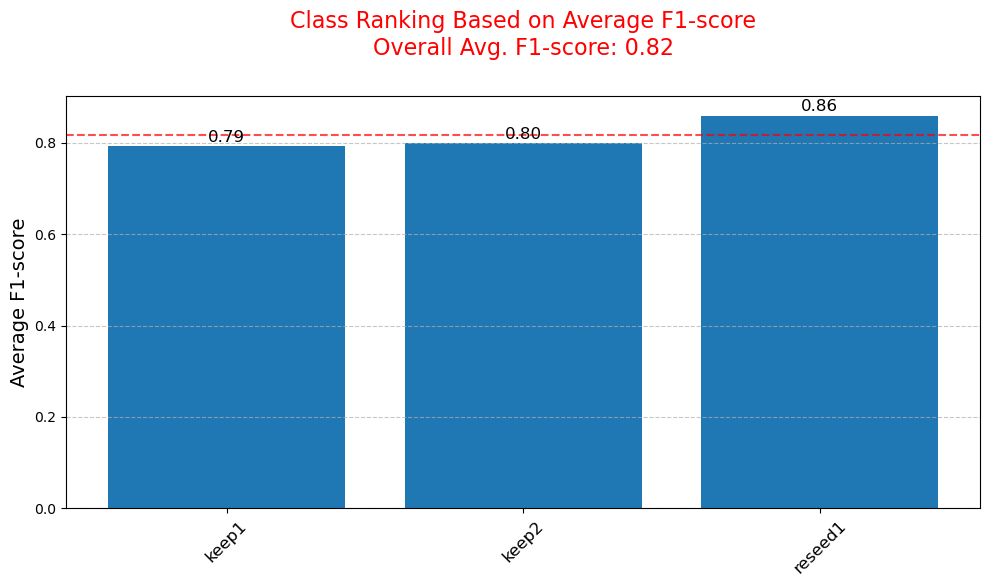

Training on fold 5/5
cuda
Epoch 1, Train Loss: 1.2129968041326942, Validation Loss: 0.8208674192428589, Accuracy: 58.641975308641975 %
Class 0 F1 Score: 0.7194244604316549
Class 1 F1 Score: 0.10526315789473684
Class 2 F1 Score: 0.6562499999999999
Epoch 2, Train Loss: 0.7481046115479818, Validation Loss: 0.5581736167271932, Accuracy: 75.92592592592592 %
Class 0 F1 Score: 0.7194244604316549
Class 1 F1 Score: 0.6913580246913581
Class 2 F1 Score: 0.8653846153846154
Epoch 3, Train Loss: 0.6049119626603475, Validation Loss: 0.44412176807721454, Accuracy: 78.39506172839506 %
Class 0 F1 Score: 0.7552447552447552
Class 1 F1 Score: 0.64
Class 2 F1 Score: 0.9245283018867924
Epoch 4, Train Loss: 0.5680169368662485, Validation Loss: 0.4335552627841632, Accuracy: 77.77777777777777 %
Class 0 F1 Score: 0.7096774193548386
Class 1 F1 Score: 0.6818181818181819
Class 2 F1 Score: 0.9285714285714286
Epoch 5, Train Loss: 0.5121654824512761, Validation Loss: 0.3737763886650403, Accuracy: 79.01234567901234 %
C

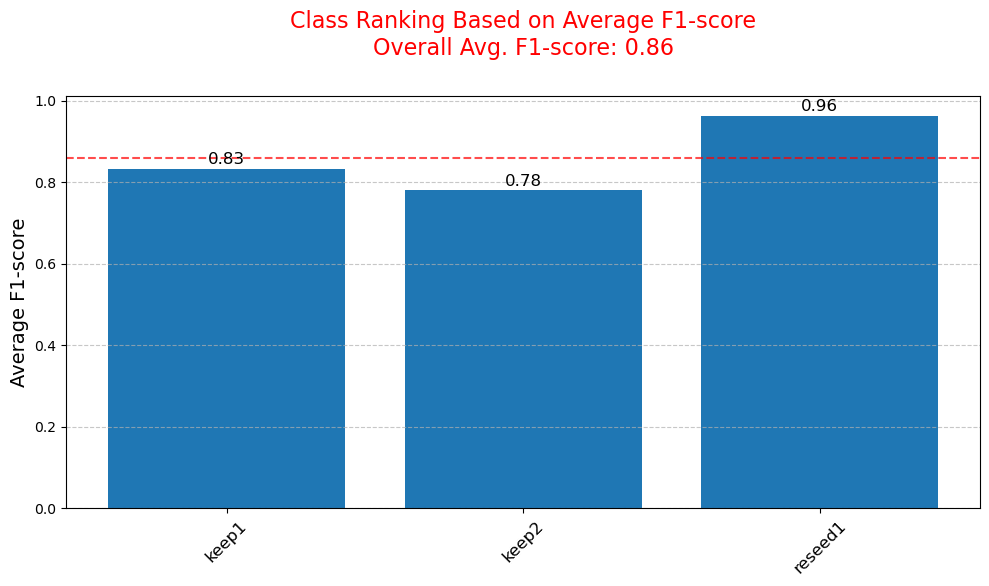

class_0_f1_score,▅▁▆▅▆▃▃▅▆▆▇▃▇█▇▆▇▄▅▅▄▆▅▇▇▇▇▄▅▅▆▇▆▆▆▂▇▆██
class_1_f1_score,▄▆▆▇▅▅▆▅▇▇▇▇███▇▇▅▅▇▇▇█▇▇▇▇▄▄▇▇█▁▆▇▇████
class_2_f1_score,▃████▁███████████▃▇████████▆▇▇▇█▆███████
epoch,▁▂▂▃▄▁▂▂▃▄▄▅▅▆▇▇█▁▂▂▃▄▄▅▆▆▇▁▂▂▃▄▁▂▂▃▄▄▅▅
final_accuracy,▁▄▆▃█
fold,▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆████████
train_loss,█▄▃▃▃▂▄▃▃▃▃▂▂▁▁▁▁▇▃▄▃▃▂▂▂▂▂▆▄▃▃▂█▄▃▃▂▂▂▂
val_accuracy,▂▅▇▇▇▁▆▆▇▇▇▆▇██▇▇▂▆▆▆▇▇█▇▇▇▃▅▆▇▇▃▇▇▅█▇██
val_loss,▇▃▂▂▂█▃▃▂▂▂▃▂▂▂▂▃▇▃▃▃▂▃▂▂▂▃▇▄▃▄▃▆▂▂▃▂▁▁▁
class_0_f1_score,0.83333
class_1_f1_score,0.78049


Training on fold 1/5


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


cuda
Epoch 1, Train Loss: 0.6140119267834557, Validation Loss: 0.5902761220932007, Accuracy: 75.0 %
Class 0 F1 Score: 0.7804878048780488
Class 1 F1 Score: 0.7096774193548387
Epoch 2, Train Loss: 0.4496362970934974, Validation Loss: 0.47492875158786774, Accuracy: 86.11111111111111 %
Class 0 F1 Score: 0.8936170212765957
Class 1 F1 Score: 0.8
Epoch 3, Train Loss: 0.3349321989549531, Validation Loss: 0.631986528635025, Accuracy: 86.11111111111111 %
Class 0 F1 Score: 0.9019607843137255
Class 1 F1 Score: 0.761904761904762
Epoch 4, Train Loss: 0.1612048861053255, Validation Loss: 0.6710450788959861, Accuracy: 61.111111111111114 %
Class 0 F1 Score: 0.5757575757575758
Class 1 F1 Score: 0.6410256410256411
Epoch 5, Train Loss: 0.0827912845545345, Validation Loss: 0.49647386744618416, Accuracy: 76.38888888888889 %
Class 0 F1 Score: 0.7901234567901234
Class 1 F1 Score: 0.7301587301587302
Epoch 6, Train Loss: 0.0826772769085235, Validation Loss: 0.8445577658712864, Accuracy: 62.5 %
Class 0 F1 Score:

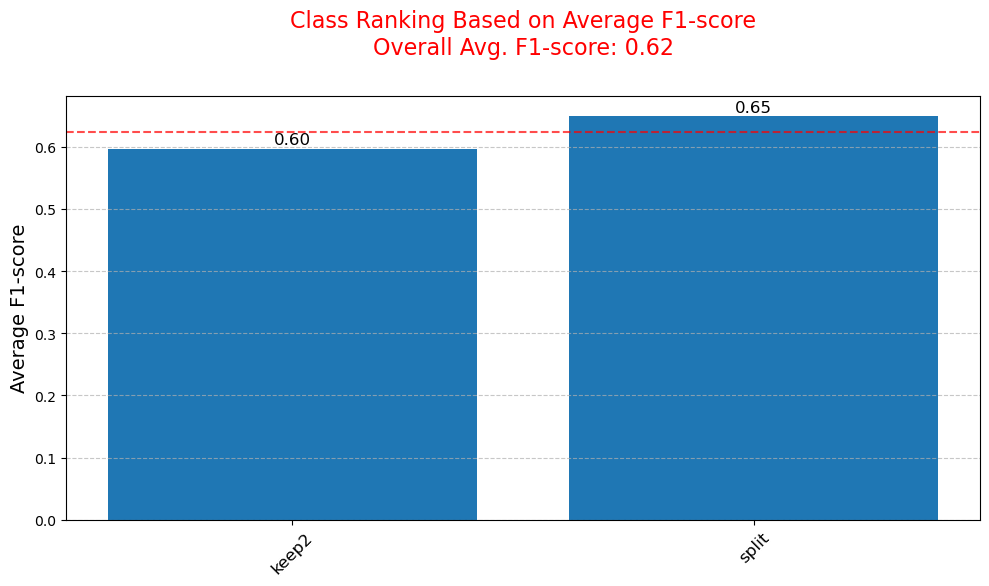

Training on fold 2/5


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


cuda
Epoch 1, Train Loss: 0.6241343518098196, Validation Loss: 0.6623666286468506, Accuracy: 77.46478873239437 %
Class 0 F1 Score: 0.7948717948717949
Class 1 F1 Score: 0.7500000000000001
Epoch 2, Train Loss: 0.46102221144570243, Validation Loss: 0.49811676144599915, Accuracy: 78.87323943661971 %
Class 0 F1 Score: 0.8314606741573034
Class 1 F1 Score: 0.7169811320754718
Epoch 3, Train Loss: 0.37747135510047275, Validation Loss: 0.6434895247220993, Accuracy: 81.69014084507042 %
Class 0 F1 Score: 0.8686868686868686
Class 1 F1 Score: 0.6976744186046512
Epoch 4, Train Loss: 0.23019252138005364, Validation Loss: 2.077552080154419, Accuracy: 67.6056338028169 %
Class 0 F1 Score: 0.7964601769911505
Class 1 F1 Score: 0.20689655172413793
Epoch 5, Train Loss: 0.12883337173197004, Validation Loss: 1.0342773497104645, Accuracy: 77.46478873239437 %
Class 0 F1 Score: 0.84
Class 1 F1 Score: 0.6190476190476191
Epoch 6, Train Loss: 0.08106780300537746, Validation Loss: 0.4370072931051254, Accuracy: 80.281

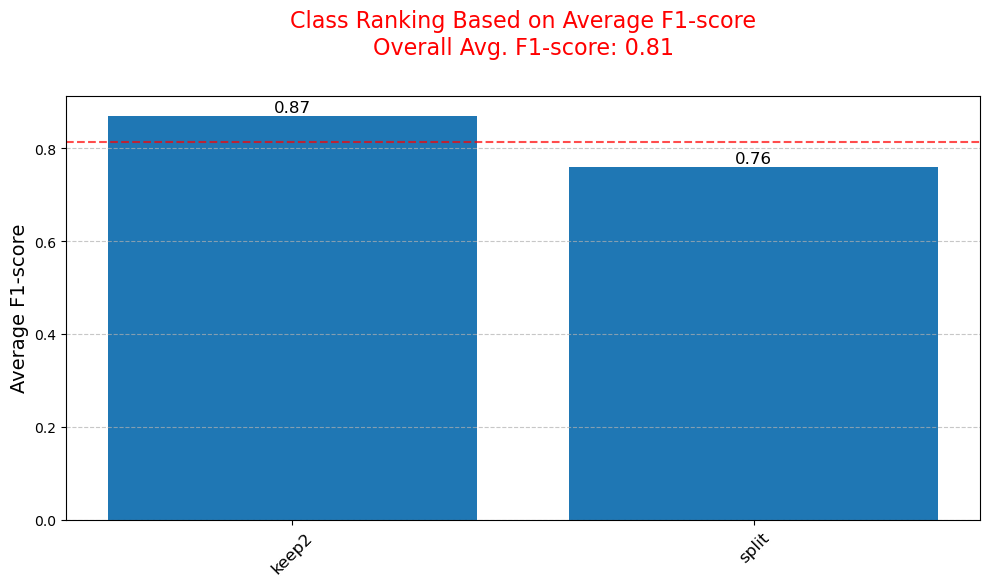

Training on fold 3/5


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


cuda
Epoch 1, Train Loss: 0.6211519009537168, Validation Loss: 0.5817081183195114, Accuracy: 36.61971830985915 %
Class 0 F1 Score: 0.08163265306122448
Class 1 F1 Score: 0.5161290322580645
Epoch 2, Train Loss: 0.4407515989409553, Validation Loss: 0.7551312744617462, Accuracy: 74.64788732394366 %
Class 0 F1 Score: 0.8163265306122449
Class 1 F1 Score: 0.5909090909090909
Epoch 3, Train Loss: 0.34433494839403367, Validation Loss: 1.3829130828380585, Accuracy: 67.6056338028169 %
Class 0 F1 Score: 0.7889908256880734
Class 1 F1 Score: 0.30303030303030304
Epoch 4, Train Loss: 0.21245237977968323, Validation Loss: 1.3598254024982452, Accuracy: 64.78873239436619 %
Class 0 F1 Score: 0.7747747747747747
Class 1 F1 Score: 0.1935483870967742
Epoch 5, Train Loss: 0.07885341066867113, Validation Loss: 7.270228624343872, Accuracy: 64.78873239436619 %
Class 0 F1 Score: 0.7863247863247863
Class 1 F1 Score: 0.0
Early stopping triggered
Stopping training


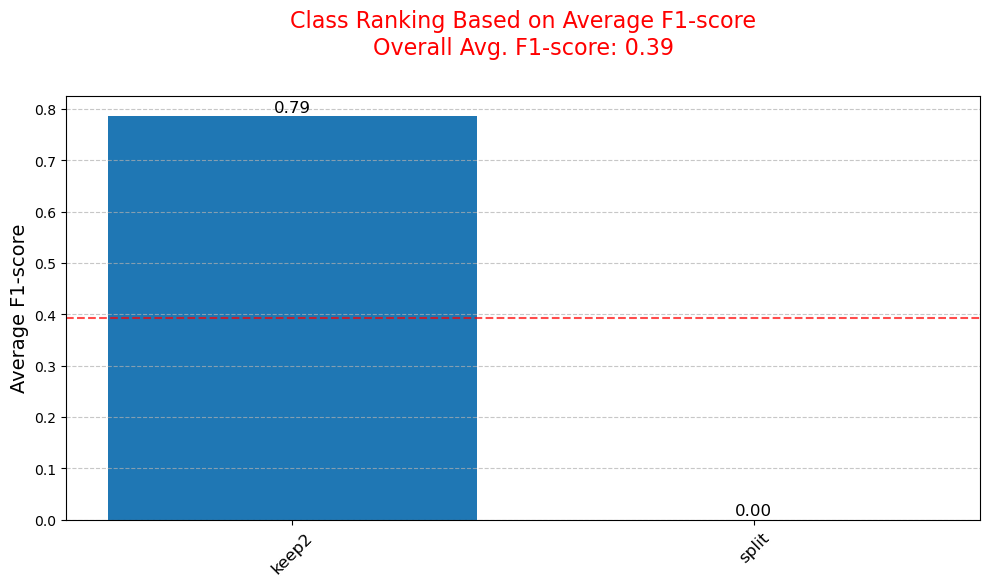

Training on fold 4/5


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


cuda
Epoch 1, Train Loss: 0.6327015459537506, Validation Loss: 0.5951526015996933, Accuracy: 35.2112676056338 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.5208333333333333
Epoch 2, Train Loss: 0.45324165291256374, Validation Loss: 0.6566651165485382, Accuracy: 70.4225352112676 %
Class 0 F1 Score: 0.7741935483870968
Class 1 F1 Score: 0.5714285714285714
Epoch 3, Train Loss: 0.3643263197607464, Validation Loss: 0.7738598585128784, Accuracy: 74.64788732394366 %
Class 0 F1 Score: 0.826923076923077
Class 1 F1 Score: 0.5263157894736842
Epoch 4, Train Loss: 0.24050479547844994, Validation Loss: 2.125081419944763, Accuracy: 64.78873239436619 %
Class 0 F1 Score: 0.7787610619469028
Class 1 F1 Score: 0.13793103448275865
Epoch 5, Train Loss: 0.14820095234447056, Validation Loss: 0.452772855758667, Accuracy: 76.05633802816901 %
Class 0 F1 Score: 0.8131868131868132
Class 1 F1 Score: 0.6666666666666666
Epoch 6, Train Loss: 0.1001463836679856, Validation Loss: 0.44993264600634575, Accuracy: 70.422535211

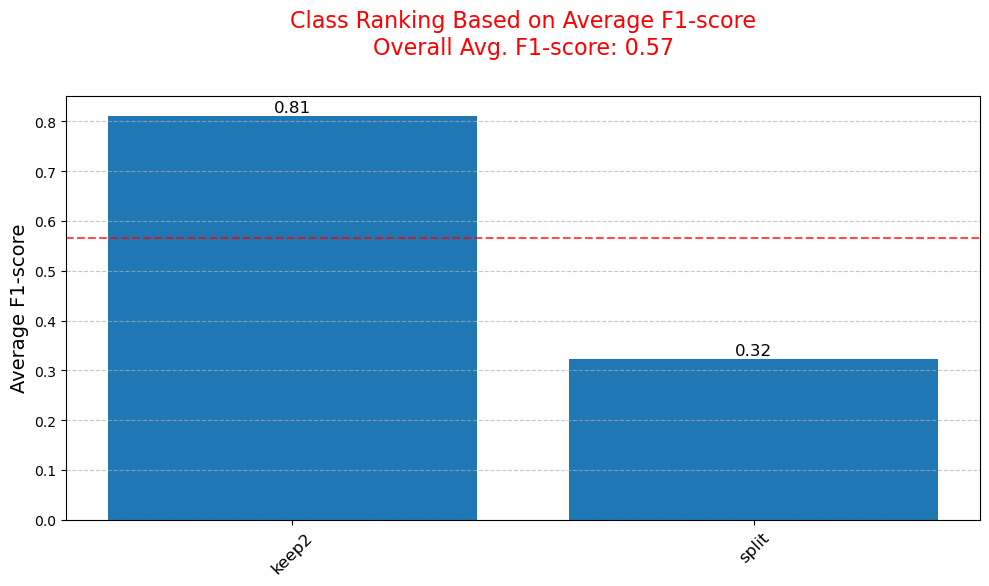

Training on fold 5/5


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


cuda
Epoch 1, Train Loss: 0.604539531800482, Validation Loss: 0.6097927615046501, Accuracy: 35.2112676056338 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.5208333333333333
Epoch 2, Train Loss: 0.4266216340992186, Validation Loss: 0.4098835736513138, Accuracy: 74.64788732394366 %
Class 0 F1 Score: 0.7692307692307693
Class 1 F1 Score: 0.71875
Epoch 3, Train Loss: 0.2719647093779511, Validation Loss: 0.6355097889900208, Accuracy: 76.05633802816901 %
Class 0 F1 Score: 0.8282828282828283
Class 1 F1 Score: 0.6046511627906976
Epoch 4, Train Loss: 0.114340643501944, Validation Loss: 0.82509193290025, Accuracy: 57.74647887323944 %
Class 0 F1 Score: 0.5161290322580645
Class 1 F1 Score: 0.625
Epoch 5, Train Loss: 0.06507591985993916, Validation Loss: 0.6411393545567989, Accuracy: 77.46478873239437 %
Class 0 F1 Score: 0.7894736842105263
Class 1 F1 Score: 0.7575757575757575
Epoch 6, Train Loss: 0.08645083786298831, Validation Loss: 0.7105600982904434, Accuracy: 85.91549295774648 %
Class 0 F1 Score: 0

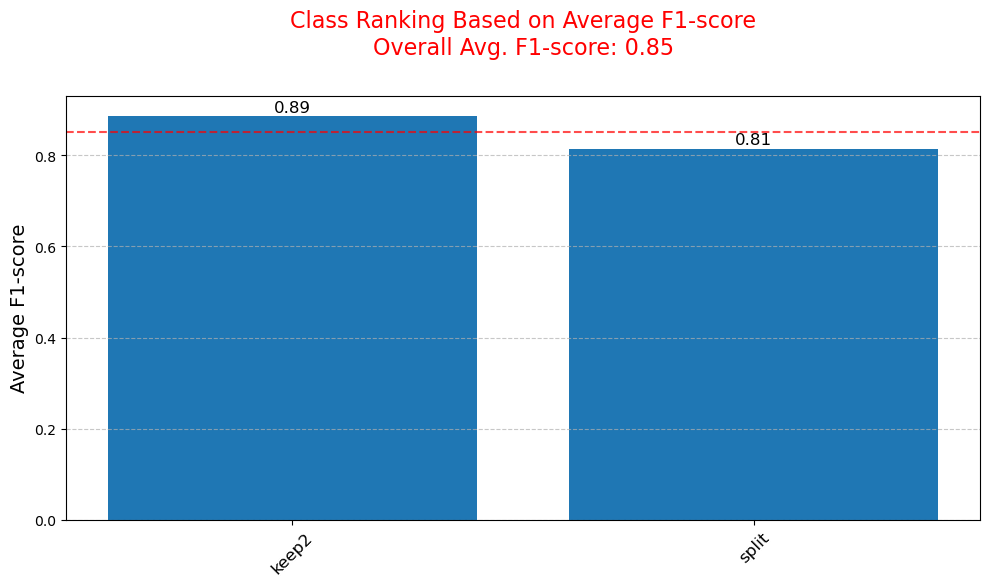

class_0_f1_score,▇▇██▅▇▆▇▇█▇██▇█▇▇█▂▇▇▇▇▁▇▇▇▇▆█▇██▇▁▇▇▅▇█
class_1_f1_score,▇▇██▇▇▇▇▇▇▃▆▇▅▇▅▅█▅▆▄▃▁▅▆▆▂▇▇▇▄▇▇▄▅▇▆▆██
epoch,▁▂▃▃▄▅▆▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▆
final_accuracy,▁▇▂▃█
fold,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆███████
train_loss,█▆▄▂▁▁▃█▆▅▃▂▁▂▂▂▁▁█▆▃▁▁█▆▅▃▂▂▁▁▂▂▂█▆▄▂▁▂
val_accuracy,▆██▅▇▅▇▇▇▅▇▇▆▇▆█▁▆▅▅▅▁▆▆▅▇▆▇▆▇▆▁▆▇▄▇█
val_loss,▁▁▁▁▁▁▁▁▁▃▂▁▂▁▂▁▁▁▂▂█▁▁▁▃▁▁▁▂▂▃▁▁▁▁▁▁
class_0_f1_score,0.88636
class_1_f1_score,0.81481
epoch,6


Training on fold 1/5


The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.


cuda
Epoch 1, Train Loss: 0.5286098453733656, Validation Loss: 0.34132520854473114, Accuracy: 63.888888888888886 %
Class 0 F1 Score: 0.6060606060606061
Class 1 F1 Score: 0.6666666666666666
Epoch 2, Train Loss: 0.2873965609404776, Validation Loss: 0.23301634937524796, Accuracy: 87.5 %
Class 0 F1 Score: 0.8941176470588235
Class 1 F1 Score: 0.8474576271186441
Epoch 3, Train Loss: 0.14238805199662843, Validation Loss: 0.33459916710853577, Accuracy: 84.72222222222223 %
Class 0 F1 Score: 0.8817204301075269
Class 1 F1 Score: 0.7843137254901961
Epoch 4, Train Loss: 0.07180824544694689, Validation Loss: 0.22902788314968348, Accuracy: 83.33333333333333 %
Class 0 F1 Score: 0.8571428571428571
Class 1 F1 Score: 0.8000000000000002
Epoch 5, Train Loss: 0.046936798892501325, Validation Loss: 0.7284785211086273, Accuracy: 83.33333333333333 %
Class 0 F1 Score: 0.8823529411764706
Class 1 F1 Score: 0.7142857142857143
Epoch 6, Train Loss: 0.030782152225987777, Validation Loss: 0.2713379077613354, Accuracy:

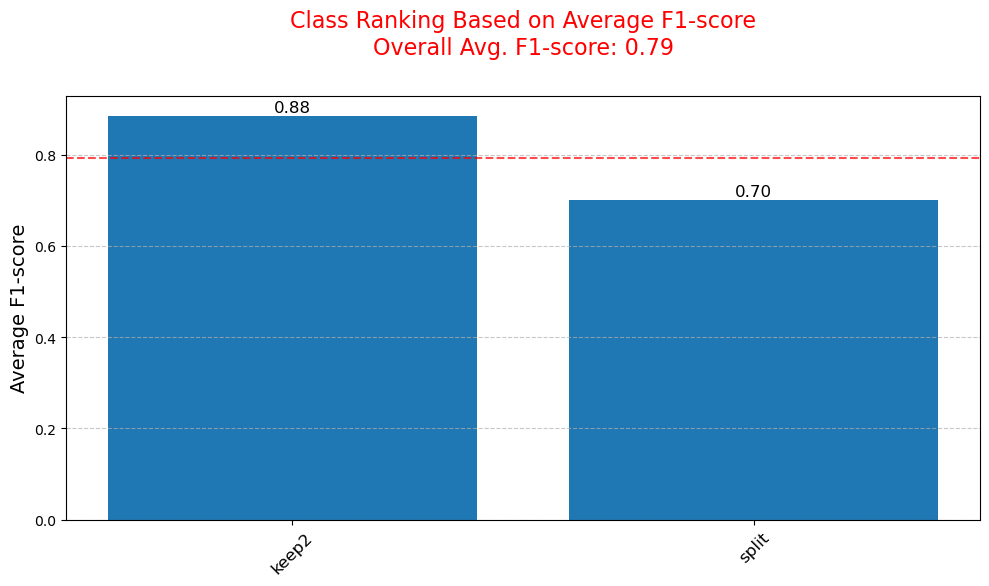

Training on fold 2/5


The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.


cuda
Epoch 1, Train Loss: 0.5818353692690531, Validation Loss: 0.46407774090766907, Accuracy: 64.78873239436619 %
Class 0 F1 Score: 0.647887323943662
Class 1 F1 Score: 0.647887323943662
Epoch 2, Train Loss: 0.32159778972466785, Validation Loss: 0.3139975070953369, Accuracy: 71.83098591549296 %
Class 0 F1 Score: 0.7297297297297297
Class 1 F1 Score: 0.7058823529411763
Epoch 3, Train Loss: 0.17912003190981018, Validation Loss: 0.4562184363603592, Accuracy: 87.32394366197182 %
Class 0 F1 Score: 0.9090909090909092
Class 1 F1 Score: 0.7906976744186047
Epoch 4, Train Loss: 0.08884016714162296, Validation Loss: 0.21320528723299503, Accuracy: 85.91549295774648 %
Class 0 F1 Score: 0.8809523809523809
Class 1 F1 Score: 0.8275862068965517
Epoch 5, Train Loss: 0.05349863662074009, Validation Loss: 0.23820514976978302, Accuracy: 87.32394366197182 %
Class 0 F1 Score: 0.898876404494382
Class 1 F1 Score: 0.830188679245283
Epoch 6, Train Loss: 0.028541033880578145, Validation Loss: 1.5270068943500519, Ac

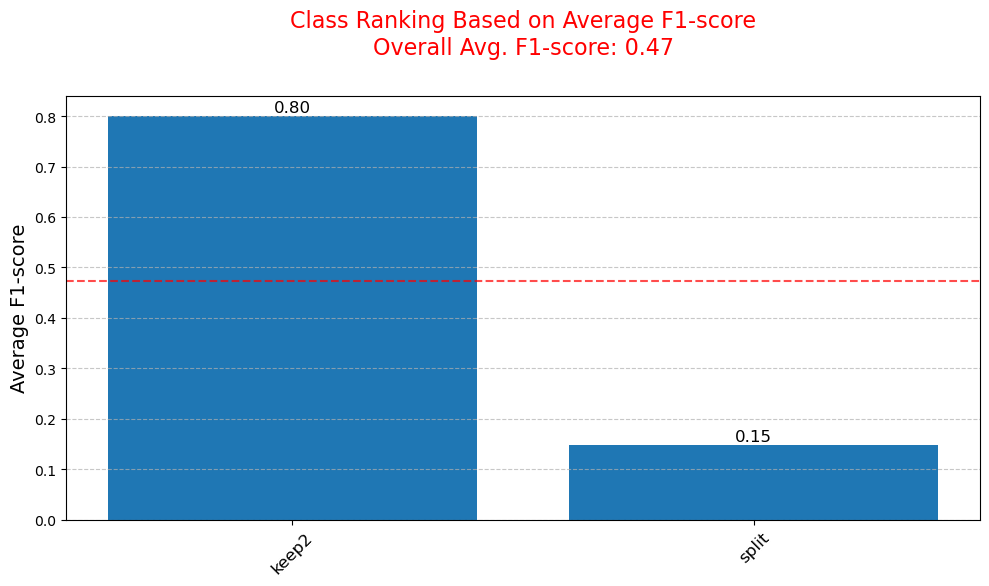

Training on fold 3/5


The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.


cuda
Epoch 1, Train Loss: 0.4834785991244846, Validation Loss: 0.7288788557052612, Accuracy: 77.46478873239437 %
Class 0 F1 Score: 0.836734693877551
Class 1 F1 Score: 0.6363636363636364
Epoch 2, Train Loss: 0.2761012373699082, Validation Loss: 1.0238958299160004, Accuracy: 70.4225352112676 %
Class 0 F1 Score: 0.8037383177570093
Class 1 F1 Score: 0.4
Epoch 3, Train Loss: 0.14795017863313356, Validation Loss: 0.39224714040756226, Accuracy: 84.50704225352112 %
Class 0 F1 Score: 0.8764044943820224
Class 1 F1 Score: 0.7924528301886793
Epoch 4, Train Loss: 0.06757467767844598, Validation Loss: 0.6375294029712677, Accuracy: 78.87323943661971 %
Class 0 F1 Score: 0.8484848484848485
Class 1 F1 Score: 0.6511627906976745
Epoch 5, Train Loss: 0.032681441141499415, Validation Loss: 2.254562199115753, Accuracy: 73.2394366197183 %
Class 0 F1 Score: 0.819047619047619
Class 1 F1 Score: 0.48648648648648657
Epoch 6, Train Loss: 0.03819967438984248, Validation Loss: 1.6364786624908447, Accuracy: 73.2394366

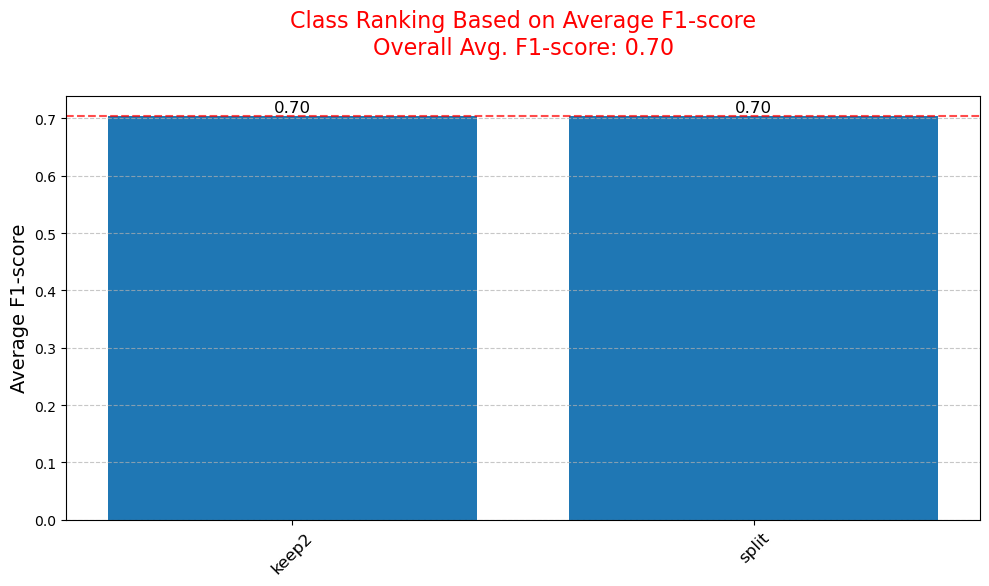

Training on fold 4/5


The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.


cuda
Epoch 1, Train Loss: 0.4945299956533644, Validation Loss: 0.5043653249740601, Accuracy: 52.11267605633803 %
Class 0 F1 Score: 0.46875000000000006
Class 1 F1 Score: 0.5641025641025641
Epoch 2, Train Loss: 0.29389117161432904, Validation Loss: 0.4112042933702469, Accuracy: 78.87323943661971 %
Class 0 F1 Score: 0.8275862068965518
Class 1 F1 Score: 0.7272727272727272
Epoch 3, Train Loss: 0.1728120669722557, Validation Loss: 0.31539636850357056, Accuracy: 78.87323943661971 %
Class 0 F1 Score: 0.8275862068965518
Class 1 F1 Score: 0.7272727272727272
Epoch 4, Train Loss: 0.0992049156791634, Validation Loss: 0.5005988478660583, Accuracy: 81.69014084507042 %
Class 0 F1 Score: 0.8602150537634409
Class 1 F1 Score: 0.7346938775510204
Epoch 5, Train Loss: 0.054807011141545244, Validation Loss: 0.4351562336087227, Accuracy: 78.87323943661971 %
Class 0 F1 Score: 0.8387096774193549
Class 1 F1 Score: 0.6938775510204083
Epoch 6, Train Loss: 0.022516234260466363, Validation Loss: 0.5561103373765945, 

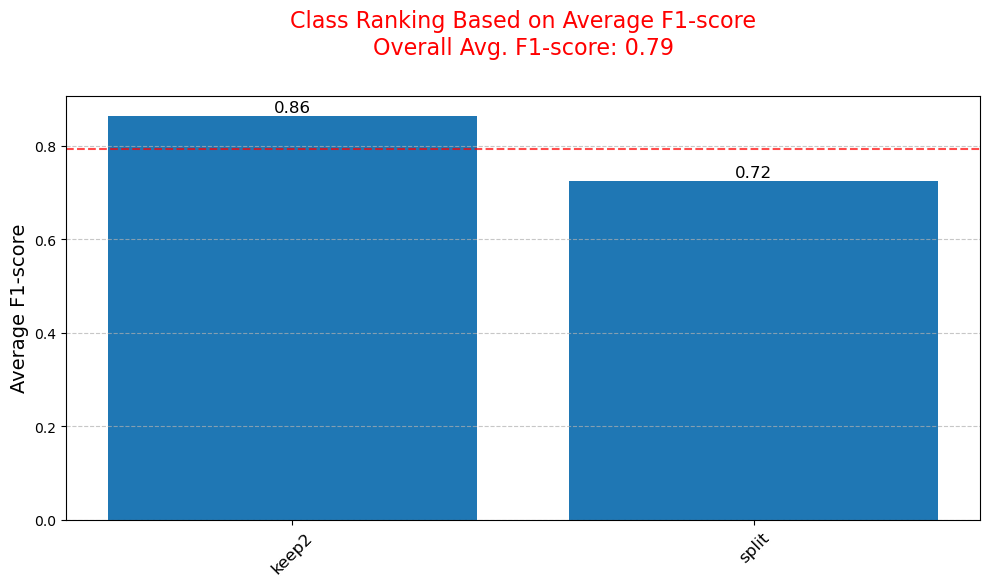

Training on fold 5/5


The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.


cuda
Epoch 1, Train Loss: 0.48680539594756234, Validation Loss: 0.3694819323718548, Accuracy: 63.38028169014085 %
Class 0 F1 Score: 0.6176470588235293
Class 1 F1 Score: 0.6486486486486486
Epoch 2, Train Loss: 0.24566036090254784, Validation Loss: 0.39260606467723846, Accuracy: 78.87323943661971 %
Class 0 F1 Score: 0.8235294117647058
Class 1 F1 Score: 0.736842105263158
Epoch 3, Train Loss: 0.1372136871019999, Validation Loss: 0.5563085619360209, Accuracy: 74.64788732394366 %
Class 0 F1 Score: 0.7567567567567568
Class 1 F1 Score: 0.7352941176470588
Epoch 4, Train Loss: 0.09347624073012008, Validation Loss: 0.6796877766028047, Accuracy: 66.19718309859155 %
Class 0 F1 Score: 0.6470588235294118
Class 1 F1 Score: 0.6756756756756758
Epoch 5, Train Loss: 0.055128805649777256, Validation Loss: 0.4315171241760254, Accuracy: 80.28169014084507 %
Class 0 F1 Score: 0.8292682926829269
Class 1 F1 Score: 0.7666666666666667
Early stopping triggered
Stopping training


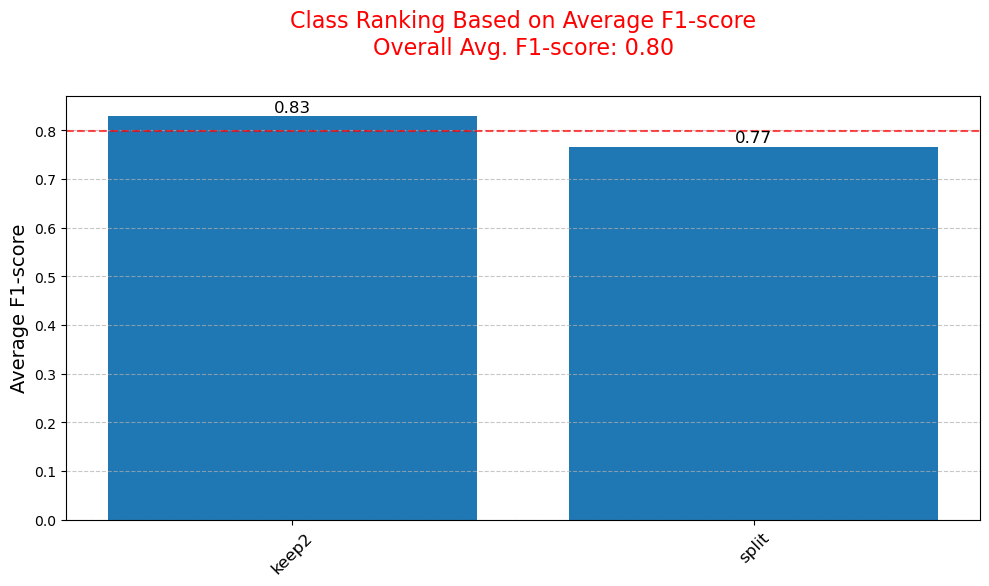

class_0_f1_score,▃█▇▇▇▇▃▇▄▅█▇█▇▅█▅█▇█▄▆▇▆▇▇▆▆▅▁▇▇▇▇▇▃▆▅▄▇
class_1_f1_score,▆█▇▇▇▇▆▆▆▆▇██▄▇█▇███▆▁▆▃▇▆▄▄▆▅▇▇▆▇▇▆▇▇▆▇
epoch,▁▁▂▂▃▃▄▄▁▁▂▂▃▄▄▅▅▆▆▇██▁▁▂▃▃▄▁▁▂▂▃▃▄▁▁▂▂▃
final_accuracy,█▁▂▇▇
fold,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆█████
train_loss,▇▄▃▂▂▁▁▁█▅▃▂▁▁▁▁▁▁▁▁▁▁▇▃▂▁▁▁▇▅▃▂▂▁▁▇▄▃▂▁
val_accuracy,▃▇▇▇▇▇▃▇▃▅▇▇▇▅▅██▅█▇▄▄▆▄▇▆▅▅▄▁▆▆▆▆▇▆▃▆▅▆
val_loss,▁▁▁▁▂▁▂▂▂▁▂▁▁▄▁▁▁▁▁▁▂█▂▃▁▂▅▄▂▂▁▁▂▁▂▂▁▁▂▁
class_0_f1_score,0.82927
class_1_f1_score,0.76667
epoch,5


Training on fold 1/5
cuda
Epoch 1, Train Loss: 1.0321009457111359, Validation Loss: 0.461543969810009, Accuracy: 47.22222222222222 %
Class 0 F1 Score: 0.29629629629629634
Class 1 F1 Score: 0.5777777777777777
Epoch 2, Train Loss: 0.619385388162401, Validation Loss: 0.43612320721149445, Accuracy: 80.55555555555556 %
Class 0 F1 Score: 0.825
Class 1 F1 Score: 0.78125
Epoch 3, Train Loss: 0.5619678613212373, Validation Loss: 0.4507486820220947, Accuracy: 79.16666666666667 %
Class 0 F1 Score: 0.8314606741573034
Class 1 F1 Score: 0.7272727272727274
Epoch 4, Train Loss: 0.5246541516648399, Validation Loss: 0.39644289016723633, Accuracy: 79.16666666666667 %
Class 0 F1 Score: 0.8314606741573034
Class 1 F1 Score: 0.7272727272727274
Epoch 5, Train Loss: 0.4974881360928218, Validation Loss: 0.4332071989774704, Accuracy: 77.77777777777777 %
Class 0 F1 Score: 0.813953488372093
Class 1 F1 Score: 0.7241379310344829
Epoch 6, Train Loss: 0.45827581485112506, Validation Loss: 0.42988795042037964, Accuracy

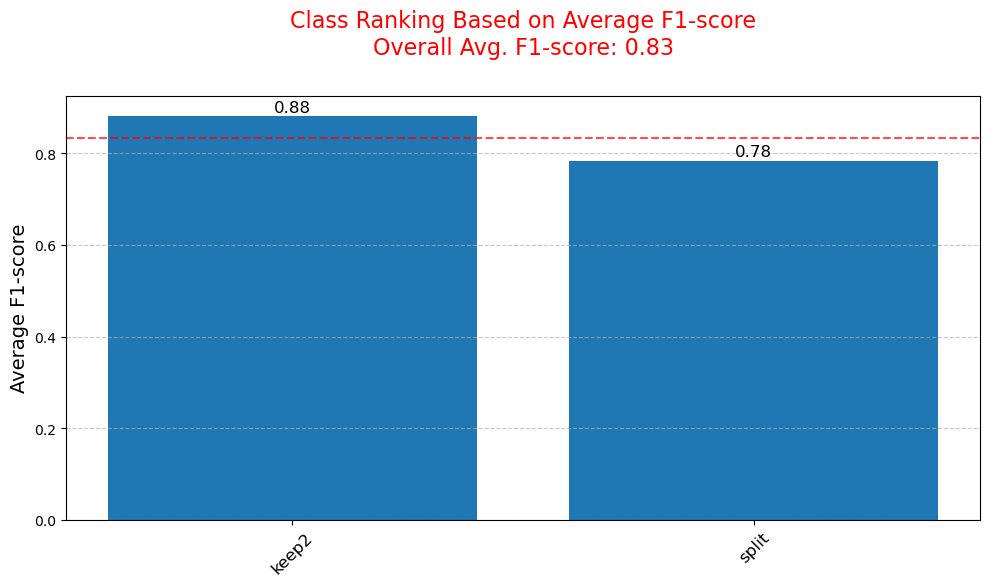

Training on fold 2/5
cuda
Epoch 1, Train Loss: 1.032107134660085, Validation Loss: 0.5036211460828781, Accuracy: 46.478873239436616 %
Class 0 F1 Score: 0.29629629629629634
Class 1 F1 Score: 0.5681818181818182
Epoch 2, Train Loss: 0.6354077061017355, Validation Loss: 0.4792565703392029, Accuracy: 69.01408450704226 %
Class 0 F1 Score: 0.6944444444444445
Class 1 F1 Score: 0.6857142857142858
Epoch 3, Train Loss: 0.5629238469733132, Validation Loss: 0.44400252401828766, Accuracy: 69.01408450704226 %
Class 0 F1 Score: 0.6944444444444445
Class 1 F1 Score: 0.6857142857142858
Epoch 4, Train Loss: 0.5223866783910327, Validation Loss: 0.42120374739170074, Accuracy: 76.05633802816901 %
Class 0 F1 Score: 0.7848101265822786
Class 1 F1 Score: 0.7301587301587301
Epoch 5, Train Loss: 0.4997261381811566, Validation Loss: 0.39236223697662354, Accuracy: 77.46478873239437 %
Class 0 F1 Score: 0.7948717948717949
Class 1 F1 Score: 0.7500000000000001
Epoch 6, Train Loss: 0.4595751232571072, Validation Loss: 0.

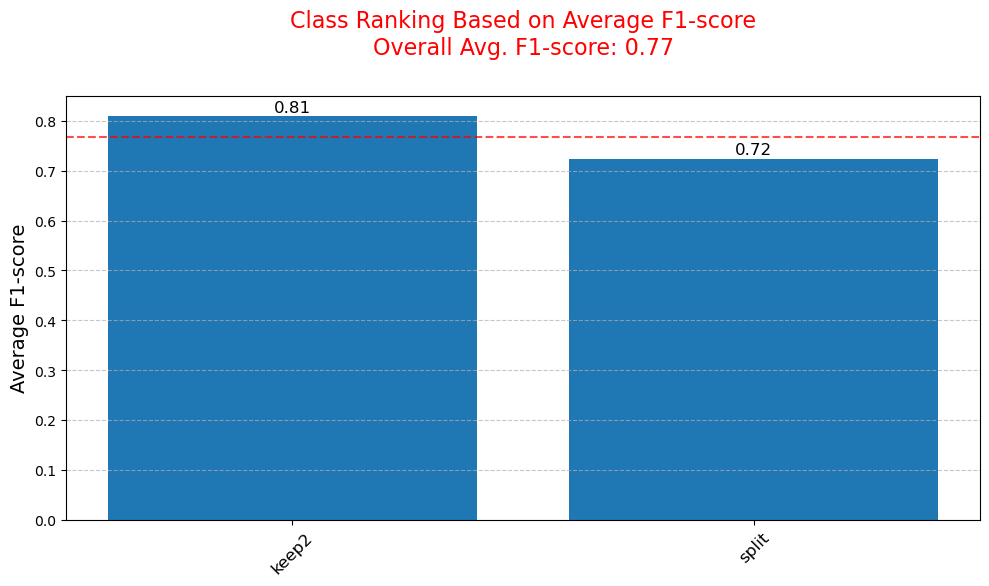

Training on fold 3/5
cuda
Epoch 1, Train Loss: 1.02283176779747, Validation Loss: 0.6244388520717621, Accuracy: 59.15492957746479 %
Class 0 F1 Score: 0.5797101449275363
Class 1 F1 Score: 0.6027397260273972
Epoch 2, Train Loss: 0.6049056765105989, Validation Loss: 0.6274738609790802, Accuracy: 64.78873239436619 %
Class 0 F1 Score: 0.6575342465753423
Class 1 F1 Score: 0.6376811594202899
Epoch 3, Train Loss: 0.5252048306994967, Validation Loss: 0.6581405401229858, Accuracy: 70.4225352112676 %
Class 0 F1 Score: 0.7341772151898734
Class 1 F1 Score: 0.6666666666666667
Epoch 4, Train Loss: 0.49796002275413936, Validation Loss: 0.6557941138744354, Accuracy: 76.05633802816901 %
Class 0 F1 Score: 0.8045977011494252
Class 1 F1 Score: 0.6909090909090909
Epoch 5, Train Loss: 0.47330540749761796, Validation Loss: 0.5583231151103973, Accuracy: 74.64788732394366 %
Class 0 F1 Score: 0.7906976744186046
Class 1 F1 Score: 0.6785714285714285
Epoch 6, Train Loss: 0.4736899882555008, Validation Loss: 0.46889

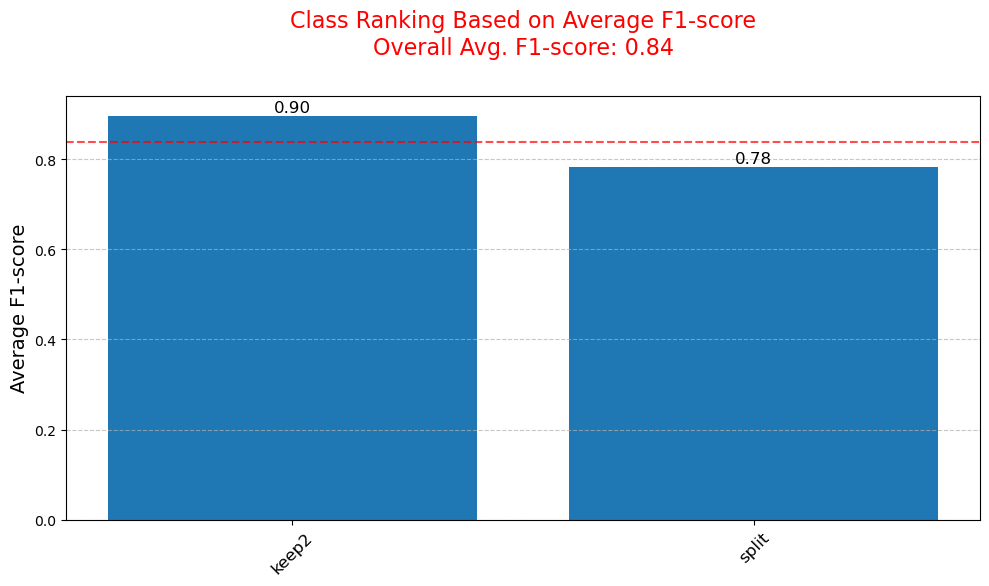

Training on fold 4/5
cuda
Epoch 1, Train Loss: 1.0296946002377405, Validation Loss: 0.8698904514312744, Accuracy: 69.01408450704226 %
Class 0 F1 Score: 0.8035714285714285
Class 1 F1 Score: 0.26666666666666666
Epoch 2, Train Loss: 0.6009569929705726, Validation Loss: 0.7150918543338776, Accuracy: 67.6056338028169 %
Class 0 F1 Score: 0.7228915662650603
Class 1 F1 Score: 0.6101694915254237
Epoch 3, Train Loss: 0.538135235508283, Validation Loss: 0.8118876218795776, Accuracy: 70.4225352112676 %
Class 0 F1 Score: 0.7835051546391751
Class 1 F1 Score: 0.5333333333333332
Epoch 4, Train Loss: 0.5111619267198775, Validation Loss: 0.6945265531539917, Accuracy: 70.4225352112676 %
Class 0 F1 Score: 0.7529411764705882
Class 1 F1 Score: 0.631578947368421
Epoch 5, Train Loss: 0.49547337492307025, Validation Loss: 0.6473006010055542, Accuracy: 76.05633802816901 %
Class 0 F1 Score: 0.8210526315789473
Class 1 F1 Score: 0.6382978723404256
Epoch 6, Train Loss: 0.49705828229586285, Validation Loss: 0.629928

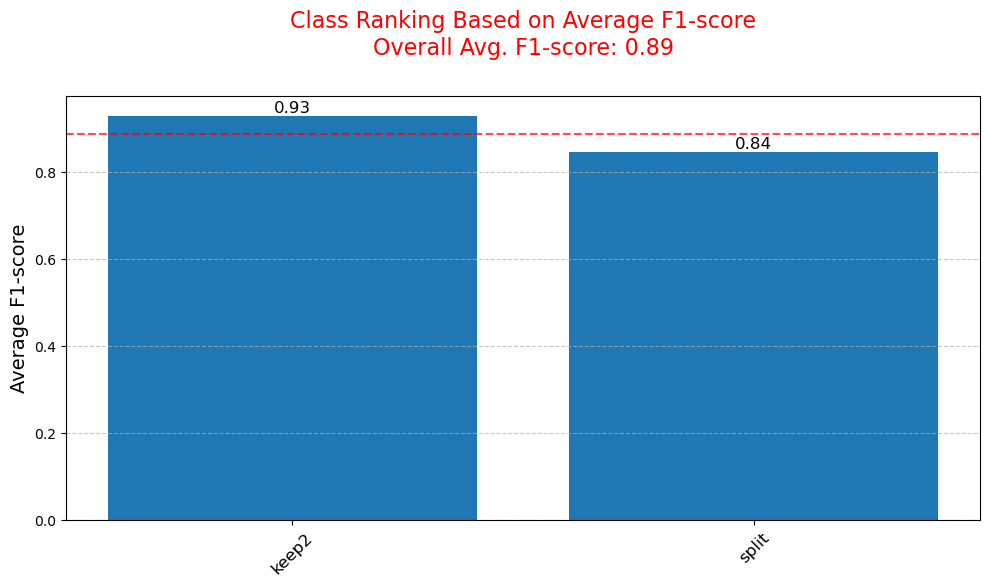

Training on fold 5/5
cuda
Epoch 1, Train Loss: 0.9902764923042722, Validation Loss: 0.7565895318984985, Accuracy: 64.78873239436619 %
Class 0 F1 Score: 0.7863247863247863
Class 1 F1 Score: 0.0
Epoch 2, Train Loss: 0.5884250071313646, Validation Loss: 0.5452835857868195, Accuracy: 77.46478873239437 %
Class 0 F1 Score: 0.8297872340425533
Class 1 F1 Score: 0.6666666666666666
Epoch 3, Train Loss: 0.5606892357269923, Validation Loss: 0.4206598103046417, Accuracy: 63.38028169014085 %
Class 0 F1 Score: 0.6285714285714286
Class 1 F1 Score: 0.6388888888888888
Epoch 4, Train Loss: 0.5186144047313266, Validation Loss: 0.5000007003545761, Accuracy: 77.46478873239437 %
Class 0 F1 Score: 0.8333333333333333
Class 1 F1 Score: 0.6521739130434783
Epoch 5, Train Loss: 0.526769263876809, Validation Loss: 0.4609587639570236, Accuracy: 77.46478873239437 %
Class 0 F1 Score: 0.8297872340425533
Class 1 F1 Score: 0.6666666666666666
Epoch 6, Train Loss: 0.5013875828848945, Validation Loss: 0.381030410528183, Acc

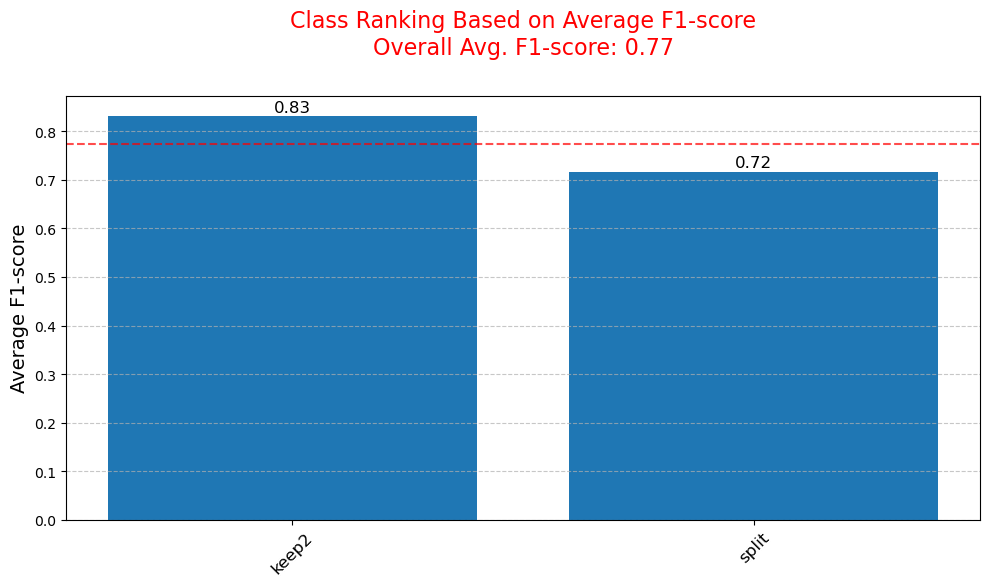

class_0_f1_score,▁▇▇▇█▇█▇▁▅▇█▇▆▇▇▄▆▆▇▇▇▅▇▇▇▇▆▇▇▇▇▇██▇▇▇▇▇
class_1_f1_score,▅▇▇▇▇▇█▇▅▆▇▇▇▆▇▇▅▆▆▇▇▇▆▇▇▇▁▄▆▆▇▇▇██▆▆▇▆▆
epoch,▁▂▃▃▄▅▆▆▁▂▃▄▅▅▆▇▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇▁▂▃▃▅
final_accuracy,▅▁▆█▂
fold,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆█████
train_loss,█▄▄▃▂▃▂▂█▄▃▃▂▂▁▁█▄▃▃▃▂▂▁▂▁█▄▄▃▃▂▂▂▁▄▄▄▄▂
val_accuracy,▁▆▆▆▇▇▇▇▁▅▆▇▆▆▆▆▃▅▆▇▆▆▄▇▇▇▅▅▆▆▆▇▆██▆▆▆▆▆
val_loss,▄▃▃▃▃▃▃▆▄▃▃▅▃▃▂▂▅▆▅▅▃▂▃▁▂▁█▇▆▄▃▄▁▂▁▅▄▃▃▃
class_0_f1_score,0.83146
class_1_f1_score,0.71698
epoch,10


Training on fold 1/5
cuda
Epoch 1, Train Loss: 1.2884150644143422, Validation Loss: 0.816466361284256, Accuracy: 63.888888888888886 %
Class 0 F1 Score: 0.7796610169491525
Class 1 F1 Score: 0.0
Epoch 2, Train Loss: 0.7078671819633908, Validation Loss: 0.6713106632232666, Accuracy: 63.888888888888886 %
Class 0 F1 Score: 0.7796610169491525
Class 1 F1 Score: 0.0
Epoch 3, Train Loss: 0.6499241027567122, Validation Loss: 0.5849080383777618, Accuracy: 75.0 %
Class 0 F1 Score: 0.8043478260869565
Class 1 F1 Score: 0.6538461538461539
Epoch 4, Train Loss: 0.5983662472830878, Validation Loss: 0.5420353710651398, Accuracy: 73.61111111111111 %
Class 0 F1 Score: 0.8
Class 1 F1 Score: 0.6122448979591837
Epoch 5, Train Loss: 0.6036407715744443, Validation Loss: 0.6002659797668457, Accuracy: 72.22222222222223 %
Class 0 F1 Score: 0.7959183673469389
Class 1 F1 Score: 0.5652173913043479
Epoch 6, Train Loss: 0.5944107837147183, Validation Loss: 0.4417427182197571, Accuracy: 73.61111111111111 %
Class 0 F1 Sc

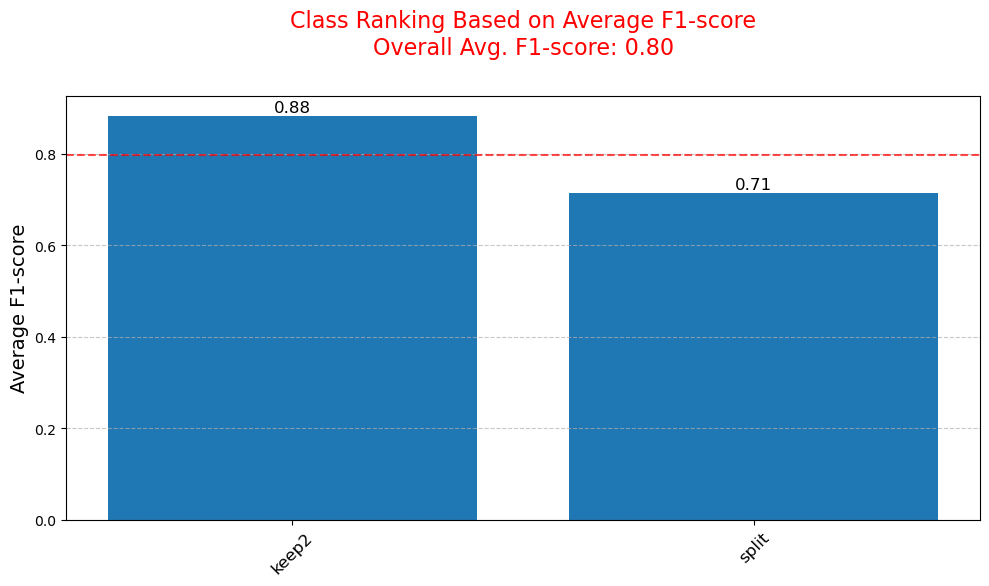

Training on fold 2/5
cuda
Epoch 1, Train Loss: 1.1710390481683943, Validation Loss: 0.5829850733280182, Accuracy: 36.61971830985915 %
Class 0 F1 Score: 0.042553191489361694
Class 1 F1 Score: 0.5263157894736842
Epoch 2, Train Loss: 0.7003471685780419, Validation Loss: 0.5740834027528763, Accuracy: 49.29577464788732 %
Class 0 F1 Score: 0.3571428571428571
Class 1 F1 Score: 0.5813953488372093
Epoch 3, Train Loss: 0.6254995067914327, Validation Loss: 0.5706712901592255, Accuracy: 70.4225352112676 %
Class 0 F1 Score: 0.7341772151898734
Class 1 F1 Score: 0.6666666666666667
Epoch 4, Train Loss: 0.5937296979957156, Validation Loss: 0.48696255683898926, Accuracy: 67.6056338028169 %
Class 0 F1 Score: 0.6760563380281689
Class 1 F1 Score: 0.6760563380281689
Epoch 5, Train Loss: 0.5720537006855011, Validation Loss: 0.5474336743354797, Accuracy: 69.01408450704226 %
Class 0 F1 Score: 0.717948717948718
Class 1 F1 Score: 0.6562499999999999
Epoch 6, Train Loss: 0.5807159708605872, Validation Loss: 0.4571

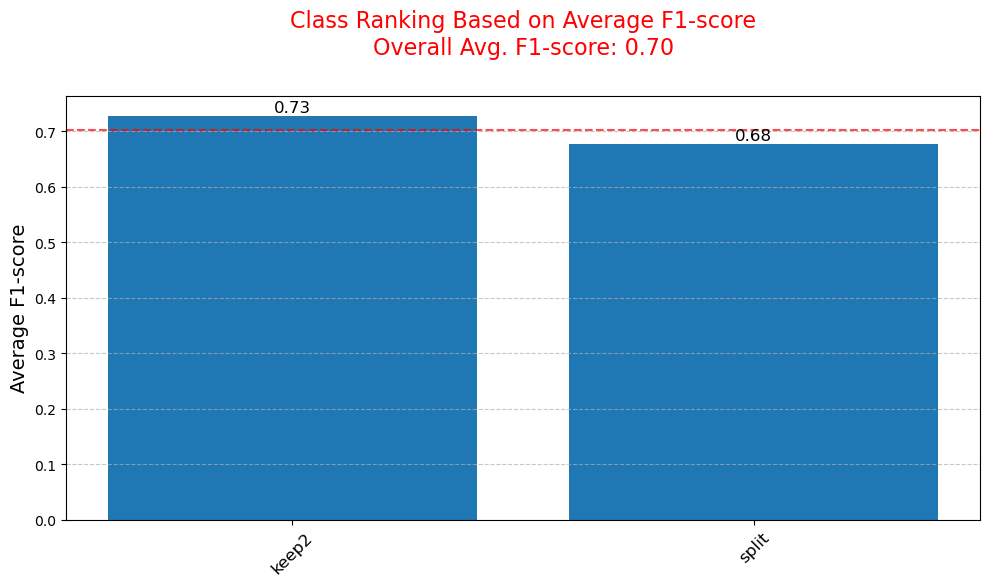

Training on fold 3/5
cuda
Epoch 1, Train Loss: 1.288371933831109, Validation Loss: 0.9802449345588684, Accuracy: 64.78873239436619 %
Class 0 F1 Score: 0.7863247863247863
Class 1 F1 Score: 0.0
Epoch 2, Train Loss: 0.6099888119432662, Validation Loss: 0.6891462504863739, Accuracy: 66.19718309859155 %
Class 0 F1 Score: 0.7073170731707318
Class 1 F1 Score: 0.6
Epoch 3, Train Loss: 0.5822757846779294, Validation Loss: 0.6777936518192291, Accuracy: 67.6056338028169 %
Class 0 F1 Score: 0.7012987012987013
Class 1 F1 Score: 0.6461538461538462
Epoch 4, Train Loss: 0.5573754145039452, Validation Loss: 0.5514667332172394, Accuracy: 67.6056338028169 %
Class 0 F1 Score: 0.7012987012987013
Class 1 F1 Score: 0.6461538461538462
Epoch 5, Train Loss: 0.5588586926460266, Validation Loss: 0.613915890455246, Accuracy: 66.19718309859155 %
Class 0 F1 Score: 0.6842105263157895
Class 1 F1 Score: 0.6363636363636365
Epoch 6, Train Loss: 0.5335734751489427, Validation Loss: 0.5821499824523926, Accuracy: 67.6056338

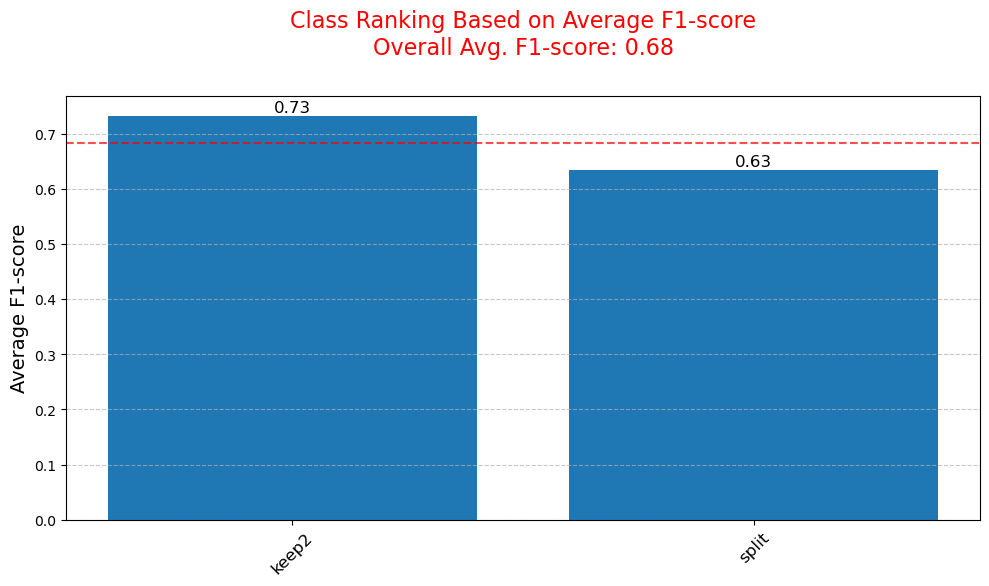

Training on fold 4/5
cuda
Epoch 1, Train Loss: 1.1852702630890741, Validation Loss: 0.6007901728153229, Accuracy: 39.436619718309856 %
Class 0 F1 Score: 0.18867924528301885
Class 1 F1 Score: 0.5168539325842697
Epoch 2, Train Loss: 0.6397413909435272, Validation Loss: 0.801659345626831, Accuracy: 61.971830985915496 %
Class 0 F1 Score: 0.7157894736842104
Class 1 F1 Score: 0.4255319148936171
Epoch 3, Train Loss: 0.5480910374058617, Validation Loss: 0.7135817110538483, Accuracy: 57.74647887323944 %
Class 0 F1 Score: 0.5714285714285714
Class 1 F1 Score: 0.5833333333333334
Epoch 4, Train Loss: 0.5494715753528807, Validation Loss: 0.6426749527454376, Accuracy: 49.29577464788732 %
Class 0 F1 Score: 0.43750000000000006
Class 1 F1 Score: 0.5384615384615384
Epoch 5, Train Loss: 0.5507049113512039, Validation Loss: 0.7371280491352081, Accuracy: 70.4225352112676 %
Class 0 F1 Score: 0.7586206896551724
Class 1 F1 Score: 0.6181818181818183
Early stopping triggered
Stopping training


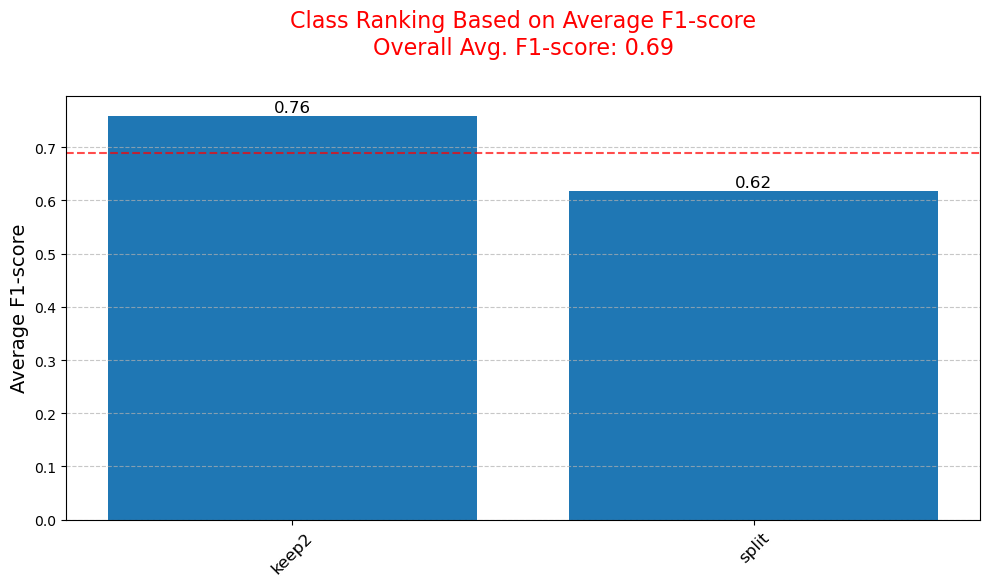

Training on fold 5/5
cuda
Epoch 1, Train Loss: 0.9791523979769813, Validation Loss: 0.806139349937439, Accuracy: 64.78873239436619 %
Class 0 F1 Score: 0.7863247863247863
Class 1 F1 Score: 0.0
Epoch 2, Train Loss: 0.6607896784941355, Validation Loss: 0.48699137568473816, Accuracy: 60.563380281690144 %
Class 0 F1 Score: 0.5625
Class 1 F1 Score: 0.641025641025641
Epoch 3, Train Loss: 0.5961734122700162, Validation Loss: 0.5943028330802917, Accuracy: 77.46478873239437 %
Class 0 F1 Score: 0.8297872340425533
Class 1 F1 Score: 0.6666666666666666
Epoch 4, Train Loss: 0.5697647680838903, Validation Loss: 0.40983612835407257, Accuracy: 64.78873239436619 %
Class 0 F1 Score: 0.647887323943662
Class 1 F1 Score: 0.647887323943662
Epoch 5, Train Loss: 0.5418983300526937, Validation Loss: 0.46349039673805237, Accuracy: 57.74647887323944 %
Class 0 F1 Score: 0.5454545454545454
Class 1 F1 Score: 0.6052631578947368
Epoch 6, Train Loss: 0.5149615092409981, Validation Loss: 0.47994016110897064, Accuracy: 76

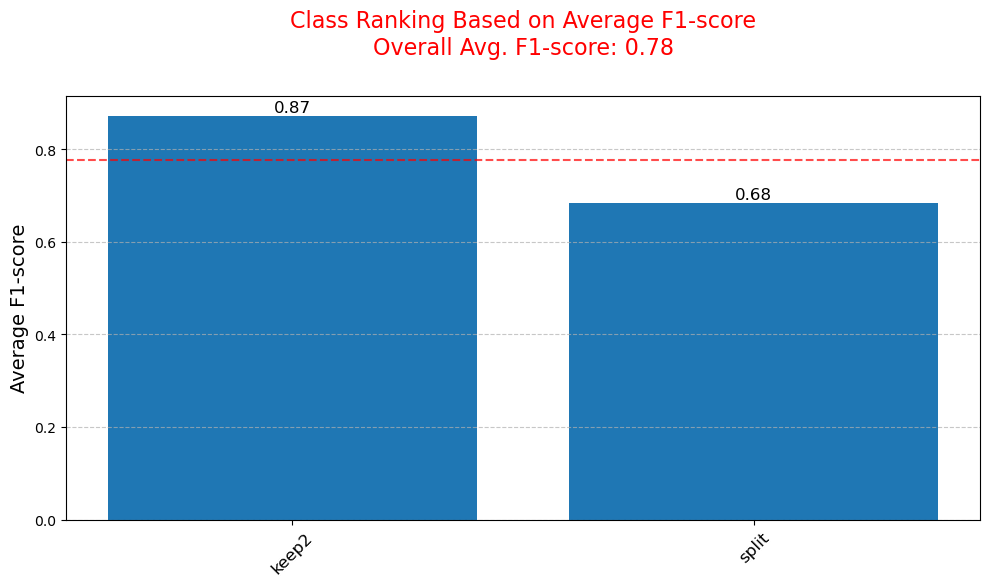

class_0_f1_score,▇▇▇▇▇██████▁▇▇▇▆▆██▆█▇▇▇██▇▆▆▇▇▇▄▇█▆▇▆██
class_1_f1_score,▁▁▆█▇▇▇███▇▆▇▇▇▇▇██▇█▇█▇██▁▇▇▇▇▅▆▁▇▇▇▇▇▇
epoch,▁▁▂▂▃▃▄▄▅▅▆▁▂▂▃▃▄▄▅▅▅▆▆▇▇█▁▂▂▃▁▂▂▂▁▂▂▃▃▄
final_accuracy,█▂▁▂▇
fold,▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▆▆▆███████
train_loss,█▄▄▄▄▃▃▃▃▂▂▄▄▄▃▃▃▃▃▂▂▁▁▁▁█▄▃▃▃▇▃▃▆▄▃▃▃▃▂
val_accuracy,▅▅▆▆▇▇▇█▇██▁▆▆▆▅▆██▆█▇▇▇▇█▅▆▅▆▆▅▃▅▇▅▇▅██
val_loss,▆▅▄▃▃▃▂▃▁▂▅▄▄▄▃▃▂▂▄▂▂▂▁▁▂▁█▅▄▅▄▆▅▆▄▂▃▂▃▄
class_0_f1_score,0.87129
class_1_f1_score,0.68293
epoch,12


In [14]:
import torch
import wandb
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold
import csv

model_names = ["microsoft/resnet-50", "microsoft/resnet-18", "microsoft/beit-base-patch16-224-pt22k-ft22k", "google/vit-base-patch16-224"]

for FILE_PATH in FILE_PATHS:
    if "DL1" in FILE_PATH:
        all_labels_list = ['keep0', 'keep1', 'reseed0']
        PATHES_LIST = PATHES_LISTS[0]
    elif "DL2" in FILE_PATH:
        PATHES_LIST = PATHES_LISTS[1]
        all_labels_list = ['keep1', 'keep2', 'reseed1']
    elif "DL3" in FILE_PATH:
        PATHES_LIST = PATHES_LISTS[2]
        all_labels_list = ['keep2', 'split']
    for model_name in model_names:
        # Initialize a new wandb run
        wandb.init(project="organoid_classification", entity="laurent-gurtler")

        num_epochs = 50
        learning_rate = 5e-5
        batch_size = 64
        k_folds = 5
        weight_decay = 1e-5

        config = wandb.config
        config.learning_rate = learning_rate
        config.batch_size = batch_size
        config.num_epochs = num_epochs
        config.k_folds = k_folds
        config.weight_decay = weight_decay

        all_fold_f1_scores = []
        num_labels = len(all_labels_list)  # The number of unique labels/classes in your dataset

        # Assuming PATHES_LIST contains paths to your different class directories
        img_labels = []
        img_sort = []
        for i, img_dir in enumerate(PATHES_LIST):
            img_files = sorted([f for f in os.listdir(img_dir) if f.endswith(".png")])
            img_labels.extend([i] * len(img_files))  # Labels for each image
            img_sort.extend([os.path.join(img_dir, f) for f in img_files])  # Paths for each image

        # Convert img_sort to a numpy array for easier indexing
        img_sort = np.array(img_sort)

        # Initialize StratifiedKFold
        kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

        # Convert img_labels to numpy array for StratifiedKFold
        img_labels = np.array(img_labels)

        # Calculate class weights
        label_counts = Counter(img_labels)
        total_count = len(img_labels)
        class_weights = {label: total_count/count for label, count in label_counts.items()}
        weights = torch.tensor([class_weights[i] for i in range(num_labels)], dtype=torch.float)


        # Move weights to GPU if available
        if torch.cuda.is_available():
            weights = weights.cuda()

        for fold, (train_idx, val_idx) in enumerate(kf.split(img_sort, img_labels)):
            print(f"Training on fold {fold+1}/{k_folds}")
            if "beit" in model_name:
                config = BeitConfig.from_pretrained(model_name, num_labels=num_labels)
                model = BeitForImageClassification(config)
            elif "resnet" in model_name:
                config = ResNetConfig.from_pretrained(model_name, num_labels=num_labels)
                model = ResNetForImageClassification(config)
            elif "vit" in model_name:
                config = ViTConfig.from_pretrained(model_name, num_labels=num_labels)
                model = ViTForImageClassification(config)
                
            criterion = torch.nn.CrossEntropyLoss(weight=weights)
            optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

            early_stopping = EarlyStopping(patience=5, min_delta=0.001)

            # Split data into training and validation for this fold
            train_data = img_sort[train_idx]
            val_data = img_sort[val_idx]

            # Create datasets for this fold
            train_dataset = CustomImageDataset_train(train_data, img_labels[train_idx], 
                                                    transform=False, 
                                                    model_name=model_name)
            test_dataset = CustomImageDataset_test(val_data, img_labels[val_idx], 
                                                transform=False, 
                                                model_name=model_name)
            

            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            print(device)
            model.to(device)

            wandb.watch(model, criterion, log="all", log_freq=10)

            epoch_f1_scores_dict_list = []

            num_images_displayed = 0
            isDisplayed = False

            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0
                for images, labels in train_loader:
                    if isDisplayed:
                        if num_images_displayed < 5:  # Change 5 to however many batches you want to visualize
                            img = images[0].cpu().numpy()
                            img = np.transpose(img, (1,2,0))
                            img = np.clip(img,0,1)
                            plt.imshow(img)
                            plt.show()  # Display the first image in the batch
                            num_images_displayed += 1
                    images = images.to(device)
                    labels = labels.to(device)  # Convert labels to torch.long
                    optimizer.zero_grad()
                    outputs = model(images).logits
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()
                
                wandb.log({"fold": fold+1, "epoch": epoch, "train_loss": running_loss/len(train_loader)})

                # Validation phase
                model.eval()
                all_labels = []
                all_predictions = []
                validation_loss = 0.0
                correct = 0
                total = 0

                with torch.no_grad():
                    for images, labels in test_loader:
                        images = images.to(device)
                        labels = labels.to(device)
                        outputs = model(images).logits
                        predicted = outputs.argmax(dim=1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()
                        loss = criterion(outputs, labels)
                        validation_loss += loss.item()

                        # Move the labels and predictions to CPU for sklearn metrics
                        all_labels.extend(labels.cpu().numpy())
                        all_predictions.extend(predicted.cpu().numpy())
                    # After processing all validation data
                    scheduler.step(validation_loss)
                    early_stopping(validation_loss)

                    if early_stopping.early_stop:
                        print("Stopping training")
                        break

                # Calculate accuracy and F1 score
                accuracy = 100 * correct / total
                f1_scores = f1_score(all_labels, all_predictions, average=None, zero_division=0)  # This will give you an array of F1 scores per class
                # Check if the length of F1 scores matches the number of labels
                if len(f1_scores) != len(all_labels_list):
                    print(f"Warning: Number of F1 scores ({len(f1_scores)}) does not match number of classes ({len(all_labels_list)})")
                    # Trim the list of F1 scores to match the number of classes, if necessary
                    f1_scores = f1_scores[:len(all_labels_list)]

                # Create a dictionary of class labels and their corresponding F1 scores
                f1_scores_dict = {all_labels_list[idx]: f1 for idx, f1 in enumerate(f1_scores)}
                epoch_f1_scores_dict_list.append(f1_scores_dict)

                # It might be useful to also get the classification report for all metrics
                classification_rep = classification_report(all_labels, all_predictions, output_dict=True, zero_division=0)

                # Logging the individual F1 scores
                for idx, f1 in enumerate(f1_scores):
                    wandb.log({f"class_{idx}_f1_score": f1})


                wandb.log({"fold": fold+1, "epoch": epoch, "val_loss": validation_loss/len(test_loader), "val_accuracy": accuracy})

                # Print statistics for each class
                print(f"Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader)}, "
                    f"Validation Loss: {validation_loss/len(test_loader)}, Accuracy: {accuracy} %")
                for idx, f1 in enumerate(f1_scores):
                    print(f"Class {idx} F1 Score: {f1}")

                for idx, f1 in enumerate(f1_scores):
                    wandb.log({f"class_{idx}_f1_score": f1})

            # Access the F1-scores for the last epoch
                # Access the F1-scores for the last epoch of this fold
            last_epoch_f1_scores = epoch_f1_scores_dict_list[-1]

            # Append model name, fold number, and F1 scores to the list
            fold_data = {"model_name": model_name, "fold": fold + 1}
            fold_data.update(last_epoch_f1_scores)
            all_fold_f1_scores.append(fold_data)

            # Clear the epoch_f1_scores_dict_list for the next fold
            epoch_f1_scores_dict_list.clear()

            # The last_epoch_f1_scores already contains the F1 scores for each class from the last epoch
            # Optionally, you can directly plot these scores if needed
            plot_average_f1_scores(all_labels_list, last_epoch_f1_scores)


            # After the loop, you may want to log the overall performance
            wandb.log({
                "fold": fold+1, "final_accuracy": accuracy,
                "fold": fold+1, "final_f1_scores": f1_scores.tolist(),  # Convert to list if necessary
                "fold": fold+1, "final_classification_report": classification_rep
            })

            csv_filename = FILE_PATH + 'f1_scores_per_fold.csv'
            existing_data = []

            # Read existing data
            if os.path.exists(csv_filename):
                with open(csv_filename, 'r') as file:
                    reader = csv.DictReader(file)
                    existing_data = [row for row in reader]

            # Update or append new data
            for new_data in all_fold_f1_scores:
                model_found = False
                for existing_row in existing_data:
                    if existing_row['model_name'] == new_data['model_name'] and existing_row['fold'] == str(new_data['fold']):
                        # Update existing row with new data
                        for key, value in new_data.items():
                            existing_row[key] = value
                        model_found = True
                        break
                if not model_found:
                    # Convert numeric values to strings for CSV writing
                    new_data_string = {k: str(v) for k, v in new_data.items()}
                    existing_data.append(new_data_string)

            # Write updated data back to CSV
            header = ['model_name', 'fold'] + all_labels_list

            with open(csv_filename, 'w', newline='') as file:
                writer = csv.DictWriter(file, fieldnames=header)
                writer.writeheader()
                for data_row in existing_data:
                    writer.writerow(data_row)

        # Close the wandb run
        wandb.finish()


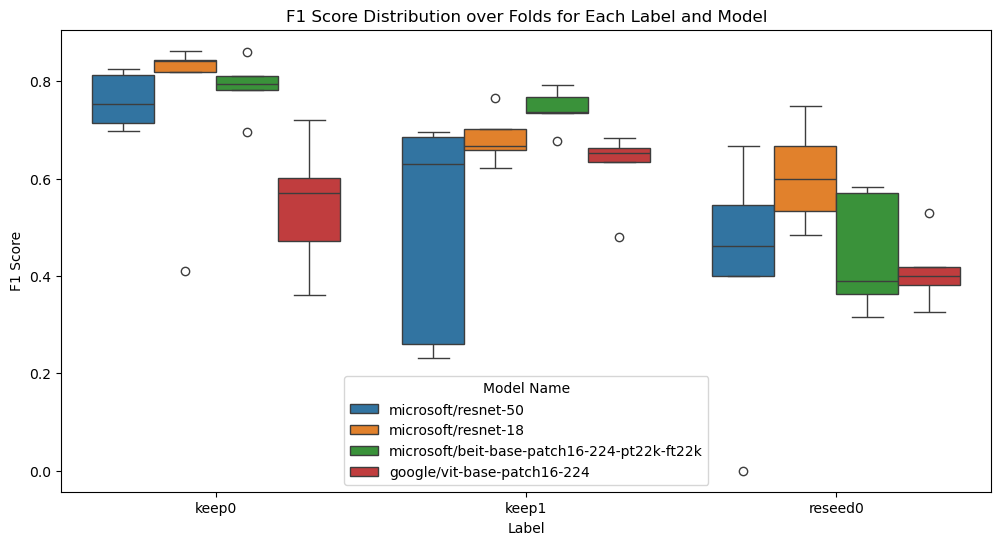

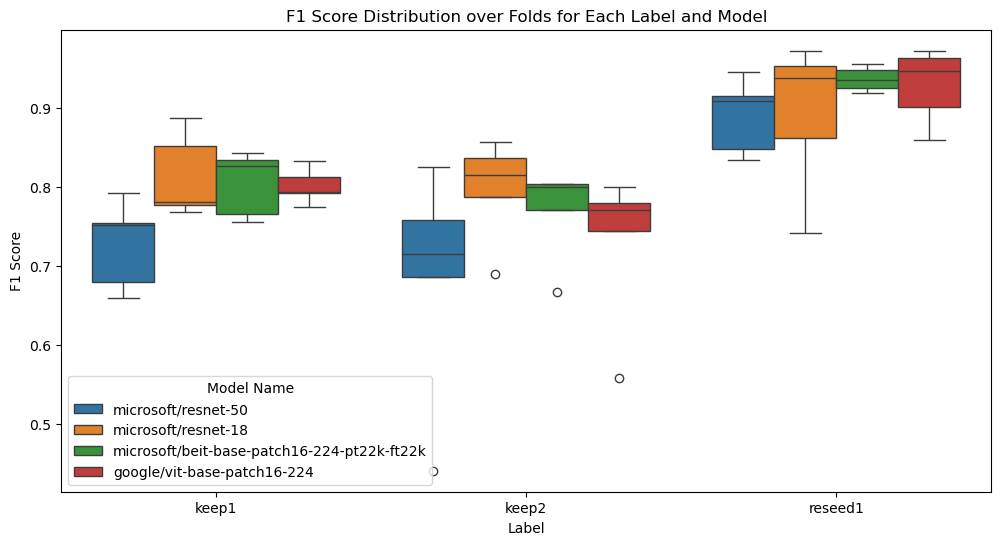

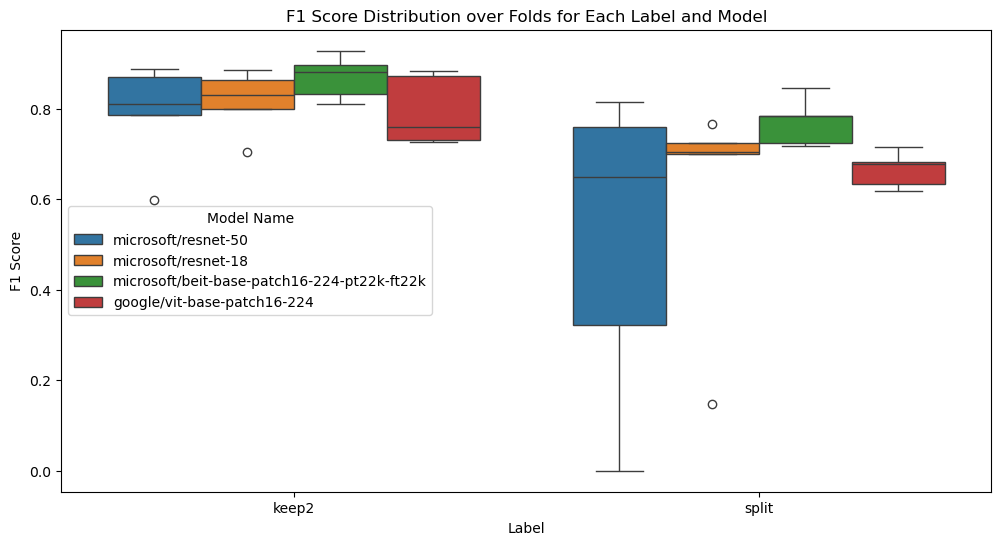

In [16]:
import seaborn as sns

all_labels_lists = [["keep0","keep1","reseed0"], ["keep1","keep2","reseed1"], ["keep2","split"]]
for i ,file_path in enumerate(FILE_PATHS):
    csv_filename = file_path + "f1_scores_per_fold.csv"
    df = pd.read_csv(csv_filename)
    df_long = df.melt(id_vars=['model_name', 'fold'], 
                    value_vars=all_labels_lists[i],  # list all your label columns here
                    var_name='label', value_name='f1_score')
    # Creating a boxplot for each label within each model
    plt.figure(figsize=(12, 6))

    # You might need to adjust the size of the figure based on the number of models and labels
    sns.boxplot(x='label', y='f1_score', hue='model_name', data=df_long)

    plt.title('F1 Score Distribution over Folds for Each Label and Model')
    plt.xlabel('Label')
    plt.ylabel('F1 Score')
    plt.legend(title='Model Name')
    plt.show()

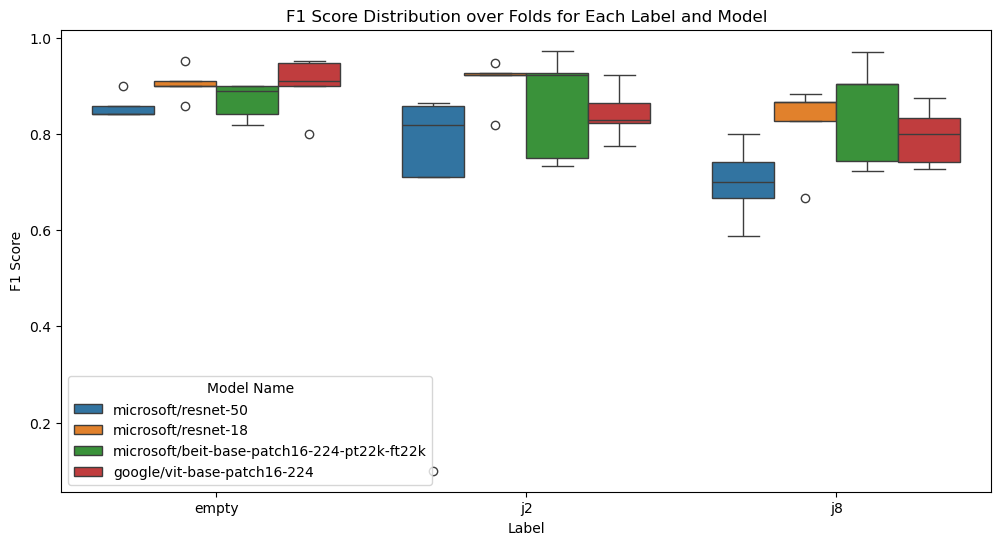

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

all_labels_lists = ["empty","j2","j8"]
csv_filename = "E:/mouse_organoids_laure/" + "f1_scores_per_fold_4_models.csv"
df = pd.read_csv(csv_filename)
df_long = df.melt(id_vars=['model_name', 'fold'], 
                value_vars=all_labels_lists,  # list all your label columns here
                var_name='label', value_name='f1_score')
# Creating a boxplot for each label within each model
plt.figure(figsize=(12, 6))

# You might need to adjust the size of the figure based on the number of models and labels
sns.boxplot(x='label', y='f1_score', hue='model_name', data=df_long)

plt.title('F1 Score Distribution over Folds for Each Label and Model')
plt.xlabel('Label')
plt.ylabel('F1 Score')
plt.legend(title='Model Name')
plt.show()